Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 7 - ML-based Approaches to Time Series Forecasting

이전 장에서는 시계열 분석에 대한 간략한 소개와 ARIMA 및 ETS와 같은 통계적 접근 방식을 사용한 시계열 예측 방법을 설명했습니다. 이러한 접근 방식은 여전히 매우 인기가 있지만 다소 구식입니다. 이번 장에서는 보다 최신의 머신러닝 기반 시계열 예측 방법에 초점을 맞춥니다.

우리는 먼저 시계열 모델을 검증하는 다양한 방법을 설명합니다. 그런 다음 머신러닝 모델의 입력 요소, 즉 특징에 대해 논의합니다. 우리는 수백 또는 수천 개의 특징을 자동으로 추출하는 도구를 소개합니다.

두 가지 주제를 다룬 후, 우리는 감소된 회귀(reduced regression) 개념을 도입합니다. 이는 시계열 예측 문제를 일반적인 회귀 문제로 재구성할 수 있게 해줍니다. 따라서 scikit-learn, XGBoost, LightGBM 등에서 제공하는 검증된 회귀 알고리즘을 시계열 예측에 사용할 수 있습니다. 그다음으로, Meta의 Prophet 알고리즘을 사용하는 방법을 설명합니다. 마지막으로, 소수의 코드로 수십 개의 머신러닝 모델을 학습시키고 튜닝할 수 있는 AutoML 도구 중 하나를 소개하며 장을 마무리합니다.

이번 장에서는 다음과 같은 항목들을 다룹니다:
- 시계열에 대한 검증 방법
- 시계열을 위한 특징 엔지니어링
- 감소된 회귀로서의 시계열 예측
- Meta의 Prophet을 사용한 예측
- PyCaret을 사용한 시계열 예측을 위한 AutoML

## 7.1 Validation methods for time series

이전 장에서 우리는 몇 가지 통계 모델을 훈련하여 시계열의 미래 값을 예측했습니다. 모델의 성능을 평가하기 위해 데이터를 훈련 세트와 테스트 세트로 나누었습니다. 그러나 이는 모델 검증의 유일한 방법이 아닙니다.

모델 성능을 평가하는 매우 인기 있는 접근 방식은 **교차 검증(cross-validation)** 입니다. 교차 검증은 모델의 일반화 오류를 신뢰성 있게 추정할 수 있게 해주며, 특히 작은 데이터셋을 다룰 때 유용합니다.

기본적인 교차 검증 방식은 **k-겹 교차 검증(k-fold cross-validation)** 으로, 훈련 데이터를 k개의 폴드로 무작위로 나누고, k-1개의 폴드로 모델을 훈련한 후 나머지 1개의 폴드에서 성능을 평가합니다. 이를 k번 반복하여 결과 점수를 평균냅니다.

<img src="image/fig_07_01.png" width=800>

Figure 7.1: Schema of k-fold cross-validation


이미 눈치챘을 수도 있겠지만, **k-겹 교차 검증** 은 시계열 모델을 평가하는 데 적합하지 않습니다. 왜냐하면 이는 시간의 순서를 유지하지 않기 때문입니다. 예를 들어, 첫 번째 라운드에서 마지막 4개의 폴드 데이터를 사용하여 모델을 훈련하고, 첫 번째 폴드를 사용해 평가하는 방식입니다.

**k-겹 교차 검증** 은 일반 회귀 및 분류 작업에 매우 유용하므로, 13장에서 더 깊이 다루겠습니다. 

Bergmeir 외(2018)는 순수 자기회귀 모델의 경우, 고려되는 모델들이 상관되지 않은 오류를 가질 때 표준 **k-겹 교차 검증** 을 사용할 수 있음을 보여주었습니다.

다행히도, **k-겹 교차 검증** 개념을 시계열 도메인에 쉽게 적용할 수 있습니다. 결과적으로 나오는 접근법을 **순차적 검증(walk-forward validation)** 이라고 합니다. 이 검증 방식에서 우리는 훈련 윈도우를 하나 또는 여러 폴드씩 확장/이동시킵니다.

그림 7.2는 **확장 윈도우 방식의 순차적 검증** 을 보여줍니다. 이를 **고정된 순차적 검증(anchored walk-forward validation)** 이라고도 합니다.

<img src="image/fig_07_02.png" width=800>

Figure 7.2: Walk-forward validation with an expanding window

이 접근법은 일종의 편향을 수반합니다. 초기 라운드에서는 모델을 훈련시키기 위해 사용하는 역사적 데이터가 후반 라운드보다 훨씬 적기 때문에, 각 라운드의 오류는 직접적으로 비교하기 어렵습니다. 예를 들어, 검증의 초기 라운드에서는 계절 패턴을 제대로 학습할 수 있을 만큼 충분한 훈련 데이터가 없을 수 있습니다.

이 문제를 해결하기 위한 시도로, 확장 방식 대신 슬라이딩 윈도우 방식을 사용할 수 있습니다. 그 결과, 모든 모델은 동일한 양의 데이터를 사용해 훈련되므로 오류를 직접적으로 비교할 수 있습니다.

<img src="image/fig_07_03.png" width=800>

Figure 7.3: Walk-forward validation with a sliding window

이 접근법은 훈련 데이터가 많을 때(각 슬라이딩 윈도우가 모델이 패턴을 잘 학습하기에 충분할 때) 또는 미래를 예측하기 위해 과거의 관련 패턴을 멀리까지 볼 필요가 없을 때 사용할 수 있습니다.

우리는 **중첩 교차 검증(nested cross-validation)** 을 사용하여 모델의 성능을 추정하면서 동시에 하이퍼파라미터를 튜닝할 수 있습니다. 중첩 교차 검증에서는 외부 루프가 모델의 성능을 추정하고, 내부 루프가 하이퍼파라미터 튜닝에 사용됩니다.

이 레시피에서는 미국 실업률 예측을 평가하기 위해 확장 윈도우와 슬라이딩 윈도우를 사용하는 순차적 검증 방법을 보여줍니다.

### How to do it...

다음 단계들을 실행하여 워크 포워드 검증을 사용해 모델의 성능을 계산하세요

1. Import the libraries and authenticate:

먼저, 필요한 라이브러리를 불러오고 Nasdaq Data Link에 인증했습니다. 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import nasdaqdatalink
import yfinance as yf
import os

nasdaqdatalink.ApiConfig.api_key = os.environ["NASDAQ_API_KEY"]

2. Download the monthly US unemployment rate from years 2010-2019:

두 번째 단계에서는 월별 미국 실업률 데이터를 다운로드했습니다. 이는 이전 장에서 작업한 시계열 데이터와 동일합니다.

**UNRATE**와 **UNRATENSA**의 차이는 다음과 같습니다:

1. **UNRATE (Seasonally Adjusted Unemployment Rate)**:
   - **UNRATE**는 미국의 실업률을 계절적 요인을 제거하여 조정한 값입니다.
   - 계절 조정(Seasonal Adjustment)은 실업률이 매년 특정한 패턴을 보이는 요인들(예: 여름방학, 연말 쇼핑 시즌, 농업 활동 등)을 반영해 실제 경제 상황을 더 정확하게 평가하기 위해 사용됩니다.
   - 계절적 변동 요인을 제거함으로써 매달 또는 분기별로 실업률을 비교할 때 더 일관된 추세를 파악할 수 있습니다.

2. **UNRATENSA (Not Seasonally Adjusted Unemployment Rate)**:
   - **UNRATENSA**는 계절적 요인을 제거하지 않은, 실제로 관측된 실업률입니다.
   - 이 데이터는 계절적 변동을 반영하므로 특정 시기(예: 여름이나 연말)에 따라 실업률이 더 높거나 낮게 나타날 수 있습니다.
   - 예를 들어, 여름철에는 임시 고용이 많아지면서 실업률이 일시적으로 낮아질 수 있고, 겨울철에는 고용이 줄어 실업률이 높아질 수 있습니다.

요약:
- **UNRATE**: 계절 조정된 실업률로, 일관된 추세 분석이 가능함.
- **UNRATENSA**: 계절 조정되지 않은 실업률로, 계절적 요인이 반영된 값.

실제 경제 분석에서는 일반적으로 **UNRATE**(계절 조정된 데이터)가 더 자주 사용되며, 경제의 기본적인 추세를 더 잘 파악할 수 있습니다. **UNRATENSA**는 특정한 기간에 계절적 요인이 경제에 미치는 영향을 평가할 때 유용할 수 있습니다.

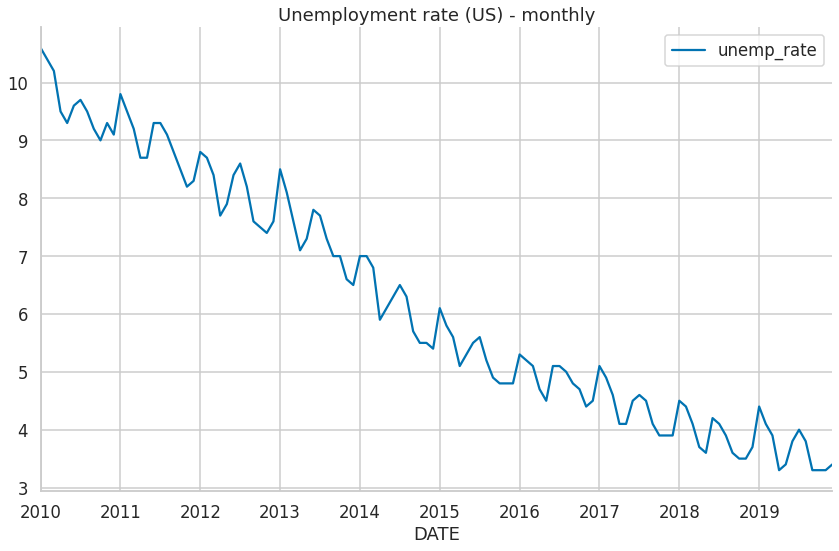

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
import pandas_datareader as pdr

# 책에서 제시된 코드
# df = (
#     nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
#                        start_date="2010-01-01", 
#                        end_date="2019-12-31")
#     .rename(columns={"Value": "unemp_rate"})
# )

# # web.DataReader 사용
df = web.DataReader('UNRATENSA', 'fred', start='2010-01-01', end='2019-12-31')
df = df.rename(columns={'UNRATENSA': 'unemp_rate'})

# get_data_fred 사용
# df = pdr.get_data_fred('UNRATENSA', '2010-01-01', '2019-12-31')
# df = df.rename(columns={'UNRATENSA': 'unemp_rate'})

# FRED_API 사용
# fred_api_key = os.environ['FRED_API_KEY']
# fred = Fred(api_key=fred_api_key)
# unemployment_data = fred.get_series('UNRATENSA', observation_start='2010-01-01', observation_end='2019-12-31')
# df = pd.DataFrame(unemployment_data, columns=['unemp_rate'])

# Plot the unemployment rate
df.plot(title="Unemployment rate (US) - monthly")
plt.tight_layout()
sns.despine()
plt.show()

3. Create simple features:

**3단계** 에서는 두 가지 간단한 특징을 만들었습니다: 
- **선형 추세**: 이는 순서대로 정렬된 시계열의 행 번호입니다. 실업률의 전반적인 추세가 감소하는 것을 확인했습니다.
- **월 지표**: 이는 관찰된 데이터가 어느 달에서 왔는지 식별하는 지표입니다.

In [60]:
df["linear_trend"] = range(len(df))
df["month"] = df.index.month
df

,unemp_rate,linear_trend,month
DATE,,,
2010-01-01,10.6,0,1
2010-02-01,10.4,1,2
2010-03-01,10.2,2,3
2010-04-01,9.5,3,4
2010-05-01,9.3,4,5
...,...,...,...
2019-08-01,3.8,115,8
2019-09-01,3.3,116,9
2019-10-01,3.3,117,10


4. Use one-hot encoding for the month feature:

**4단계** 에서는 `get_dummies` 함수를 사용해 월 특징을 원-핫 인코딩했습니다. 이와 관련된 자세한 내용은 13장과 14장에서 다룹니다. 우리는 새로운 열을 만들었으며, 각 열은 해당 관찰이 특정 월에서 왔는지 여부를 나타내는 부울 플래그입니다. 또한 다중공선성 문제를 피하기 위해 첫 번째 열을 제거했습니다.

In [61]:
month_dummies = pd.get_dummies(
    df["month"], drop_first=True, prefix="month"
)

df = df.join(month_dummies) \
       .drop(columns=["month"])

df

,unemp_rate,linear_trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
2010-01-01,10.6,0,0,0,0,0,0,0,0,0,0,0,0
2010-02-01,10.4,1,1,0,0,0,0,0,0,0,0,0,0
2010-03-01,10.2,2,0,1,0,0,0,0,0,0,0,0,0
2010-04-01,9.5,3,0,0,1,0,0,0,0,0,0,0,0
2010-05-01,9.3,4,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,3.8,115,0,0,0,0,0,0,1,0,0,0,0
2019-09-01,3.3,116,0,0,0,0,0,0,0,1,0,0,0
2019-10-01,3.3,117,0,0,0,0,0,0,0,0,1,0,0


5. Separate the target from the features:

**5단계**에서는 `pandas` DataFrame의 `pop` 메서드를 사용해 특징을 목표 변수와 분리했습니다.

In [62]:
X = df.copy()
y = X.pop("unemp_rate")

In [63]:
X.shape

(120, 12)

6. Define the expanding window walk-forward validation and print the indices of the folds:

**6단계**에서는 `scikit-learn`의 `TimeSeriesSplit` 클래스를 사용해 순차적 검증을 정의했습니다. 우리는 5개의 분할을 하고, 테스트 크기는 12개월이 되도록 설정했습니다. 이 검증 방식은 모델이 향후 12개월 동안 월별 실업률을 예측하는 방식과 유사해야 합니다.

- `TimeSeriesSplit`은 `scikit-learn`에서 제공하는 시계열 데이터를 위한 교차 검증 도구입니다. 일반적인 교차 검증과 달리, 시계열 데이터의 시간 순서를 유지하면서 데이터를 분할합니다. 이는 시계열 데이터의 특성을 고려하여 모델의 성능을 평가하는 데 유용합니다.
- 그런 다음, 각 교차 검증 라운드에서 훈련 및 검증 인덱스를 출력하기 위해 `for` 루프를 사용했습니다. `TimeSeriesSplit` 클래스의 `split` 메서드가 반환한 인덱스는 순서대로지만, 이를 실제 시계열 데이터의 인덱스에 쉽게 매핑할 수 있습니다.
- 자기회귀 특징을 사용하지 않기로 결정했는데, 이를 사용하지 않아도 무작위로 먼 미래를 예측할 수 있기 때문입니다. 물론 AR 특징을 사용할 수도 있지만, 이 경우 적절하게 처리해야 합니다.

In [64]:
# TimeSeriesSplit을 사용하여 확장 윈도우 교차 검증 설정
# n_splits=5: 5개의 분할 생성
# test_size=12: 각 테스트 세트의 크기를 12개월로 설정
expanding_cv = TimeSeriesSplit(n_splits=5, test_size=12)

# 각 폴드에 대해 훈련 및 검증 인덱스 출력
for fold, (train_ind, valid_ind) in enumerate(expanding_cv.split(X)):
    print(f"Fold {fold} ----")
    print(f"Train indices: {train_ind}")  # 훈련 세트의 인덱스 출력
    print(f"Valid indices: {valid_ind}")  # 검증 세트의 인덱스 출력

Fold 0 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Valid indices: [60 61 62 63 64 65 66 67 68 69 70 71]
Fold 1 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Valid indices: [72 73 74 75 76 77 78 79 80 81 82 83]
Fold 2 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
Valid indices: [84 85 86 87 88 89 90 91 92 93 94 95]
Fold 3 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23

첫 번째 반복에서는 모델이 5년간의 데이터를 사용해 학습되고 6년 차 데이터를 사용해 평가된다는 것을 알 수 있습니다. 두 번째 반복에서는 첫 6년간의 데이터를 사용해 학습되고 7년 차 데이터를 사용해 평가되며, 이와 같은 방식으로 진행됩니다.
- **확장 윈도우 방식**: 각 분할에서 훈련 데이터는 이전 분할의 훈련 데이터에 새로운 데이터를 추가하여 확장됩니다.
- **고정된 테스트 크기**: 각 분할에서 테스트 데이터의 크기는 12로 고정되어 있습니다.
- **시간 순서 유지**: 훈련 데이터와 테스트 데이터는 시간 순서를 유지하면서 분할됩니다.

7. Evaluate the model's performance using the expanding window validation:

**7단계**에서는 유사한 `for` 루프를 사용해 모델 성능을 평가했습니다. 루프의 각 반복에서 해당 반복의 훈련 데이터를 사용해 선형 회귀 모델을 훈련하고, 해당 검증 세트를 사용해 예측을 생성했습니다. 마지막으로, MAPE로 표현된 성능을 계산했습니다. 우리는 CV 점수를 목록에 추가한 다음, 교차 검증 5라운드 동안의 평균 성능을 계산했습니다.

In [65]:
# 성능 점수를 저장할 빈 리스트 초기화
scores = [] 

# 확장 윈도우 교차 검증 수행
for train_ind, valid_ind in expanding_cv.split(X):
    # 선형 회귀 모델 초기화
    lr = LinearRegression()
    # 훈련 데이터로 모델 학습
    lr.fit(X.iloc[train_ind], y.iloc[train_ind])
    # 검증 데이터에 대한 예측 수행
    y_pred = lr.predict(X.iloc[valid_ind])
    # 평균 절대 백분율 오차(MAPE) 계산 및 scores 리스트에 추가
    scores.append(
        mean_absolute_percentage_error(y.iloc[valid_ind], y_pred)
    )
# 각 폴드의 MAPE 점수 출력
print(f"Scores: {scores}")
# 모든 폴드의 평균 MAPE 점수 출력
print(f"Avg. score: {np.mean(scores)}")

Scores: [0.03705079312389477, 0.07828415627306347, 0.11981060282172921, 0.16829494012910837, 0.254604596516341]
Avg. score: 0.13160901777282735


사용자 지정 `for` 루프 대신 `scikit-learn` 라이브러리의 `cross_validate` 함수를 사용할 수 있습니다. 이를 사용할 때의 잠재적 장점은 모델의 적합 및 예측 단계에 소요된 시간을 자동으로 계산해 준다는 점입니다. 우리는 이 방법을 사용해 MAPE 및 MSE 점수를 얻는 방법을 보여주었습니다.

`cross_validate` 함수(또는 Grid Search와 같은 다른 `scikit-learn` 기능)를 사용할 때 주의할 점은 메트릭 이름을 제공해야 한다는 것입니다. 이는 `scikit-learn`의 `metrics` 모듈에서 사용되는 관례로, 메트릭 값이 높을수록 성능이 좋지 않다는 것을 의미하기 때문입니다. 따라서, 이러한 메트릭을 최소화하려는 경우 메트릭 값은 음수로 변환됩니다.

아래는 시계열 예측의 정확도를 평가하기 위해 사용되는 가장 인기 있는 지표들의 목록입니다:

- **Mean Squared Error (MSE)** — 머신러닝에서 가장 인기 있는 지표 중 하나입니다. 원래 예측과 동일한 단위가 아니므로 직관적이지 않지만, 동일한 데이터셋에서 여러 모델의 상대적 성능을 비교할 수 있습니다.
- **Root Mean Squared Error (RMSE)** — MSE의 제곱근을 사용하여 원래 시계열과 동일한 스케일로 변환됩니다.
- **Mean Absolute Error (MAE)** — 제곱 대신 절대값을 사용합니다. 그 결과, MAE는 원래 시계열과 동일한 스케일로 표현됩니다. 더 중요한 점은 MAE가 이상치에 대해 더 관대하다는 것입니다.
- **Mean Absolute Percentage Error (MAPE)** — MAE와 매우 유사하지만 퍼센티지로 표현됩니다. 따라서 많은 비즈니스 이해관계자들이 더 쉽게 이해할 수 있습니다. 그러나 실제 값이 0인 경우, 이 지표는 오류를 실제 값으로 나누는 것이 불가능해지는 심각한 단점을 가지고 있습니다.

    MAPE(평균 절대 백분율 오차)의 수식은 다음과 같습니다:
    
    $ \text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100 $

    여기서:
    - $ n $: 데이터 포인트의 수
    - $ y_i $: 실제 값
    - $ \hat{y}_i $: 예측 값


In [66]:
# cross_validate 함수를 사용하여 모델 성능 평가
cv_scores = cross_validate(
    LinearRegression(),  # 선형 회귀 모델 사용
    X, y,  # 특성 데이터 X와 목표 변수 y
    cv=expanding_cv,  # 확장 윈도우 교차 검증 사용
    scoring=["neg_mean_absolute_percentage_error",  # MAPE 점수 계산 (음수로 변환됨)
             "neg_root_mean_squared_error"]  # RMSE 점수 계산 (음수로 변환됨)
)

# 결과를 데이터프레임으로 변환하여 출력
pd.DataFrame(cv_scores)

,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error
0,0.001925,0.001207,-0.037051,-0.232500
1,0.002634,0.001256,-0.078284,-0.433547
2,0.001454,0.000895,-0.119811,-0.520073
3,0.001694,0.000990,-0.168295,-0.662540
4,0.001397,0.000829,-0.254605,-0.928998


Figure 7.5: The scores of each of the validation rounds using a walk-forward CV with an expanding window

In [67]:
-1 * cv_scores["test_neg_mean_absolute_percentage_error"].mean()

0.13160901777282735

MAPE를 집계한 결과, 평균 점수는 13.1%로 나타났습니다. 

8. Define the sliding window validation and print the indices of the folds:

**8단계**와 **9단계**에서는 슬라이딩 윈도우 접근 방식을 사용하여 검증 스키마를 만드는 방법을 보여주었습니다. 유일한 차이점은 `max_train_size` 인수를 지정했다는 점입니다.

In [68]:
# 슬라이딩 윈도우 교차 검증을 위한 TimeSeriesSplit 객체 생성
# n_splits: 분할 횟수, test_size: 테스트 세트 크기, max_train_size: 최대 훈련 세트 크기
sliding_cv = TimeSeriesSplit(
    n_splits=5, test_size=12, max_train_size=60
)

# 각 폴드에 대해 훈련 및 검증 인덱스 출력
for fold, (train_ind, valid_ind) in enumerate(sliding_cv.split(X)):
    print(f"Fold {fold} ----")
    print(f"Train indices: {train_ind}")  # 훈련 세트 인덱스 출력
    print(f"Valid indices: {valid_ind}")  # 검증 세트 인덱스 출력

Fold 0 ----
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Valid indices: [60 61 62 63 64 65 66 67 68 69 70 71]
Fold 1 ----
Train indices: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71]
Valid indices: [72 73 74 75 76 77 78 79 80 81 82 83]
Fold 2 ----
Train indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
Valid indices: [84 85 86 87 88 89 90 91 92 93 94 95]
Fold 3 ----
Train indices: [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91 92 93 94 9

- 매번, 모델은 정확히 5년치 데이터를 사용하여 학습됩니다.
- 교차 검증 라운드 간에는 12개월씩 이동합니다.
- 검증 폴드는 확장 윈도우 검증을 사용할 때 본 것과 일치합니다. 따라서 어느 접근 방식이 더 나은지 점수를 쉽게 비교할 수 있습니다.

9. Evaluate the model's performance using the sliding window validation:

In [69]:
# 슬라이딩 윈도우 교차 검증을 사용하여 모델 성능 평가
cv_scores = cross_validate(
    LinearRegression(),  # 선형 회귀 모델 사용
    X, y,  # 특성 데이터 X와 목표 변수 y
    cv=sliding_cv,  # 슬라이딩 윈도우 교차 검증 사용
    scoring=["neg_mean_absolute_percentage_error",  # MAPE 점수 계산 (음수로 변환됨)
             "neg_root_mean_squared_error"]  # RMSE 점수 계산 (음수로 변환됨)
)

# 결과를 데이터프레임으로 변환하여 출력
pd.DataFrame(cv_scores)

,fit_time,score_time,test_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error
0,0.003038,0.002946,-0.037051,-0.232500
1,0.003110,0.001501,-0.097125,-0.524333
2,0.001882,0.001147,-0.126609,-0.550749
3,0.001340,0.000862,-0.129454,-0.518194
4,0.001271,0.000843,-0.108759,-0.407428


Figure 7.6: The scores of each of the validation rounds using a walk-forward CV with a sliding window

In [70]:
# cv_scores의 "test_neg_mean_absolute_percentage_error" 열의 평균값을 계산하고 -1을 곱함
# 이는 원래 음수로 저장된 MAPE 점수를 양수로 변환하여 실제 MAPE 값을 얻기 위함
-1 * cv_scores["test_neg_mean_absolute_percentage_error"].mean()

0.09979962624891407

MAPE를 집계한 결과, 평균 점수는 9.97%로 나타났습니다. 각 반복에서 5년치 데이터를 사용하는 것이 확장 윈도우를 사용할 때(13.1%)보다 더 나은 평균 점수를 도출하는 것으로 보입니다. 이 특정 경우에서는 더 많은 데이터를 사용하는 것이 더 나은 모델로 이어지지 않는다는 잠재적인 결론을 내릴 수 있습니다. 대신, 가장 최근의 데이터 포인트만을 사용했을 때 더 나은 모델을 얻을 수 있습니다.

### There's more...

이 레시피에서는 시계열 모델을 검증하는 표준 접근 방식을 설명했습니다. 그러나 실제로는 더 많은 고급 검증 방법들이 있으며, 대부분은 금융 도메인에서 비롯된 것입니다. 금융 시계열을 기반으로 한 모델 검증은 여러 이유로 더 복잡해지기 때문입니다. 아래에서 더 고급 방법들 중 일부와 그들이 해결하려는 문제들을 간단히 언급하겠습니다.

`TimeSeriesSplit`의 한계 중 하나는 기록 수준에서만 작동하며 그룹핑을 처리할 수 없다는 점입니다. 일일 주식 수익률 데이터를 가지고 있다고 가정해보세요. 우리의 거래 알고리즘 사양에 따르면 주간 또는 월간 수준에서 성과를 평가해야 하고, 주간/월간 그룹 간에는 관측치가 중복되지 않아야 합니다. **그림 7.7** 에서는 이 개념을 훈련 그룹 크기를 3으로 하고 검증 그룹 크기를 1로 설정하여 설명하고 있습니다.

<img src="./image/fig_07_07.png" width=800>

Figure 7.7: Schema of group time series validation

주별 또는 월별로 관측치를 그룹화하기 위해, `TimeSeriesSplit`과 `GroupKFold`의 조합인 **그룹 시계열 검증** 을 사용해야 합니다. 인터넷에는 이 개념의 다양한 구현이 있으며, 그 중 하나는 `mlxtend` 라이브러리에서 찾을 수 있습니다.

금융 시계열을 예측하고 모델 성능을 평가할 때 발생할 수 있는 잠재적인 문제를 더 잘 설명하기 위해, 시계열과 연결된 우리의 정신 모델(사람들이 어떻게 세상을 바라보고 문제를 해결하는지에 대한 마음속의 지도)을 확장해야 합니다. 이러한 시계열에는 실제로 두 개의 타임스탬프가 있습니다: 

- 예측 또는 거래 타임스탬프: 머신러닝 모델이 예측을 수행하고 거래를 개시할 때
- 평가 또는 이벤트 타임스탬프: 예측 또는 거래에 대한 응답이 발생하고 예측 오류를 실제로 계산할 수 있을 때

예를 들어, 특정 주식의 가격이 다음 5 영업일 동안 X만큼 증가하거나 감소할 것이라고 예측하는 분류 모델이 있을 수 있습니다. 이 예측을 바탕으로 거래 결정을 내립니다. 롱 포지션을 취할 수 있으며, 그 후 5일 동안 많은 일이 일어날 수 있습니다. 가격이 X만큼 움직이지 않을 수도 있고, 스탑로스나 이익 실현 메커니즘이 작동할 수도 있으며, 또는 포지션을 청산할 수도 있습니다. 따라서 우리는 실제로 5일 후 평가 타임스탬프에서 예측을 평가할 수 있습니다.

이러한 프레임워크는 테스트 세트의 정보를 학습 세트로 누출시킬 위험이 따릅니다. 그 결과, 모델의 성능이 과도하게 상승할 가능성이 매우 높습니다. 따라서 모든 데이터가 실제 시점(point-in-time)에 존재하는지 확인해야 하며, 그 데이터가 모델이 사용될 때 실제로 사용 가능한 데이터임을 보장해야 합니다.

예를 들어, 학습/검증 분할점 근처에서는 평가 시간이 예측 시간보다 늦은 학습 샘플이 있을 수 있습니다. 이러한 중복 샘플은 상호 상관되어 있거나 독립적이지 않으며, 세트 간에 정보를 누출시킬 수 있습니다.

이러한 미래 데이터 참조 편향(look-ahead bias)을 해결하기 위해, 우리는 **퍼징(purging)** 을 적용할 수 있습니다. 이 아이디어는 평가 시간이 검증 세트의 가장 이른 예측 시간보다 늦은 학습 샘플을 제거하는 것입니다. 즉, 평가 이벤트가 검증 세트의 예측 시간과 겹치는 관측치를 제거합니다. **그림 7.8** 은 이 개념의 예시를 보여줍니다.

<img src="./image/fig_07_08.png" width=800>

Figure 7.8: Example of purging

`purging`을 사용한 워크 포워드 교차 검증 코드는 **Advances in financial machine learning**(De Prado, 2018) 또는 **timeseriescv** 라이브러리에서 찾을 수 있습니다.

퍼징만으로는 모든 누출을 제거하기에 충분하지 않을 수 있습니다. 이는 시간이 지나면서 샘플 간 상관관계가 발생할 수 있기 때문입니다. 이를 해결하기 위해 **엠바고(embargo)** 를 적용할 수 있습니다. 엠바고는 검증 샘플에 해당하는 이후의 학습 샘플도 제거하는 방식입니다. 만약 학습 샘플의 예측 시간이 엠바고 기간에 속하게 된다면, 해당 관측치는 학습 세트에서 삭제합니다. **그림 7.9**는 퍼징과 엠바고를 모두 적용하는 과정을 보여줍니다.

<img src="./image/fig_07_09.png" width=800>

Figure 7.9: Example of purging and embargo

퍼징과 엠바고에 대한 더 자세한 내용(및 Python에서의 구현)은 **Advances in financial machine learning** (De Prado, 2018)을 참조하십시오.

De Prado(2018)는 퍼징과 엠바고 개념을 백테스팅(백테스팅은 **Chapter 12, Backtesting Trading Strategies** 에서 다룹니다) 및 교차 검증과 결합한 **조합 퍼징 교차 검증 알고리즘(combinatorial purged cross-validation algorithm)** 도 도입했습니다.

### See also
- Bergmeir, C., & Benítez, J. M. 2012. “On the use of cross-validation for time series predictor evaluation,” *Information Sciences*, 191: 192-213.
- Bergmeir, C., Hyndman, R. J., & Koo, B. 2018. “A note on the validity of cross-validation for evaluating autoregressive time series prediction,” *Computational Statistics & Data Analysis*, 120: 70-83.
- De Prado, M. L. 2018. *Advances in Financial Machine Learning*. John Wiley & Sons.
- Hewamalage, H., Ackermann, K., & Bergmeir, C. 2022. *Forecast Evaluation for Data Scientists: Common Pitfalls and Best Practices*. arXiv preprint arXiv:2203.10716.
- Tashman, L. J. 2000. “Out-of-sample tests of forecasting accuracy: an analysis and review,” *International Journal of Forecasting*, 16(4): 437-450.
- Varma, S., & Simon, R. 2006. “Bias in error estimation when using cross-validation for model selection,” *BMC bioinformatics*, 7(1): 1-8.

## 7.2 Feature engineering for time series

이전 장에서는 시계열 데이터를 입력으로 사용하여 몇 가지 통계적 모델을 훈련했습니다. 반면, 기계 학습(Machine Learning) 관점에서 시계열 예측에 접근하고자 할 때, **피처 엔지니어링(feature engineering)** 이 매우 중요해집니다. 시계열 문맥에서 피처 엔지니어링은 예측의 정확성을 높이는 데 도움이 되는 유용한 변수를 생성하는 것을 의미합니다(시계열 자체에서 또는 타임스탬프를 사용하여). 피처 엔지니어링은 순수 기계 학습 모델에만 중요한 것이 아니라, 외부 설명 변수를 사용하여 통계 모델을 확장하는 데에도 사용할 수 있습니다(예: ARIMA 모델에서의 외부 설명 변수).

언급했듯이, 피처를 생성하는 방법에는 여러 가지가 있으며, 이는 데이터셋에 대한 깊은 이해에 달려 있습니다. 피처 엔지니어링의 예는 다음과 같습니다:

- 타임스탬프에서 관련 정보를 추출하는 것. 예를 들어, 연도, 분기, 월, 주 번호 또는 요일을 추출할 수 있습니다.
- 타임스탬프를 기반으로 특별한 날에 대한 관련 정보를 추가하는 것. 예를 들어, 소매업에서는 모든 휴일에 대한 정보를 추가할 수 있습니다. 국가별 휴일 캘린더를 얻으려면 `holidays` 라이브러리를 사용할 수 있습니다.
- AR 모델과 유사하게 타겟의 지연(lagged) 값을 추가하는 것.
- 최소값, 최대값, 평균, 중앙값 또는 표준 편차와 같은 집계 값을 롤링 윈도우나 확장 윈도우에서 생성하는 것.
- 기술 지표(technical indicators)를 계산하는 것.

어떤 면에서 피처 생성은 데이터를 얼마나 많이 가지고 있는지, 창의성 또는 사용 가능한 시간에 따라 제한됩니다. 이 레시피에서는 시계열의 타임스탬프를 기반으로 피처를 생성하는 방법을 보여줍니다.

우선, 월(month) 정보를 추출하여 더미 변수(원-핫 인코딩)로 인코딩합니다. 시계열 문맥에서 이 접근 방식의 가장 큰 문제는 시간에서의 주기적 연속성(cyclical continuity)의 부족입니다. 예제를 통해 이 개념을 가장 쉽게 이해할 수 있습니다.

에너지 소비 데이터를 다룰 때를 상상해보세요. 관측된 소비량의 월(month) 정보를 사용한다면, 직관적으로 연속된 두 달 사이에는 연결성이 있어야 한다는 것이 자연스럽습니다. 예를 들어, 12월과 1월 또는 1월과 2월 사이에는 연결성이 있을 것입니다. 반대로, 더 멀리 떨어진 달 사이의 연결성, 예를 들어 1월과 7월 사이의 연결성은 더 약할 가능성이 있습니다. 동일한 논리가 다른 시간 관련 정보에도 적용됩니다. 예를 들어, 하루 중 시간과 같은 정보에도 말이죠.

이 정보를 피처로 통합하는 두 가지 방법을 제시합니다. 첫 번째는 삼각 함수(사인 및 코사인 변환)를 기반으로 하고, 두 번째는 유사한 정보를 인코딩하기 위해 **방사 기저 함수** (radial basis functions)를 사용합니다.

이 레시피에서는 2017년부터 2019년까지의 시뮬레이션된 일별 데이터를 사용합니다. 이 연습의 주요 목적은 시간 정보를 인코딩하는 다양한 방식이 모델에 미치는 영향을 보여주는 것입니다. 명확한 패턴을 따르는 시뮬레이션된 데이터를 사용하면 이를 더 쉽게 설명할 수 있습니다. 자연스럽게, 이 레시피에서 설명하는 피처 엔지니어링 방법은 모든 시계열에 적용될 수 있습니다.

### How to do it...

1. Import the libraries:

In [96]:
# 필요한 라이브러리 임포트
import numpy as np  # 수치 연산을 위한 NumPy
import pandas as pd  # 데이터 조작을 위한 Pandas
from datetime import date  # 날짜 처리를 위한 datetime 모듈

# scikit-learn 라이브러리에서 필요한 모듈 임포트
from sklearn.linear_model import LinearRegression  # 선형 회귀 모델
from sklearn.preprocessing import FunctionTransformer  # 사용자 정의 변환기

# sklego 라이브러리에서 RepeatingBasisFunction 임포트
from sklego.preprocessing import RepeatingBasisFunction  # 반복 기저 함수

In [97]:
# 이 레시피를 위한 임시 변경
# seaborn의 색상 팔레트를 회색과 파란색으로 설정
sns.set_palette(["grey", "blue"])

2. Generate a time series with repeating patterns:

라이브러리를 가져온 후, 우리는 두 개의 사인 곡선을 사용하여 신호를 생성하고 일부 무작위 잡음을 추가하여 인공 시계열을 생성했습니다. 우리가 생성한 시계열은 3년(2017년부터 2019년까지)에 걸쳐 있습니다. 그런 다음 나중에 사용할 두 개의 열을 만들었습니다:
- **day_nr**: 시간의 경과를 나타내는 숫자 인덱스. 이는 행 번호와 동일합니다.
- **day_of_year**: 연도의 몇 번째 날인지 나타내는 숫자입니다.

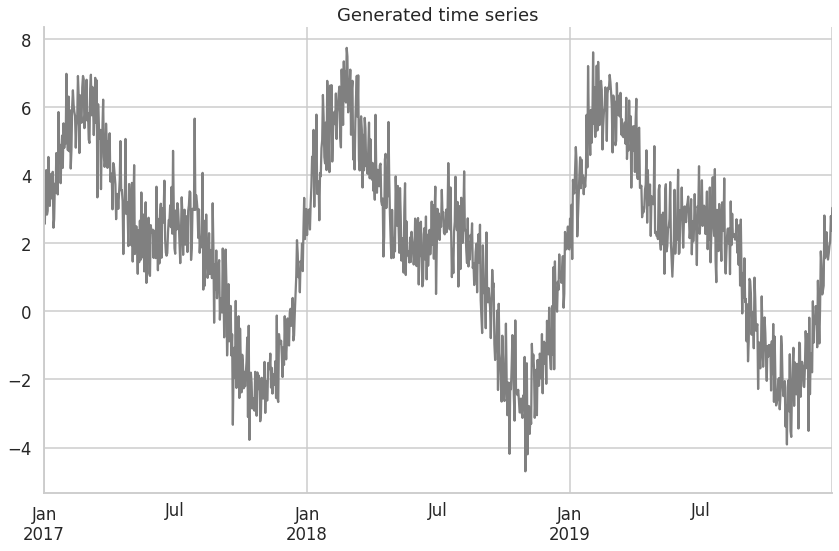

In [98]:
# 난수 생성을 위한 시드 설정
np.random.seed(42)

# 2017년부터 2019년까지의 날짜 범위 생성
range_of_dates = pd.date_range(start="2017-01-01", 
                               end="2019-12-31")
# 날짜를 인덱스로 하는 데이터프레임 생성
X = pd.DataFrame(index=range_of_dates)

# 날짜 관련 특성 추가
X["day_nr"] = range(len(X))  # 연속된 일 번호
X["day_of_year"] = X.index.day_of_year  # 연중 일 번호

# 두 개의 사인 신호 생성
signal_1 = 2 + 3 * np.sin(X["day_nr"] / 365 * 2 * np.pi)
signal_2 = 2 * np.sin(X["day_nr"] / 365 * 4 * np.pi + 365/2)

# 무작위 노이즈 생성
noise = np.random.normal(0, 0.81, len(X))

# 최종 시계열 생성 (신호 + 노이즈)
y = signal_1 + signal_2 + noise
y.name = "y"

# 생성된 시계열 플롯
y.plot(title="Generated time series")

# 그래프 레이아웃 조정
plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_10")  # 그림 저장 (주석 처리됨)

Figure 7.10: The generated time series with repeating patterns

In [99]:
X

,day_nr,day_of_year
2017-01-01,0,1
2017-01-02,1,2
2017-01-03,2,3
2017-01-04,3,4
2017-01-05,4,5
...,...,...
2019-12-27,1090,361
2019-12-28,1091,362
2019-12-29,1092,363
2019-12-30,1093,364


3. Store the time series in a new DataFrame:

**3단계에서**, 우리는 생성된 시계열을 별도의 데이터프레임에 저장했습니다. 이는 모델의 예측값을 해당 데이터프레임에 저장하기 위해 수행했습니다.

In [100]:
# 시계열 데이터를 데이터프레임으로 변환
results_df = y.to_frame()

# 열 이름을 'y_true'로 설정
results_df.columns = ["y_true"]

# 데이터프레임의 처음 5행 출력
results_df.head()

,y_true
2017-01-01,2.969692
2017-01-02,2.572678
2017-01-03,3.325853
2017-01-04,4.150575
2017-01-05,2.842004


4. Encode the month information as dummies:

**4단계에서**, 우리는 `pd.get_dummies` 메서드를 사용하여 월(month) 더미 변수를 생성했습니다. 이 접근 방식에 대한 자세한 내용은 이전 레시피를 참조하십시오.

In [101]:
# 월별 더미 변수 생성
X_1 = pd.get_dummies(
    X.index.month, drop_first=True, prefix="month"
)

# 인덱스를 원본 데이터와 동일하게 설정
X_1.index = X.index

# 생성된 더미 변수 데이터프레임 출력
X_1

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2017-01-01,0,0,0,0,0,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0
2017-01-03,0,0,0,0,0,0,0,0,0,0,0
2017-01-04,0,0,0,0,0,0,0,0,0,0,0
2017-01-05,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0,0,0,0,0,0,0,0,0,0,1
2019-12-28,0,0,0,0,0,0,0,0,0,0,1
2019-12-29,0,0,0,0,0,0,0,0,0,0,1
2019-12-30,0,0,0,0,0,0,0,0,0,0,1


Figure 7.11: Preview of the dummy-encoded month features

5. Fit a linear regression model and plot the in-sample prediction:

**5단계에서**, 우리는 피처에 선형 회귀 모델을 학습 시키고, 학습 시킨 모델의 `predict` 메서드를 사용하여 예측된 값을 얻었습니다. 예측을 위해서는 학습에 사용된 동일한 데이터셋을 사용했습니다.

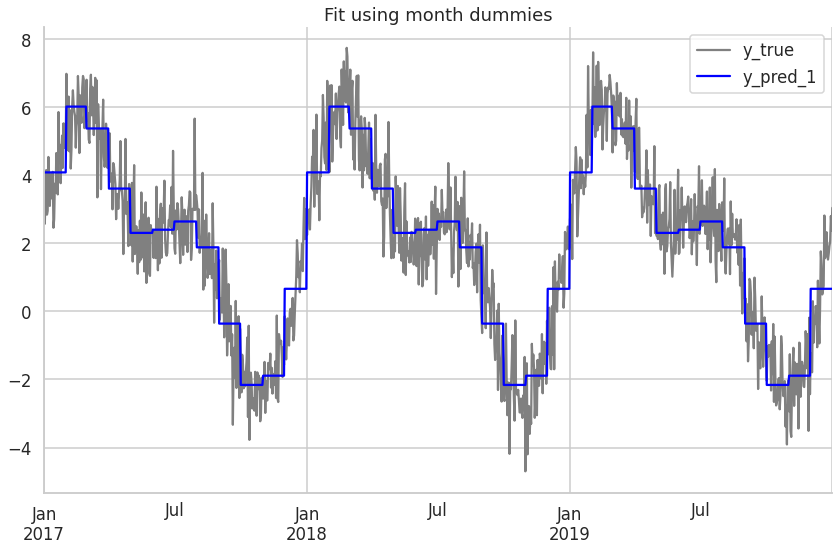

In [102]:
# 월별 더미 변수를 사용하여 선형 회귀 모델 학습
model_1 = LinearRegression().fit(X_1, y)

# 학습된 모델을 사용하여 예측 수행
results_df["y_pred_1"] = model_1.predict(X_1)

# 실제 값과 예측 값을 그래프로 시각화
(
    results_df[["y_true", "y_pred_1"]]
    .plot(title="Fit using month dummies")
)

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 테두리 제거
sns.despine()

# 그래프 저장 (현재 주석 처리됨)
# plt.savefig("images/figure_7_12")

Figure 7.12: The fit obtained using linear regression with the month dummies

우리는 월(month) 특성의 12개의 고유 값에 해당하는 단계별 패턴을 명확히 볼 수 있습니다. 맞춤선의 들쭉날쭉한 모습은 더미 특성의 불연속성으로 인해 발생한 것입니다. 다른 접근 방식을 통해 우리는 이 문제를 해결하려고 합니다.

6. Define functions used for creating the cyclical encoding:

**6단계에서**, 우리는 사인 및 코사인 함수를 사용한 주기적 인코딩을 얻기 위한 함수를 정의했습니다. 두 개의 별도 함수를 만들었지만, 이는 선호에 따른 것이며, 두 피처를 한 번에 만들 수 있는 단일 함수를 만들 수도 있었습니다. 함수의 `period` 인수는 사용할 수 있는 주기의 수에 해당합니다. 예를 들어, 월(month) 인코딩을 할 때는 12를 사용하고, 일(day) 인코딩을 할 때는 365 또는 366을 사용합니다.

> 여기서 `sin_transformer`와 `cos_transformer` 함수는 주기적 특성을 사인 및 코사인 변환을 통해 인코딩하는데, `FunctionTransformer`를 사용하면 이 변환을 `scikit-learn` 파이프라인에 쉽게 통합할 수 있습니다.

>주기적 특성을 인코딩하기 위해 사용하는 삼각함수 공식은 다음과 같습니다:
>- **사인 변환**: $ \sin\left(\frac{2\pi x}{\text{period}}\right) $
>- **코사인 변환**: $ \cos\left(\frac{2\pi x}{\text{period}}\right) $
>여기서:
>- $ x $는 주기적 특성의 값 (예: 월, 요일, 시간 등)
>- $ \text{period} $는 주기의 길이 (예: 월의 경우 12, 요일의 경우 7, 시간의 경우 24)

> 이러한 변환을 사용하는 이유는 주기적 특성의 연속성을 유지하기 위해서입니다. 예를 들어, 월(month) 특성에서 12월과 1월은 연속적이어야 하지만, 단순한 정수 인코딩에서는 이 연속성이 유지되지 않습니다. 사인과 코사인 변환을 사용하면 다음과 같은 이점이 있습니다:


In [103]:
# 주기적 특성을 사인 함수로 변환하는 함수
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

# 주기적 특성을 코사인 함수로 변환하는 함수  
def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

7. Encode the month and day information using cyclical encoding:

**7단계에서**, 우리는 주기적 인코딩을 사용하여 월(month)과 일(day) 정보를 인코딩했습니다. 우리는 이미 `day_of_year` 열을 가지고 있었기 때문에 `DatetimeIndex`에서 월 번호를 추출하기만 하면 되었습니다. 그런 다음 주기적 인코딩이 적용된 네 개의 열을 생성했습니다.

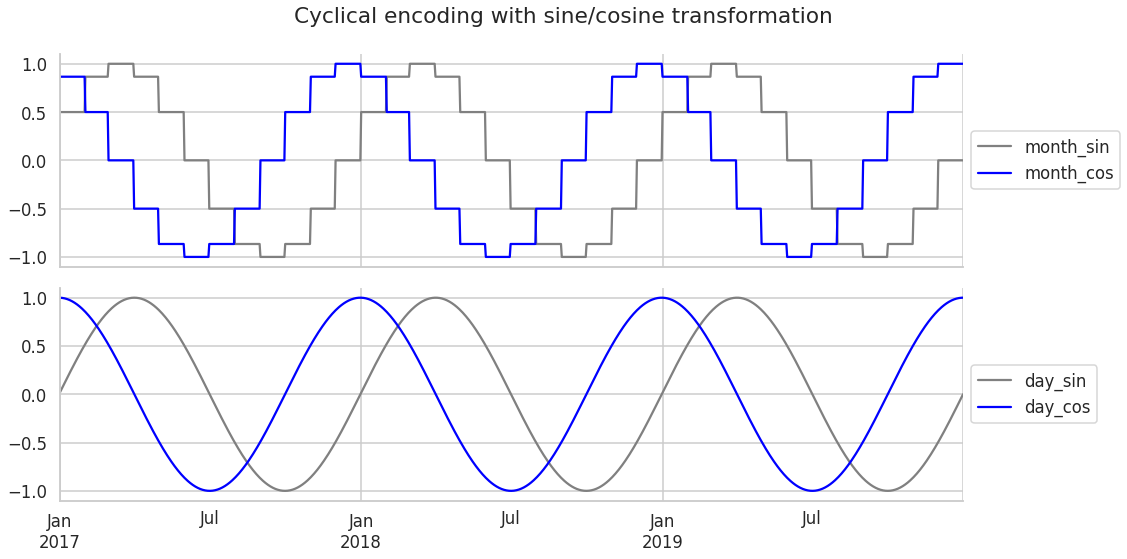

In [104]:
# X_2에 X를 복사
X_2 = X.copy()

# X_2에 월 정보 추가
X_2["month"] = X_2.index.month

# 월에 대한 사인, 코사인 변환 적용
X_2["month_sin"] = sin_transformer(12).fit_transform(X_2)["month"]
X_2["month_cos"] = cos_transformer(12).fit_transform(X_2)["month"]

# 일에 대한 사인, 코사인 변환 적용
X_2["day_sin"] = (
    sin_transformer(365).fit_transform(X_2)["day_of_year"]
)
X_2["day_cos"] = (
    cos_transformer(365).fit_transform(X_2)["day_of_year"]
)

# 그래프 생성
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16,8))

# 월 데이터 플롯
X_2[["month_sin", "month_cos"]].plot(ax=ax[0])
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))

# 일 데이터 플롯
X_2[["day_sin", "day_cos"]].plot(ax=ax[1])
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

# 그래프 제목 설정
plt.suptitle("Cyclical encoding with sine/cosine transformation")

# 그래프 레이아웃 조정
plt.tight_layout()
sns.despine()

# 그래프 저장 (현재 주석 처리됨)
# plt.savefig("images/figure_7_13")

Figure 7.13: Cyclical encoding with sine/cosine transformation

**그림 7.13**에서 두 가지 통찰을 얻을 수 있습니다:

- 월(month)을 인코딩에 사용할 때 곡선이 단계적(step-wise) 형태를 띱니다. 일별 주기를 사용할 때는 곡선이 훨씬 부드러워집니다.
- 그래프는 두 개의 곡선을 사용하는 필요성을 보여줍니다. 곡선은 반복적(주기적) 패턴을 가지고 있기 때문에, 하나의 연도에 대해 수평선을 그리면 두 개의 교차점이 발생할 수 있습니다. 따라서 하나의 곡선만으로는 모델이 관측치의 시간 지점을 이해하기에 충분하지 않을 수 있습니다. 두 개의 곡선을 사용하면 이런 문제가 발생하지 않습니다.

이 변환을 사용해 얻은 주기적 표현을 명확히 보기 위해, 특정 연도에 대해 사인(sine) 및 코사인(cosine) 값을 산점도로 플로팅할 수 있습니다.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


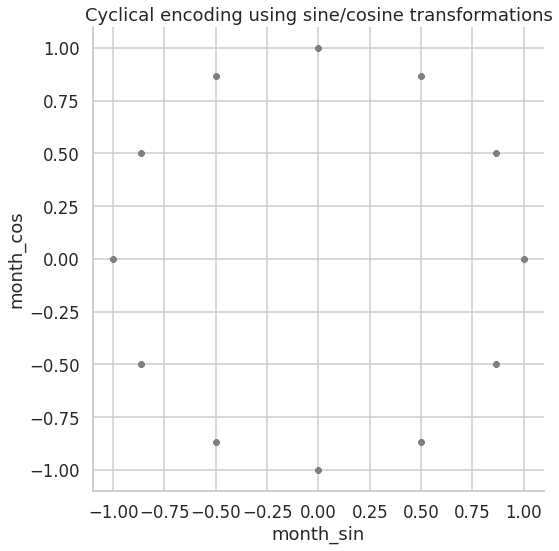

In [105]:
# 2017년 데이터만 선택하여 월별 사인/코사인 값의 산점도 그리기
(
    X_2[X_2.index.year == 2017]
    .plot(
        kind="scatter", 
        x="month_sin",  # x축: 월의 사인 값
        y="month_cos",  # y축: 월의 코사인 값
        figsize=(8, 8),  # 그래프 크기 설정
        title="Cyclical encoding using sine/cosine transformations"  # 그래프 제목
    )
)

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 테두리 제거
sns.despine()

# 그래프 저장 (현재 주석 처리됨)
# plt.savefig("images/figure_7_14")

Figure 7.14: The cyclical representation of time

**그림 7.14**에서 볼 수 있듯이, 중복되는 값이 없습니다. 따라서 두 곡선을 사용하여 주어진 관측치의 시간 지점을 식별할 수 있습니다.

8. Fit a model using the daily sine/cosine features:

**8단계에서**, 우리는 연도의 일(day of year) 인코딩을 제외한 모든 열을 제거했습니다. 그런 다음 선형 회귀 모델을 맞추고, 맞춰진 값을 계산하고, 결과를 플로팅했습니다.

주기적 인코딩에는 잠재적으로 중요한 단점이 있습니다. 특히 트리 기반 모델을 사용할 때 분명히 드러납니다. 트리 기반 모델은 설계상 단일 피처를 기준으로 분할을 생성합니다. 앞서 설명했듯이, 사인/코사인 피처는 시간을 올바르게 식별하기 위해 동시에 고려되어야 합니다.

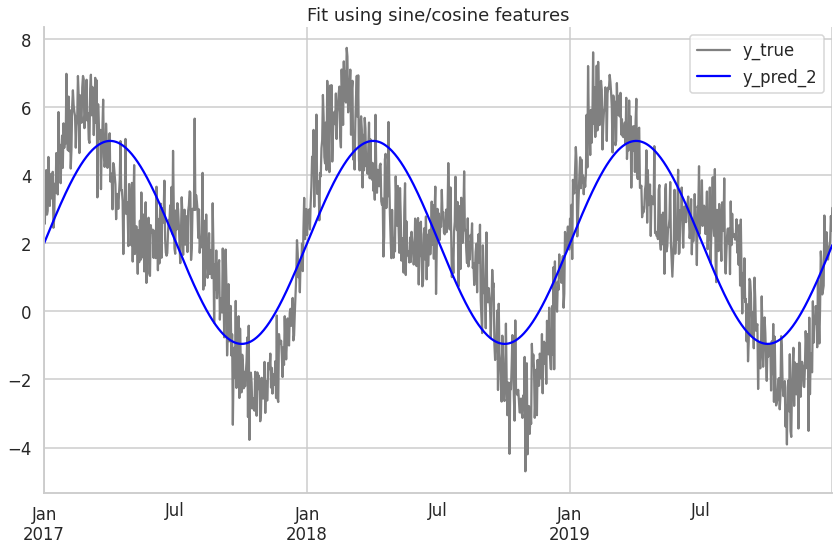

In [110]:
# 사인/코사인 특성만 선택
X_2 = X_2[["day_sin", "day_cos"]]

# 선형 회귀 모델 학습
model_2 = LinearRegression().fit(X_2, y)

# 예측 수행
results_df["y_pred_2"] = model_2.predict(X_2)

# 실제값과 예측값 플로팅
(
    results_df[["y_true", "y_pred_2"]]
    .plot(title="Fit using sine/cosine features")
)

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 테두리 제거
sns.despine()

# 그래프 저장 (현재 주석 처리됨)
# plt.savefig("images/figure_7_15")

Figure 7.15: The fit obtained using linear regression with the cyclical features

9. Create features using the radial basis functions:

**9단계에서**, 우리는 `RepeatingBasisFunction` 클래스를 인스턴스화했습니다. 이는 `scikit-learn`의 변환기(transformer)로 작동합니다. 우리는 `day_of_year` 열을 기반으로 12개의 RBF 곡선을 원한다고 지정했습니다(샘플에 윤년은 포함되지 않음). 추가로, `remainder="drop"`으로 지정하여, 변환 전에 입력 데이터프레임에 있던 나머지 열을 삭제했습니다. 또는 값을 `"passthrough"`로 지정하여 기존 피처와 새로운 피처를 모두 유지할 수도 있었습니다.

여기서 중요한 두 가지 주요 하이퍼파라미터가 있으며, 이는 방사 기저 함수(Radial Basis Functions, RBF)를 사용할 때 튜닝할 수 있습니다:
- **n_periods**: 방사 기저 함수의 개수.
- **width**: 이 하이퍼파라미터는 RBF로 생성된 종곡선(bell curve)의 모양을 결정합니다.

우리는 그리드 서치(grid search)와 같은 방법을 사용하여 주어진 데이터셋에 대한 최적의 하이퍼파라미터 값을 식별할 수 있습니다. 그리드 서치 절차에 대한 자세한 내용은 **Chapter 13, Applied Machine Learning: Identifying Credit Default**를 참조하십시오.

In [107]:
# RepeatingBasisFunction 객체 생성
# n_periods=12: 12개의 RBF 곡선 생성
# column="day_of_year": 'day_of_year' 열을 기반으로 RBF 생성
# input_range=(1,365): 입력 범위를 1일부터 365일로 설정
# remainder="drop": 변환 후 원본 열 삭제
rbf = RepeatingBasisFunction(n_periods=12,
                             column="day_of_year",
                             input_range=(1,365),
                             remainder="drop")

# RBF 객체를 데이터에 맞춤
rbf.fit(X)

# 원본 데이터를 RBF 특성으로 변환하고 새로운 데이터프레임 생성
# 인덱스는 원본 데이터의 인덱스를 유지
X_3 = pd.DataFrame(index=X.index, 
                   data=rbf.transform(X))

In [111]:
X_3.head()

,0,1,2,3,4,5,6,7,8,9,10,11
2017-01-01,1.000000,0.367879,0.018316,0.000123,1.125352e-07,1.388794e-11,2.319523e-16,1.388794e-11,1.125352e-07,0.000123,0.018316,0.367879
2017-01-02,0.998914,0.392526,0.020875,0.000150,1.463375e-07,1.929034e-11,3.441402e-16,9.976816e-12,8.635293e-08,0.000101,0.016035,0.344032
2017-01-03,0.995662,0.417914,0.023740,0.000183,1.898798e-07,2.673609e-11,5.094813e-16,7.151579e-12,6.611833e-08,0.000083,0.014009,0.321032
2017-01-04,0.990266,0.443978,0.026939,0.000221,2.458430e-07,3.697532e-11,7.526222e-16,5.115262e-12,5.051527e-08,0.000068,0.012211,0.298919
2017-01-05,0.982761,0.470644,0.030503,0.000268,3.176092e-07,5.102487e-11,1.109384e-15,3.650816e-12,3.851052e-08,0.000055,0.010622,0.277725


In [112]:
X_3.shape

(1095, 12)

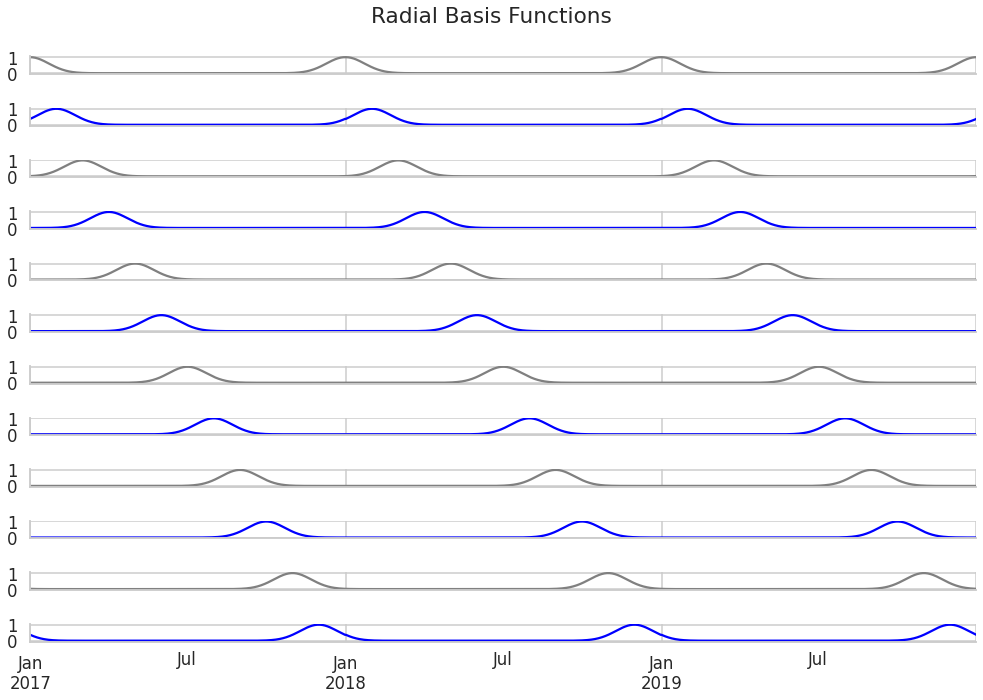

In [108]:
X_3.plot(subplots=True, sharex=True, 
         title="Radial Basis Functions", 
         legend=False, figsize=(14, 10))

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_16")

Figure 7.16: Visualization of the features created using the radial basis function

**그림 7.16**에서는 방사 기저 함수와 일(day) 번호를 입력으로 사용하여 만든 12개의 곡선을 보여줍니다. 각 곡선은 우리가 연중 특정 날짜와 얼마나 가까운지를 나타냅니다. 예를 들어, 첫 번째 곡선은 1월 1일과의 거리를 측정합니다. 이렇게 하면 매년 1월 1일에 피크가 나타나고, 그 날짜에서 멀어질수록 대칭적으로 감소하는 모습을 관찰할 수 있습니다.

기저 함수는 입력 범위에 고르게 분포되어 있습니다. 우리는 12개의 곡선을 만들었는데, 이는 방사 기저 함수가 월(month)을 닮도록 만들고 싶었기 때문입니다. 이렇게 하면 각 함수가 해당 월의 첫날과의 대략적인 거리를 나타냅니다. 거리는 대략적인 값이며, 각 월의 길이가 다르기 때문입니다.

방사 기저 함수(Radial Basis Function, RBF)
- **방사 기저 함수(Radial Basis Function, RBF)** 는 머신러닝에서 사용되는 함수로, 주로 **거리를 기준으로 값을 계산** 하는 함수입니다. 
- 방사 기저 함수는 특정 중심점(중심 위치)에서 입력 값과의 거리에 따라 함숫값이 변합니다. 
- **거리가 가까울수록 큰 값**을 반환하고, **거리가 멀어질수록 작은 값** 을 반환하는 형태입니다. 
- 이러한 특성 때문에 **데이터 간의 유사도** 를 계산하거나, 비선형 문제를 처리할 때 주로 사용됩니다.

방사 기저 함수의 원리
- **중심(center)**: 각 방사 기저 함수에는 고정된 중심점이 있습니다. 입력 값이 이 중심점에 가까울수록 함수의 출력값이 커지고, 멀어질수록 출력값이 작아집니다.
- **거리에 따른 감소**: 방사 기저 함수는 일반적으로 거리에 따라 대칭적으로 감소합니다. 거리가 가까우면 출력값이 크고, 멀면 거의 0에 가까워지죠.
- **대표적인 함수 형태**: 가장 흔한 RBF는 **가우시안 함수** 입니다. 가우시안 함수는 정규 분포의 종 모양을 그리는 함수로, 특정 중심에서 거리가 멀어질수록 그 값이 지수적으로 감소하는 특성을 가집니다. 

$ \phi(x) = \exp\left(-\frac{{\|x - c\|^2}}{{2\sigma^2}}\right) $

여기서:
- $x$는 입력 값,
- $c$는 중심점,
- $\sigma$는 함수의 폭(width)을 조절하는 하이퍼파라미터입니다. 

이 수식은 **입력 값 $x$** 가 **중심점 $c$** 에 가까울수록 값이 커지고, 멀어질수록 값이 지수적으로 감소하는 것을 보여줍니다.

방사 기저 함수의 적용
- 1. **거리 기반 함수**: 입력 값과 중심점 간의 거리에 따라 출력값이 달라집니다. 주로 입력 값이 중심점에 가까운지 먼지를 구별할 때 유용합니다.
- 2. **피처 변환**: 시계열 데이터나 위치 데이터를 다룰 때, 데이터를 중심점과의 거리에 따라 변환하여 더 나은 패턴을 추출하는 데 사용됩니다.
- 3. **비선형 문제 해결**: 선형 회귀 모델이나 SVM(Support Vector Machine)에서 **비선형 데이터를 선형적으로 분리** 하기 위해 RBF를 커널로 사용하는 방식이 있습니다.

그림 7.16 설명
- 그림 7.16에서는 **방사 기저 함수(RBF)** 를 사용해 **특정 날짜와의 거리를 측정** 하는 12개의 곡선을 생성했습니다. 
- 각 곡선은 1년 중 한 달을 나타내며, 예를 들어 첫 번째 곡선은 **1월 1일과의 거리** 를 측정합니다. 
- 시간이 1월 1일에 가까울수록 해당 곡선의 값은 커지고, 1월 1일에서 멀어질수록 값은 점점 작아지며 대칭적으로 감소합니다. 이를 통해 모델은 **특정 시점이 연도에서 얼마나 가까운지** 를 파악할 수 있습니다.

방사 기저 함수는 **입력 값(날짜)** 이 특정 중심점(월의 첫날)과의 거리에 따라 피처를 생성해, 시계열 데이터를 모델에 더 효과적으로 입력할 수 있도록 도와줍니다.

10. Fit a model using the RBF features:

**10단계에서**, 우리는 다시 한 번 모델을 학습하고, 이번에는 RBF 피처를 입력으로 사용했습니다.

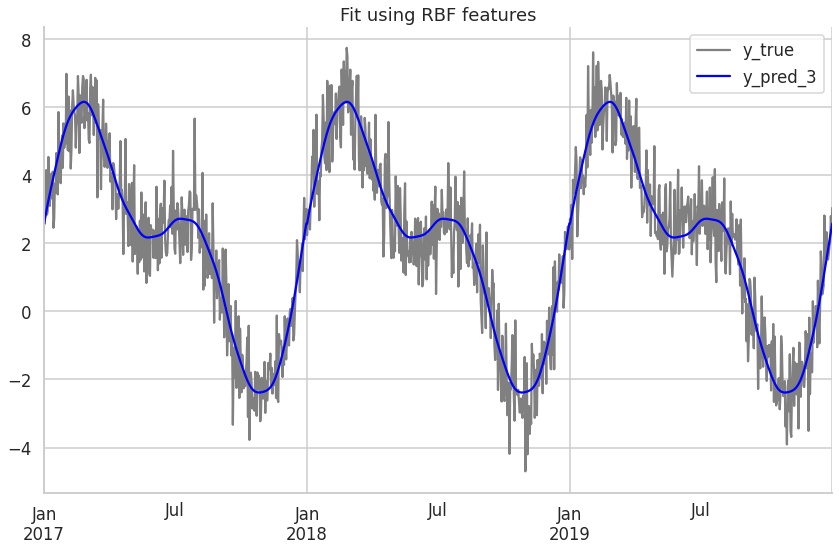

In [109]:
# RBF 특성을 사용하여 선형 회귀 모델 학습
model_3 = LinearRegression().fit(X_3, y)

# 학습된 모델을 사용하여 예측 수행
results_df["y_pred_3"] = model_3.predict(X_3)

# 실제 값과 예측 값을 그래프로 시각화
(
    results_df[["y_true", "y_pred_3"]]
    .plot(title="Fit using RBF features")
)

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 테두리 제거
sns.despine()

# 그래프 저장 (주석 처리됨)
# plt.savefig("images/figure_7_17")

Figure 7.17: The fit obtained using linear regression with the RBF-encoded features

RBF 특성을 사용한 결과가 지금까지 가장 좋은 적합을 보였다는 것을 분명히 알 수 있습니다.

### There's more

이 레시피에서는 시간과 관련된 피처를 수동으로 만드는 방법을 보여주었습니다. 물론, 우리가 만든 피처들은 만들 수 있는 수천 가지 피처 중 일부에 불과합니다. 다행히도 피처 엔지니어링/추출 과정을 쉽게 해주는 Python 라이브러리들이 있습니다.

그 중 두 가지를 소개하겠습니다. 첫 번째 접근법은 **sktime** 라이브러리에서 제공하는 방법으로, 시계열 데이터를 위한 **scikit-learn**과 동등한 포괄적인 라이브러리입니다. 두 번째 접근법은 **tsfresh**라는 라이브러리를 이용합니다. 이 라이브러리를 사용하면 몇 줄의 코드만으로 수백 또는 수천 개의 피처를 자동으로 생성할 수 있습니다. 내부적으로는 통계, 시계열 분석, 물리학, 신호 처리에서 확립된 알고리즘들을 조합하여 사용합니다.

다음 단계에서 두 접근법을 모두 사용하는 방법을 보여드리겠습니다.

1. Import the libraries:

In [113]:
# sktime 라이브러리에서 날짜/시간 관련 특성 추출을 위한 모듈 임포트
from sktime.transformations.series.date import DateTimeFeatures

# tsfresh 라이브러리에서 특성 추출 관련 모듈들 임포트
from tsfresh import extract_features
from tsfresh.feature_extraction import settings
from tsfresh.utilities.dataframe_functions import roll_time_series

2. Extract the datetime-features using `sktime`:

In [86]:
# DateTimeFeatures 객체 생성
# 일별 빈도('D')로 포괄적인 특성 추출
dt_features = DateTimeFeatures(
    ts_freq="D", feature_scope="comprehensive"
)

# 특성 추출 및 변환
features_df_1 = dt_features.fit_transform(y)

# 결과 데이터프레임의 처음 5행 출력
features_df_1.head()

,y,year,quarter_of_year,month_of_year,week_of_year,day_of_year,month_of_quarter,week_of_quarter,day_of_quarter,week_of_month,day_of_month,day_of_week
2017-01-01,2.969692,2017,1,1,52,1,1,1,1,1,1,6
2017-01-02,2.572678,2017,1,1,1,2,1,2,2,1,2,0
2017-01-03,3.325853,2017,1,1,1,3,1,2,3,1,3,1
2017-01-04,4.150575,2017,1,1,1,4,1,2,4,1,4,2
2017-01-05,2.842004,2017,1,1,1,5,1,2,5,1,5,3


Figure 7.18: Preview of the DataFrame with the extracted features

그림에서 추출된 피처들을 볼 수 있습니다. 우리가 사용하고자 하는 머신러닝 알고리즘에 따라, 예를 들어 더미 변수를 사용하여 이러한 피처를 추가로 인코딩할 수 있습니다. `DateTimeFeatures` 클래스를 인스턴스화할 때 `feature_scope` 인수를 제공했습니다. 이 경우, 'comprehensive' 피처 세트를 생성했습니다. 또한, "minimal" 또는 "efficient" 세트를 선택할 수도 있습니다.

추출된 피처들은 **pandas**의 `DatetimeIndex`를 기반으로 합니다. 해당 인덱스에서 추출할 수 있는 모든 피처 목록에 대한 자세한 내용은 **pandas** 문서를 참조하십시오.

3. Prepare the dataset for feature extraction with `tsfresh`:

피처 추출 알고리즘을 사용하려면, 시계열 데이터 자체를 제외하고, 우리의 DataFrame에는 날짜(또는 시간의 순차적 인코딩)를 포함한 열과 ID 열이 있어야 합니다. ID 열이 필요한 이유는 DataFrame에 여러 개의 시계열이 있을 수 있기 때문입니다(긴 형식으로). 예를 들어, S&P 500 지수에 속한 모든 종목의 일별 주가를 포함하는 DataFrame을 가질 수 있습니다.

In [87]:
# y를 DataFrame으로 변환하고 인덱스를 열로 추가
df = y.to_frame().reset_index(drop=False)

# 열 이름 지정
df.columns = ["date", "y"]

# 시리즈 ID 열 추가
df["series_id"] = "a"

# 결과 DataFrame 출력
df

,date,y,series_id
0,2017-01-01,2.969692,a
1,2017-01-02,2.572678,a
2,2017-01-03,3.325853,a
3,2017-01-04,4.150575,a
4,2017-01-05,2.842004,a
...,...,...,...
1090,2019-12-27,1.914564,a
1091,2019-12-28,2.062146,a
1092,2019-12-29,2.801118,a
1093,2019-12-30,2.372868,a


4. Create a rolled-up DataFrame for feature extraction:

우리는 다음 목표를 달성하기 위해 슬라이딩 윈도우를 사용하여 DataFrame을 롤업했습니다:

- 시계열 예측을 위한 의미 있는 집계 피처를 계산하기 위해. 예를 들어, 지난 10일 동안의 최소/최대 값이나 20일 단순 이동 평균(SMA) 같은 기술 지표를 계산할 수 있습니다. 이러한 집계 계산은 단일 관측치로는 의미가 없으므로 항상 시간 창(window)을 포함합니다.
- 모든 사용 가능한 시점에 대한 피처를 추출하여 쉽게 머신러닝 예측 모델에 사용할 수 있도록. 이렇게 하면 기본적으로 전체 학습 데이터셋을 한 번에 생성하는 셈입니다.

이를 위해, 우리는 `roll_time_series` 함수를 사용하여 롤업된 DataFrame을 생성했고, 이 DataFrame은 이후 피처 추출에 사용될 것입니다. 우리는 최소 및 최대 윈도우 크기를 지정했습니다. 이 경우, 7일 미만의 윈도우는 버리고 최대 30일까지 사용할 것입니다.

In [88]:
# 시계열 데이터를 롤링하여 특성 추출을 위한 DataFrame 생성
# df: 원본 데이터프레임
# column_id: 시리즈 식별자 열
# column_sort: 정렬 기준이 되는 날짜 열
# max_timeshift: 최대 시간 이동 (30일)
# min_timeshift: 최소 시간 이동 (7일)
df_rolled = roll_time_series(
    df, column_id="series_id", column_sort="date",
    max_timeshift=30, min_timeshift=7
).drop(columns=["series_id"])  # 'series_id' 열 제거

# 롤링된 DataFrame 출력
df_rolled

Rolling: 100%|██████████| 20/20 [00:00<00:00, 36.63it/s]


,date,y,id
0,2017-01-01,2.969692,"(a, 2017-01-08 00:00:00)"
1,2017-01-02,2.572678,"(a, 2017-01-08 00:00:00)"
2,2017-01-03,3.325853,"(a, 2017-01-08 00:00:00)"
3,2017-01-04,4.150575,"(a, 2017-01-08 00:00:00)"
4,2017-01-05,2.842004,"(a, 2017-01-08 00:00:00)"
...,...,...,...
33447,2019-12-27,1.914564,"(a, 2019-12-31 00:00:00)"
33448,2019-12-28,2.062146,"(a, 2019-12-31 00:00:00)"
33449,2019-12-29,2.801118,"(a, 2019-12-31 00:00:00)"
33450,2019-12-30,2.372868,"(a, 2019-12-31 00:00:00)"


Figure 7.19: Preview of a rolled-up DataFrame

**그림 7.19**에서 새로 추가된 `id` 열을 볼 수 있습니다. 여러 관측치가 동일한 `id` 값을 가지고 있는 것을 볼 수 있습니다. 예를 들어, **a, 2017-01-08 00:00:00** 값은 2017-01-08까지 마지막 30일을 포함하는 시점의 시계열에서 피처를 추출할 때 사용됩니다(이 ID는 이전 단계에서 인위적으로 생성했습니다). 롤업된 DataFrame을 준비한 후, 우리는 피처를 추출할 수 있습니다.

5. Extract the minimal set of features:

In [89]:
# 최소한의 특성 추출 설정 생성
settings_minimal = settings.MinimalFCParameters() 

# 생성된 설정 출력
settings_minimal

{'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'maximum': None,
 'minimum': None}

사전에 생성될 모든 피처를 확인할 수 있습니다. 
- **None** 값은 해당 피처에 추가적인 하이퍼파라미터가 없음을 의미합니다. 
- 우리는 최소한의 피처 세트를 추출하기로 했는데, 다른 세트들은 상당한 시간이 걸리기 때문입니다. 
- 대신, **settings.EfficientFCParameters**나 **settings.ComprehensiveFCParameters**를 사용하여 수백 또는 수천 개의 피처를 생성할 수도 있습니다.

In [90]:
# 특성 추출
# df_rolled: 롤링된 데이터프레임
# column_id: 시계열 식별자 열
# column_sort: 정렬 기준 열
# default_fc_parameters: 기본 특성 계산 파라미터
features_df_2 = extract_features(
    df_rolled, column_id="id", 
    column_sort="date", 
    default_fc_parameters=settings_minimal
)

Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 78.12it/s]


In [114]:
features_df_2

,y__sum_values,y__median,y__mean,y__length,y__standard_deviation,y__variance,y__maximum,y__minimum
last_date,,,,,,,,
2017-01-08,27.344582,3.147773,3.418073,8.0,0.669595,0.448357,4.537116,2.572678
2017-01-09,30.443686,3.099104,3.382632,9.0,0.639209,0.408588,4.537116,2.572678
2017-01-10,34.471211,3.212478,3.447121,10.0,0.636521,0.405159,4.537116,2.572678
2017-01-11,37.791096,3.319885,3.435554,11.0,0.608001,0.369665,4.537116,2.572678
2017-01-12,41.214759,3.322869,3.434563,12.0,0.582125,0.338870,4.537116,2.572678
...,...,...,...,...,...,...,...,...
2019-12-27,6.536710,0.155974,0.210862,31.0,1.459941,2.131428,2.816481,-3.509843
2019-12-28,9.261894,0.297687,0.298771,31.0,1.486480,2.209621,2.816481,-3.509843
2019-12-29,15.572855,0.497914,0.502350,31.0,1.379220,1.902248,2.816481,-2.433608


6. Clean up the index and inspect the features:

In [92]:
# features_df_2의 인덱스를 재설정합니다.
# 각 인덱스 튜플의 두 번째 요소(날짜)를 새 인덱스로 사용합니다.
features_df_2 = (
    features_df_2
    .set_index(
        features_df_2.index.map(lambda x: x[1]), drop=True
    )
)

# 새 인덱스의 이름을 'last_date'로 지정합니다.
features_df_2.index.name = "last_date"

# 처음 25개 행을 표시하고 소수점 4자리까지 반올림합니다.
features_df_2.head(25).round(4)

,y__sum_values,y__median,y__mean,y__length,y__standard_deviation,y__variance,y__maximum,y__minimum
last_date,,,,,,,,
2017-01-08,27.3446,3.1478,3.4181,8.0,0.6696,0.4484,4.5371,2.5727
2017-01-09,30.4437,3.0991,3.3826,9.0,0.6392,0.4086,4.5371,2.5727
2017-01-10,34.4712,3.2125,3.4471,10.0,0.6365,0.4052,4.5371,2.5727
2017-01-11,37.7911,3.3199,3.4356,11.0,0.6080,0.3697,4.5371,2.5727
2017-01-12,41.2148,3.3229,3.4346,12.0,0.5821,0.3389,4.5371,2.5727
2017-01-13,45.3157,3.3259,3.4858,13.0,0.5868,0.3443,4.5371,2.5727
2017-01-14,47.7731,3.3229,3.4124,14.0,0.6244,0.3899,4.5371,2.4575
2017-01-15,50.4837,3.3199,3.3656,15.0,0.6281,0.3945,4.5371,2.4575
2017-01-16,54.2347,3.3229,3.3897,16.0,0.6153,0.3786,4.5371,2.4575


Figure 7.20: Preview of the features generated with tsfresh

**그림 7.20**에서 최소 윈도우 길이는 8이고, 최대 윈도우 길이는 31임을 확인할 수 있습니다. 이는 우리가 최소 크기 7을 사용하려고 했던 의도와 일치하며, 이는 7일 전까지의 데이터와 현재 데이터를 포함하는 것입니다. 최대값에 대해서도 동일하게 적용됩니다.

**sktime**은 또한 **tsfresh**에 대한 래퍼(wrapper)를 제공합니다. 우리는 **sktime**의 **TSFreshFeatureExtractor** 클래스를 사용하여 피처 생성 알고리즘에 접근할 수 있습니다.

또한 **tsfresh**가 제공하는 몇 가지 흥미로운 기능도 언급할 가치가 있습니다:
- 가설 검정을 기반으로 한 피처 선택 알고리즘. 이 라이브러리는 수백 또는 수천 개의 피처를 생성할 수 있으므로, 우리의 사용 사례와 관련된 피처를 선택하는 것이 매우 중요합니다. 이를 위해 **fresh** 알고리즘을 사용하며, 이는 **scalable hypothesis tests에 기반한 피처 추출**을 의미합니다.
- 하나의 로컬 머신에 맞지 않는 대형 데이터셋을 다룰 때 멀티프로세싱을 사용하거나 Spark 또는 Dask 클러스터를 사용하여 피처 생성과 선택을 처리할 수 있습니다.
- **FeatureAugmenter**나 **FeatureSelector**와 같은 변환기(transformer) 클래스를 제공하며, 이를 **scikit-learn** 파이프라인과 함께 사용할 수 있습니다. 파이프라인에 대해서는 **Chapter 13, Applied Machine Learning: Identifying Credit Default**에서 다룹니다.

**tsfresh**는 시계열 데이터의 자동 피처 생성을 위한 라이브러리 중 하나일 뿐입니다. 다른 라이브러리로는 **feature_engine**과 **tsflex**가 있습니다.

## 7.3 Time series forecasting as reduced regression

**회귀 모델을 통한 시계열 예측 (reduced regression)**

지금까지 우리는 주로 시계열 예측 작업을 위해 전용 시계열 모델을 사용했습니다. 반면, 회귀 작업을 해결하는 데 일반적으로 사용되는 다른 알고리즘을 실험해보는 것도 흥미로울 수 있습니다. 이를 통해 우리의 모델 성능을 향상시킬 수 있을지도 모릅니다.

이러한 모델을 사용하는 이유 중 하나는 그 유연성 때문입니다. 예를 들어, 단일 변수 설정을 넘어 다양한 추가 피처로 데이터셋을 풍부하게 만들 수 있습니다. 이전 레시피에서 다룬 피처 엔지니어링 접근법을 활용할 수도 있습니다. 또는, 시계열과 같이 역사적으로 예측 목표와 상관관계가 있다고 증명된 외부 회귀 변수를 추가할 수도 있습니다.

> **참고**: 추가적인 시계열을 외부 회귀 변수로 추가할 때는 해당 시계열 값의 가용성에 주의해야 합니다. 만약 그들의 미래 값을 모른다면, 해당 시계열의 지연된 값이나 예측된 값을 사용해 초기 모델에 다시 피드백할 수 있습니다.

시계열 데이터의 시간 의존성(지연된 시계열 값과 관련됨)을 고려할 때, 회귀 모델을 직접적으로 시계열 예측에 사용할 수 없습니다. 먼저 이러한 시간 데이터를 **지도 학습 문제**로 변환해야 하며, 이때 전통적인 회귀 알고리즘을 적용할 수 있습니다. 이 과정을 **reduction(축소)** 라고 하며, 이는 특정 학습 작업(시계열 예측)을 더 간단한 작업으로 분해한 후 다시 원래 작업에 대한 해결책을 구성하는 과정입니다. 즉, **reduction**은 원래 의도된 목적이 아닌 문제를 해결하기 위해 알고리즘 또는 모델을 사용하는 개념을 의미합니다. **reduced regression**에서는 시계열 예측 작업을 **표 형식의 회귀 문제**로 변환하는 작업을 수행하게 됩니다.

실제로 reduction은 고정 길이 윈도우로 시계열을 분할하는 작업을 사용합니다. 예를 들어, 연속된 1부터 100까지의 숫자로 구성된 시계열을 상상해 보세요. 우리는 길이 5의 슬라이딩 윈도우를 취합니다. 첫 번째 윈도우에는 1부터 4까지의 관측치가 포함되고, 5번째 관측치를 목표값으로 설정합니다. 두 번째 윈도우에서는 2부터 5까지를 피처로 사용하고, 6번째 관측치를 목표값으로 설정합니다. 이러한 모든 윈도우를 서로 쌓으면 전통적인 회귀 알고리즘을 사용하여 예측할 수 있는 표 형식의 데이터가 생성됩니다. **그림 7.21**은 reduction 절차를 설명합니다.

<img src="./image/fig_07_21.png" width=800>

Figure 7.21: Schema of the reduction procedure

또한 **reduced regression**을 사용할 때 고려해야 할 몇 가지 미묘한 차이가 있습니다. 예를 들어, **reduced regression** 모델은 시계열 모델의 전형적인 특성, 즉 **시간** 의 개념을 잃습니다. 그 결과, 이러한 모델은 **추세(trend)** 와 **계절성(seasonality)** 을 처리할 수 없습니다. 따라서 먼저 **추세를 제거(detrend)** 하고 **계절성을 제거(deseasonalize)** 한 후에 **reduction** 을 수행하는 것이 유용할 수 있습니다. 직관적으로 이는 **AR(자기회귀) 항만을 모델링** 하는 것과 유사합니다. 데이터를 먼저 계절성과 추세를 제거하면 더 나은 적합 모델을 찾는 데 도움이 됩니다. 이는 AR 항을 넘어선 추세와 계절성을 고려하지 않기 때문입니다.

이 레시피에서는 미국의 실업률 데이터셋을 사용한 **reduced regression** 절차의 예를 보여줍니다.

### Getting ready

이 레시피에서는 이미 익숙한 미국 실업률 시계열 데이터를 사용하고 있습니다. 간결성을 위해, 데이터를 다운로드하는 단계는 반복하지 않습니다. 관련 코드는 첨부된 노트북에서 확인할 수 있습니다. 레시피의 나머지 부분에서는 다운로드된 데이터가 **`y`** 라는 DataFrame에 있다고 가정합니다.

1. Import the libraries and authenticate:

In [13]:
import pandas as pd
import numpy as np
import nasdaqdatalink
import yfinance as yf
import os
import pandas_datareader.data as web

nasdaqdatalink.ApiConfig.api_key = os.environ["NASDAQ_API_KEY"]

2. Download the monthly US unemployment rate from years 2010-2019:

In [14]:
# y = (
#     nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
#                        start_date="2010-01-01", 
#                        end_date="2019-12-31")
#     .rename(columns={"Value": "unemp_rate"})
# )
# y.index = y.index.to_period(freq="M")

# web.DataReader 사용
y = web.DataReader('UNRATENSA', 'fred', start='2010-01-01', end='2019-12-31')
y = y.rename(columns={'UNRATENSA': 'unemp_rate'})
y.index = y.index.to_period(freq='M')

In [15]:
y

,unemp_rate
DATE,
2010-01,10.6
2010-02,10.4
2010-03,10.2
2010-04,9.5
2010-05,9.3
...,...
2019-08,3.8
2019-09,3.3
2019-10,3.3


### How to do it...

1. Import the libraries:

In [24]:
# 시계열 데이터 시각화를 위한 유틸리티
from sktime.utils.plotting import plot_series

# 시계열 데이터 분할 및 모델 선택을 위한 도구
from sktime.forecasting.model_selection import (
    temporal_train_test_split, ExpandingWindowSplitter
)

# 예측 기간 설정을 위한 클래스
from sktime.forecasting.base import ForecastingHorizon

# 다양한 예측 모델 구성을 위한 도구
from sktime.forecasting.compose import (
    make_reduction, TransformedTargetForecaster, 
    EnsembleForecaster
)

# 예측 성능 평가 지표
from sktime.performance_metrics.forecasting import (
    mean_absolute_percentage_error
)

# 시계열 데이터의 추세 및 계절성 제거를 위한 변환기
from sktime.transformations.series.detrend import (
    Deseasonalizer, Detrender
)

# 다항식 추세 예측기
from sktime.forecasting.trend import PolynomialTrendForecaster

# 모델 평가를 위한 함수
from sktime.forecasting.model_evaluation import evaluate

# 자동 ARIMA 모델
from sktime.forecasting.arima import AutoARIMA

# 랜덤 포레스트 회귀 모델
from sklearn.ensemble import RandomForestRegressor

2. Split the time series into training and tests sets:

- 라이브러리를 가져온 후, 우리는 `temporal_train_test_split` 함수를 사용하여 데이터를 학습 및 테스트 세트로 나누었습니다. 마지막 12개의 관측치(2019년 전체)를 테스트 세트로 남겼습니다. 
- 또한 `plot_series` 함수를 사용하여 시계열을 플로팅했습니다. 이는 여러 시계열을 하나의 플롯에 표시하고 싶을 때 특히 유용합니다.

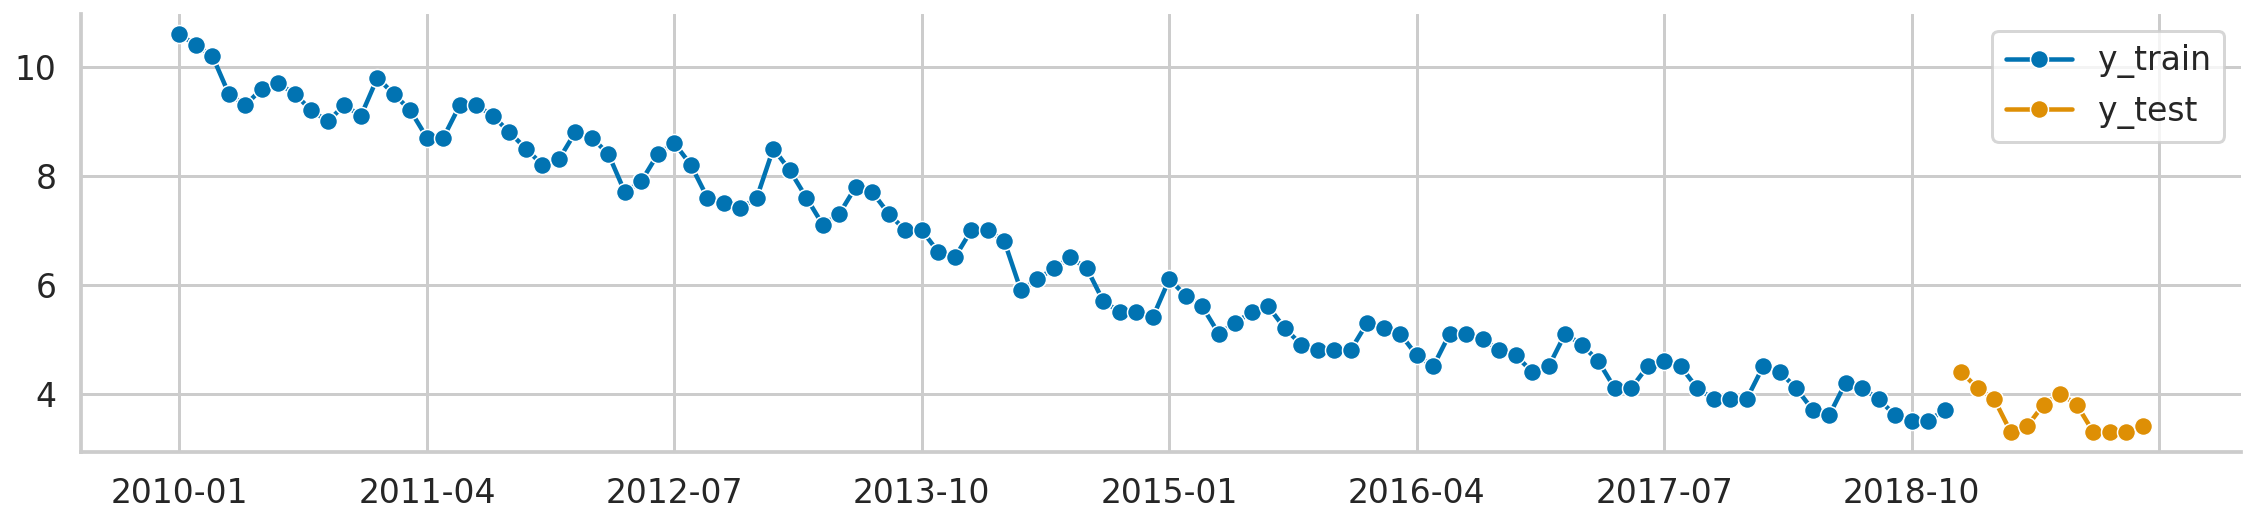

In [25]:
# 시계열 데이터를 학습 세트와 테스트 세트로 분할
# test_size=12는 마지막 12개월(1년)을 테스트 세트로 사용함을 의미
y_train, y_test = temporal_train_test_split(
    y, test_size=12
)

# 학습 세트와 테스트 세트를 시각화
plot_series(
    y_train, y_test, 
    labels=["y_train", "y_test"]
)

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 테두리 제거
sns.despine()

# 그래프를 이미지 파일로 저장 (현재는 주석 처리됨)
# plt.savefig("images/figure_7_22")

Figure 7.22: The time series divided into training and test sets

3. Set the forecast horizon to 12 months:

**3단계에서는** `ForecastingHorizon`을 정의했습니다. 
- **sktime**에서는 예측 구간을 상대적인 값(가장 최신 시점과의 시간 차이를 나타냄) 또는 절대적인 값(특정 시점)을 배열로 설정할 수 있습니다. 
- 우리는 테스트 세트의 인덱스를 제공하고 `is_relative=False`로 설정하여 절대 값을 사용했습니다.

상대적인 예측 구간 값에는 예측하려는 단계 목록이 포함될 수 있으며, 새로운 데이터가 추가될 때마다 이를 재사용하여 롤링 예측을 수행하는 데 매우 유용할 수 있습니다.

In [26]:
# ForecastingHorizon 객체 생성
# y_test.index를 사용하여 절대적인 예측 기간 설정
# is_relative=False로 설정하여 절대 날짜 사용
fh = ForecastingHorizon(y_test.index, is_relative=False)

# 생성된 ForecastingHorizon 객체 출력
fh

ForecastingHorizon(['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12'],
            dtype='period[M]', is_relative=False)

4. Instantiate the reduced regression model, fit it to the data and create predictions:

**4단계에서는**, 학습 데이터에 reduced regression 모델을 맞췄습니다. 이를 위해 `make_reduction` 함수를 사용하고 세 가지 인수를 제공했습니다. 

- 첫 번째로, **`estimator` 인수**는 reduced regression 설정에서 사용하고자 하는 회귀 모델을 나타냅니다. 이 경우, 우리는 **랜덤 포레스트(Random Forest)** 를 선택했습니다(랜덤 포레스트 알고리즘에 대한 더 자세한 내용은 **Chapter 14, Advanced Concepts for Machine Learning Projects** 에서 확인할 수 있습니다). 
- 두 번째로, **`window_length`** 는 reduced regression 작업을 위해 시계열을 표 형식의 데이터로 변환할 때 사용할 과거 관측치의 개수를 나타냅니다. - 
- 마지막으로, **`strategy` 인수**는 다단계 예측을 생성하는 방식을 결정합니다. 우리는 다음 중 하나의 전략을 선택할 수 있습니다:

    - **Direct**: 각 예측 구간마다 별도의 모델을 생성하는 방식입니다. 이 경우, 우리는 12단계를 예측하고 있으므로 12개의 별도 모델을 생성해야 예측을 얻을 수 있습니다.
    - **Recursive**: 단일 한 단계 예측 모델을 맞추는 방식입니다. 그러나 예측을 생성하기 위해, 이전 시점의 출력을 다음 시점의 입력으로 사용합니다. 예를 들어, 두 번째 관측치의 예측을 얻기 위해 첫 번째 관측치의 예측을 사용합니다.
    - **Multioutput**: 이 전략에서는 하나의 모델을 사용하여 전체 예측 구간의 모든 값을 한 번에 예측합니다. 이 전략은 하나의 모델이 전체 예측 순서를 예측할 수 있는 경우에 의존합니다.

reduced regression 모델을 정의한 후, 우리는 **`fit`** 메서드를 사용하여 학습 데이터에 모델을 맞추고, **`predict`** 메서드를 사용하여 예측을 얻었습니다. 후자의 경우, 우리는 예측을 얻고자 하는 단계 목록/배열을 제공해야 했습니다.

In [27]:
# RandomForestRegressor 객체 생성 (랜덤 시드 42 설정)
regressor = RandomForestRegressor(random_state=42)

# make_reduction을 사용하여 시계열 예측 모델 생성
# estimator: RandomForest 회귀 모델 사용
# strategy: 재귀적 예측 전략 사용
# window_length: 12개월의 과거 데이터 사용
rf_forecaster = make_reduction(
    estimator=regressor, 
    window_length=12,
    strategy="recursive"
)

# 학습 데이터로 모델 학습
rf_forecaster.fit(y_train)

# 예측 수행
y_pred_1 = rf_forecaster.predict(fh)

5. Evaluate the performance of the forecasts:

**5단계에서는**, MAPE 점수를 계산하고 예측값을 실제값과 비교하여 예측을 평가했습니다. 오차를 계산하기 위해, 우리는 **sktime** 의 **`mean_absolute_percentage_error`** 함수를 사용했습니다. 일반적인 MAPE를 계산하도록 설정.
, **`symmetric=False`** 로 지정하여 호출했습니다.

> `symmetric=True`로 설정하면 대칭적 평균 절대 백분율 오차(sMAPE)를 계산합니다. sMAPE는 MAPE와 달리 예측값과 실제값의 차이를 대칭적으로 처리하여, 예측값이 실제값보다 크거나 작은 경우 모두 동일한 비율로 오차를 계산합니다. 이는 예측값이 실제값보다 큰 경우와 작은 경우의 오차를 균형 있게 반영하기 위해 사용됩니다.
>
>**sMAPE 공식**
>sMAPE는 다음과 같은 공식으로 계산됩니다:
>$ \text{sMAPE} = \frac{1}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{(|y_i| + |\hat{y}_i|) / 2} \times 100 $
>
>여기서:
>- $ y_i $는 실제값
>- $ \hat{y}_i $는 예측값
>- $ n $은 데이터 포인트의 수


이 시점에서, reduced regression 모델이 도입부에서 언급된 문제를 겪고 있다는 것을 알게 되었습니다. 즉, 이 모델은 시계열의 추세와 계절성을 포착하지 못합니다. 따라서 다음 단계에서는 reduced regression 접근 방식을 사용하기 전에 시계열의 계절성과 추세를 제거하는 방법을 설명합니다.

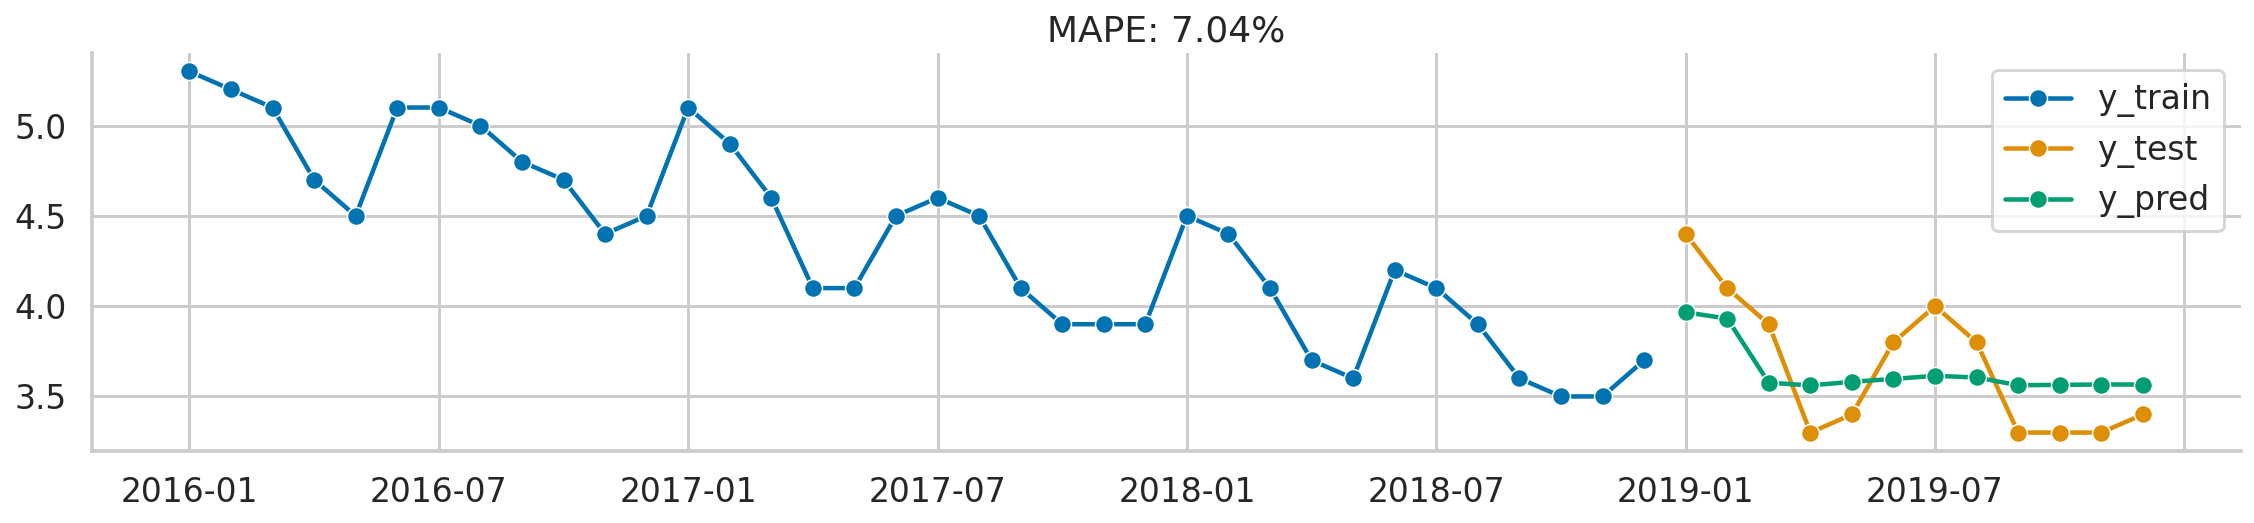

In [28]:
# MAPE 계산
mape_1 = mean_absolute_percentage_error(
    y_test, y_pred_1, symmetric=False
)

# 시계열 데이터 시각화
fig, ax = plot_series(
    y_train["2016":], y_test, y_pred_1,
    labels=["y_train", "y_test", "y_pred"]
)

# 그래프 제목에 MAPE 값 표시
ax.set_title(f"MAPE: {100*mape_1:.2f}%")

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 테두리 제거
sns.despine()

# 그래프 저장 (주석 처리됨)
# plt.savefig("images/figure_7_23")

Figure 7.23: Forecasts vs. actuals using the reduced Random Forest

거의 평평한 예측은 도입부에서 언급한 reduced regression 접근 방식의 단점과 가장 관련이 있을 가능성이 큽니다. 데이터를 표 형식으로 변환함으로써 우리는 추세와 계절성에 대한 정보를 효과적으로 잃게 됩니다. 이를 보완하기 위해, 먼저 시계열 데이터의 **계절성을 제거(deseasonalize)** 하고 **추세를 제거(detrend)** 한 후에 reduced regression 방식을 사용할 수 있습니다.

6. Deseasonalize the time series:

**6단계에서**, 원래 시계열 데이터의 계절성을 제거했습니다. 
- 먼저, **Deseasonalizer** 변환기를 인스턴스화했습니다. 우리는 `sp=12`를 제공하여 월별 계절성을 나타내었고, 계절 패턴의 크기가 시간이 지나도 크게 변하지 않는다는 점에서 **추가적 계절성(additive seasonality)** 을 선택했습니다. 
- 내부적으로, **Deseasonalizer** 클래스는 **statsmodels** 라이브러리의 계절 분해를 수행하며(이전 장의 **Time series decomposition** 레시피에서 다룬 내용) 시계열에서 계절 성분을 제거합니다. 
- 변환기를 학습하고, `fit_transform` 메서드를 사용하여 계절성 제거된 시계열을 얻었습니다. 

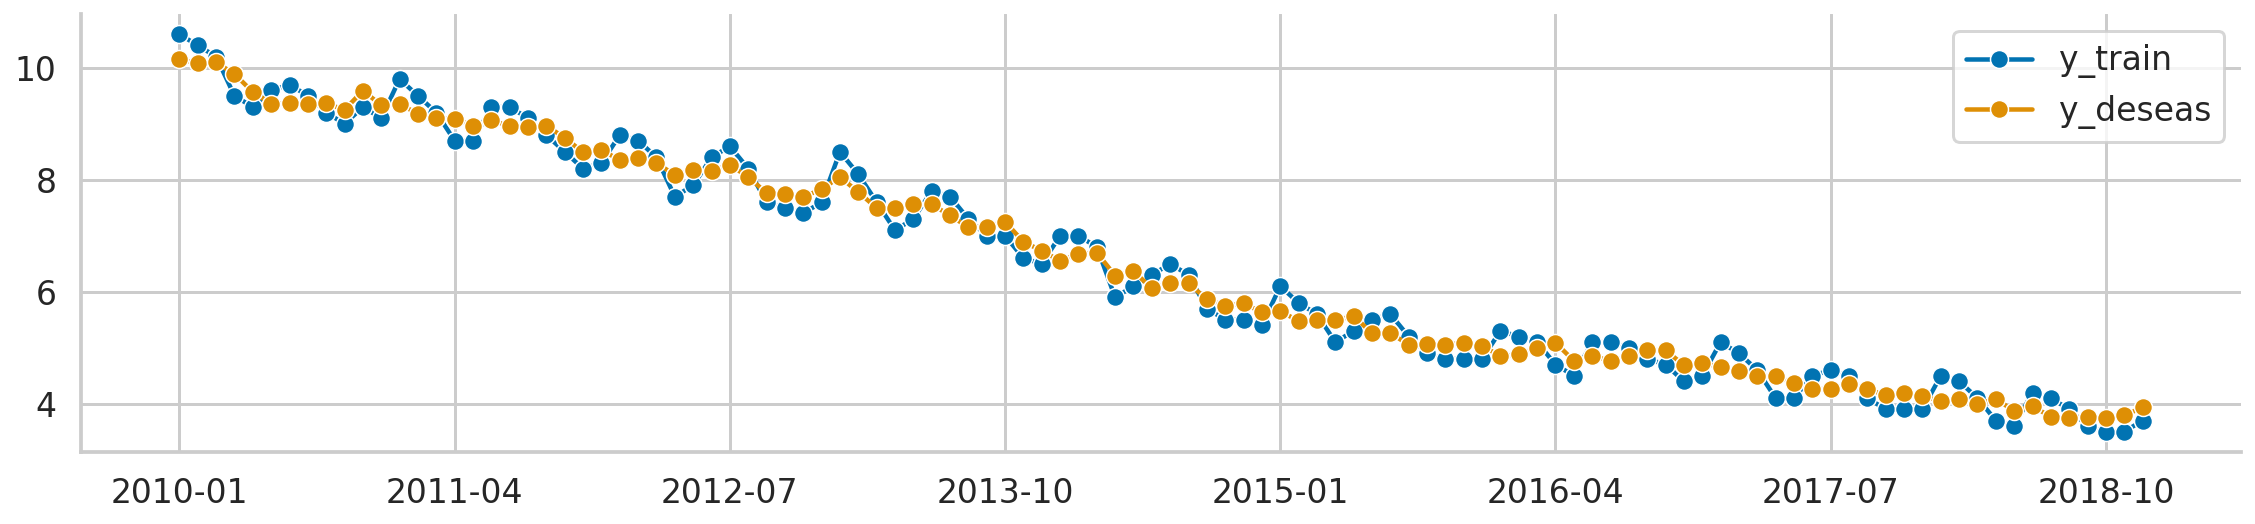

In [29]:
# 계절성 제거를 위한 Deseasonalizer 객체 생성
# model="additive": 가법 모델 사용, sp=12: 월별 데이터 (12개월 주기)
deseasonalizer = Deseasonalizer(model="additive", sp=12)

# 훈련 데이터에서 계절성 제거
y_deseas = deseasonalizer.fit_transform(y_train)

# 원본 시계열과 계절성이 제거된 시계열 시각화
plot_series(
    y_train, y_deseas, 
    labels=["y_train", "y_deseas"]
)

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 테두리 제거
sns.despine()

# 그래프 저장 (현재 주석 처리됨)
# plt.savefig("images/figure_7_24")

Figure 7.24: The original time series and the deseasonalized one

변환기를 학습한 후에는, `seasonal_` 속성을 통해 계절 성분을 확인할 수 있습니다.

더 많은 컨텍스트를 제공하기 위해, 추출된 계절 성분을 플로팅할 수 있습니다:

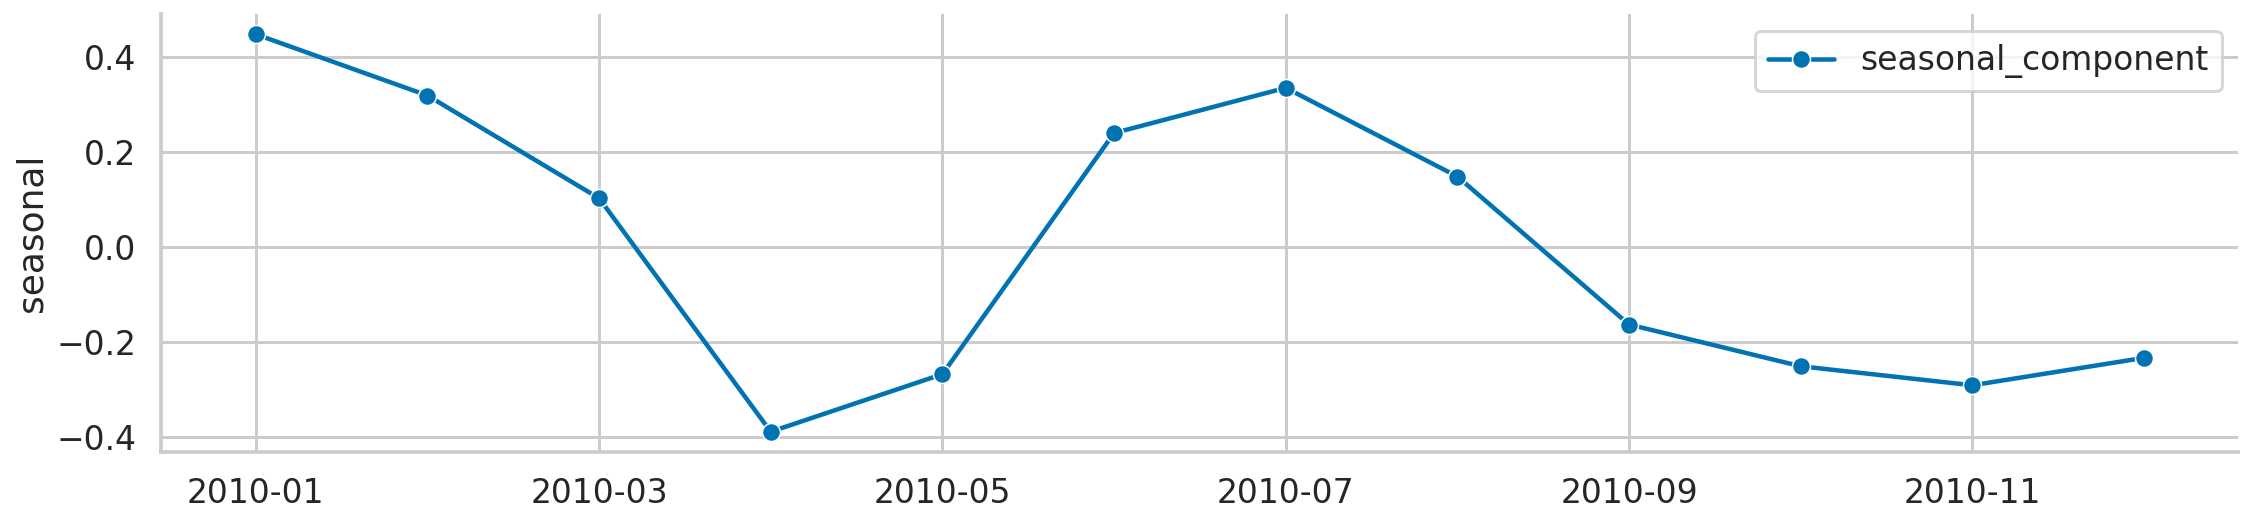

In [30]:
# 추출된 계절 성분을 시각화
plot_series(
    deseasonalizer.seasonal_, 
    labels=["seasonal_component"]
)

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 테두리 제거
sns.despine()

# 그래프 저장 (현재 주석 처리됨)
# plt.savefig("images/figure_7_25")

Figure 7.25: The extracted seasonal component

**그림 7.25** 를 분석할 때, x축 레이블에 너무 주의를 기울일 필요는 없습니다. 추출된 계절 패턴은 매년 동일하기 때문입니다.

7. Detrend the time series:

**7단계에서**, 계절성이 제거된 시계열 데이터에서 **추세(trend)** 를 제거했습니다. 
- 먼저, **PolynomialTrendForecaster** 클래스를 인스턴스화하고 `degree=1`로 설정했습니다. 이렇게 해서 우리는 선형 추세에 관심이 있음을 나타냈습니다. 
- 그런 다음, 인스턴스화한 클래스를 **Detrender** 변환기에 전달했습니다. 이미 익숙한 **fit_transform** 메서드를 사용하여, 계절성이 제거된 시계열 데이터에서 추세를 제거했습니다.

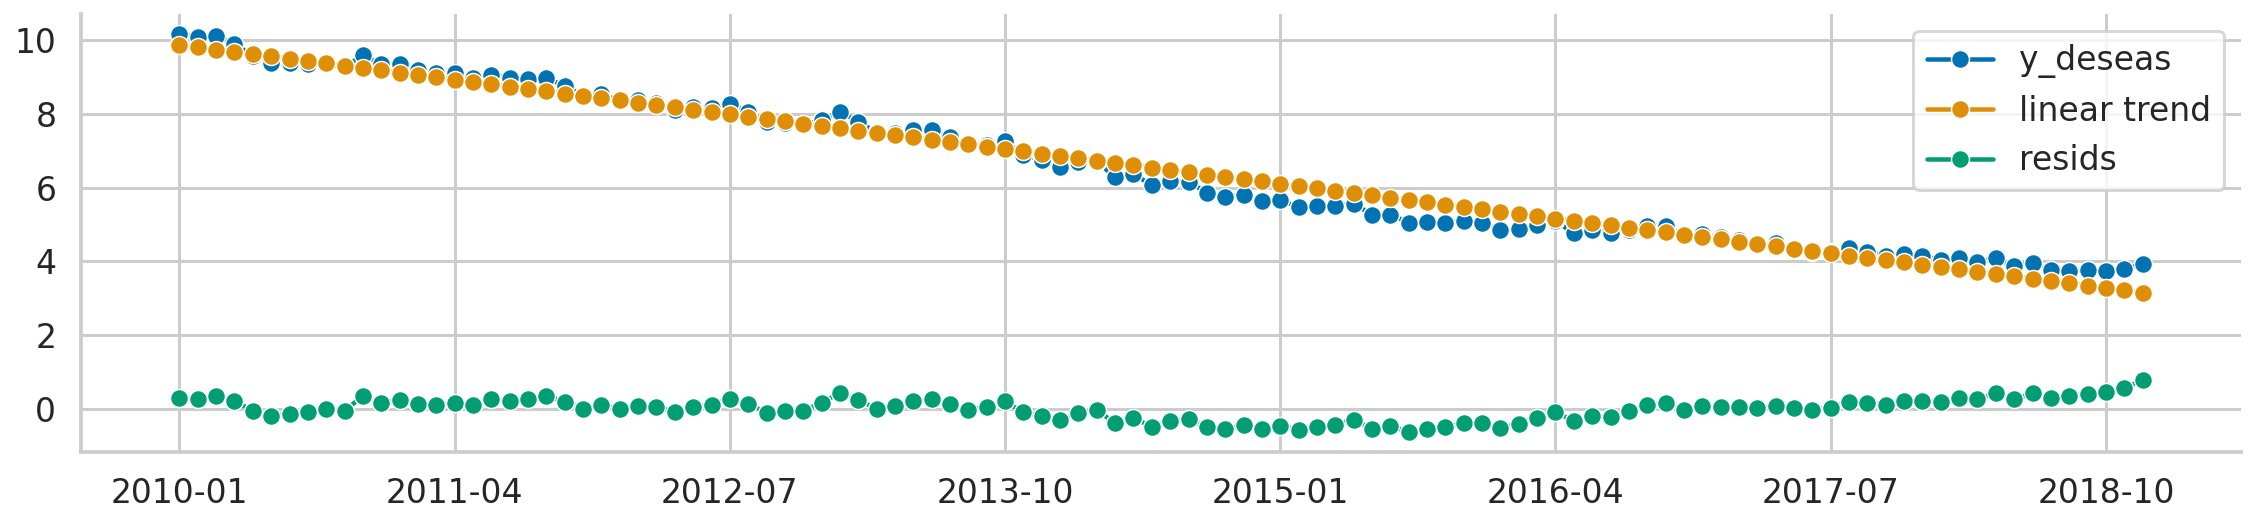

In [31]:
# 1차 다항식 추세 예측기 생성
forecaster = PolynomialTrendForecaster(degree=1)

# 추세 제거기 생성 및 적용
transformer = Detrender(forecaster=forecaster)
y_detrend = transformer.fit_transform(y_deseas)

# 표본 내 예측 수행
forecaster = PolynomialTrendForecaster(degree=1)
y_in_sample = (
    forecaster
    .fit(y_deseas)
    .predict(fh=-np.arange(len(y_deseas)))
)

# 시계열 데이터 시각화
plot_series(
    y_deseas, y_in_sample, y_detrend, 
    labels=["y_deseas", "linear trend", "resids"]
)

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 테두리 제거 
sns.despine()

# 그래프 저장 (현재 주석 처리됨)
# plt.savefig("images/figure_7_26")

Figure 7.26: The deseasonalized time series together with the fitted linear trend and the corresponding residuals

**그림 7.26**에서 우리는 3개의 선을 볼 수 있습니다:
- 이전 단계에서 계절성을 제거한 시계열
- 계절성 제거된 시계열에 맞춘 선형 추세
- 계절성 제거된 시계열에서 맞춘 선형 추세를 뺌으로써 생성된 잔차

8. Combine the components into a pipeline, fit it to the original time series and obtain predictions:

**8단계에서**, 우리는 모든 단계를 하나의 파이프라인에 결합했습니다. 
- 우리는 먼저 시계열을 변환한 다음, ML 모델을 맞춰 예측을 생성하는 데 사용되는 **TransformedTargetForecaster** 클래스를 인스턴스화했습니다. 
- `steps` 인수로 각 단계의 이름과 변환기/추정기를 포함하는 튜플 리스트를 제공했습니다. 
- 이 파이프라인에서는 **계절성 제거**, **추세 제거**, 그리고 4단계에서 사용한 **Reduced Random Forest** 모델을 연결했습니다. 
- 그런 다음, 파이프라인 전체를 학습 데이터에 맞추고 예측을 얻었습니다. 

In [32]:
# TransformedTargetForecaster를 사용하여 파이프라인 생성
rf_pipe = TransformedTargetForecaster(
    steps = [
        # 1단계: 계절성 제거 (12개월 주기로 가법 모델 사용)
        ("deseasonalize", Deseasonalizer(model="additive", sp=12)),
        
        # 2단계: 추세 제거 (1차 다항식 사용)
        ("detrend", Detrender(
            forecaster=PolynomialTrendForecaster(degree=1)
        )),
        
        # 3단계: Random Forest 예측기 적용
        ("forecast", rf_forecaster),
    ]
)

# 학습 데이터로 파이프라인 학습
rf_pipe.fit(y_train)

# 예측 수행
y_pred_2 = rf_pipe.predict(fh)

9. Evaluate the pipeline's predictions:

**9단계에서는**, MAPE 점수를 계산하고 예측값과 실제값을 플로팅하여 파이프라인의 성능을 평가했습니다.

이번 예에서는 원래 시계열을 사용하여 모델을 만드는 데만 집중했습니다. 물론, 우리는 예측을 생성하는 데 사용되는 다른 피처들도 추가할 수 있습니다. **sktime** 은 주어진 변환기를 X(피처)에 적용할 수 있는 파이프라인 기능도 제공합니다. 우리는 **ForecastingPipeline** 클래스를 사용하여 회귀 변수와 관련된 변환을 포함하는 파이프라인을 만들 수 있습니다. 또한, X와 y(목표) 모두에 대해 일부 변환을 적용할 수도 있습니다. 그런 경우, **ForecastingPipeline**의 단계로 y에 적용할 변환기를 포함한 **TransformedTargetForecaster**를 전달할 수 있습니다.

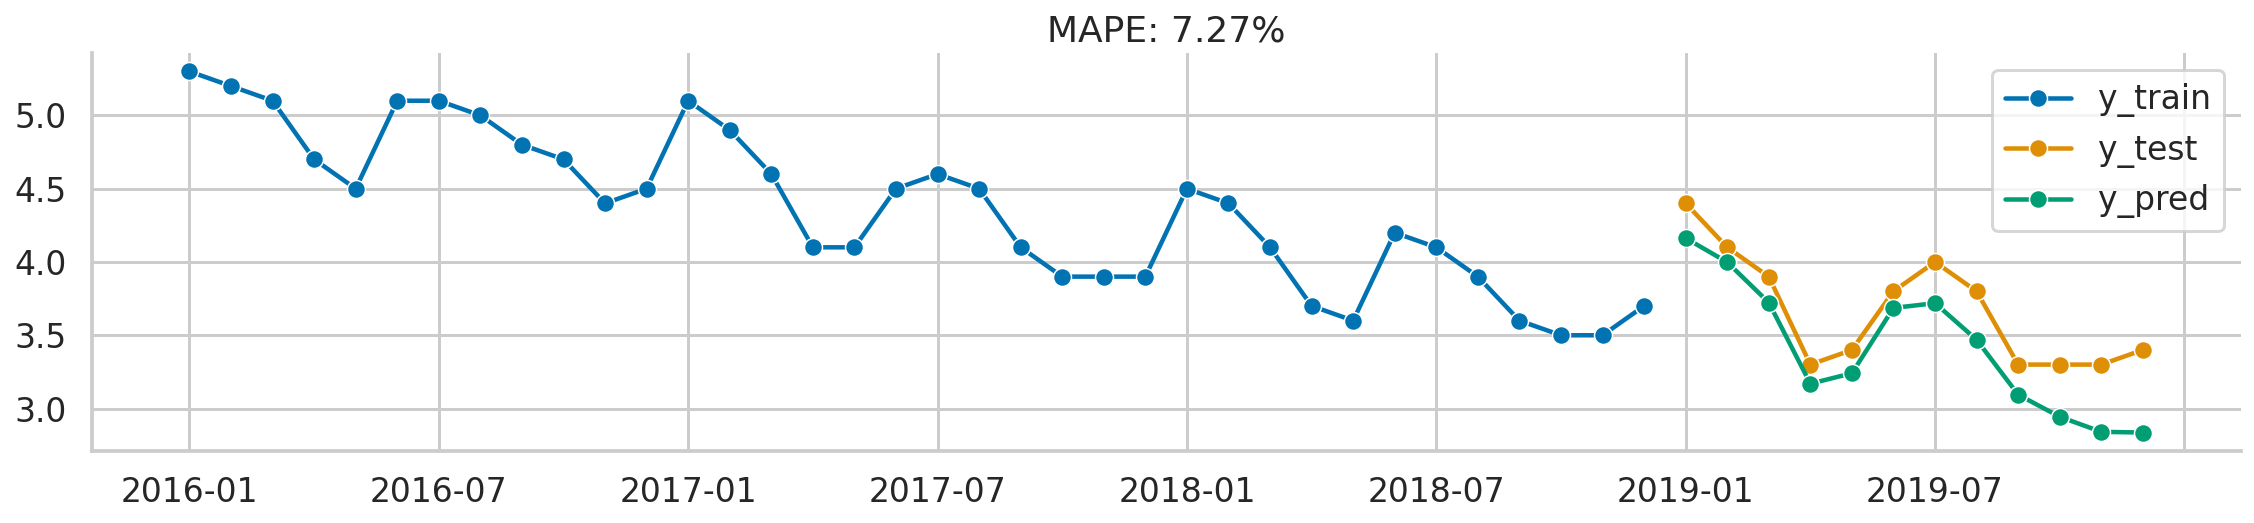

In [33]:
# MAPE 계산
mape_2 = mean_absolute_percentage_error(
    y_test, y_pred_2, symmetric=False
)

# 시계열 데이터 플로팅
fig, ax = plot_series(
    y_train["2016":], y_test, y_pred_2,
    labels=["y_train", "y_test", "y_pred"]
)

# 그래프 제목 설정 (MAPE 값 포함)
ax.set_title(f"MAPE: {100*mape_2:.2f}%")

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 테두리 제거
sns.despine()

# 그래프 저장 (현재 주석 처리됨)
# plt.savefig("images/figure_7_27")

Figure 7.27: The fit of the pipeline containing deseasonalization and detrending before reduced regression

**그림 7.27**을 분석함으로써 다음과 같은 결론을 도출할 수 있습니다:
- 파이프라인을 사용하여 얻은 예측의 모양이 실제 값과 훨씬 유사합니다. 추세와 계절성 성분을 포착하고 있습니다.
- MAPE로 측정된 오차는 **그림 7.23** 에서 보이는 거의 평평한 예측보다 더 나쁠 수 있습니다.
    - MAPE 값이 작을수록 예측이 실제 값에 더 가깝다는 것을 의미

10. Evaluate the performance using expanding window cross-validation:

**10단계에서는**, 모델 성능을 평가하기 위해 워크-포워드 교차 검증을 사용한 추가 평가 단계를 수행했습니다. 확장 윈도우를 사용하여 교차 검증 스킴을 정의하기 위해, 우리는 **ExpandingWindowSplitter** 클래스를 사용했습니다. 입력으로는 다음을 제공해야 했습니다:

- **fh**: 예측 구간. 우리는 12단계 예측을 평가하고자 했기 때문에 1에서 12까지의 정수 리스트를 제공했습니다.
- **initial_window**: 초기 학습 윈도우의 길이. 우리는 60으로 설정했으며, 이는 5년의 학습 데이터를 의미합니다.
- **step_length**: 이 값은 확장 윈도우가 실제로 얼마나 확장될지에 대한 주기를 나타냅니다. 우리는 이를 12로 설정하여, 각 폴드가 추가 1년의 학습 데이터를 가지도록 했습니다.

In [34]:
# 확장 윈도우 교차 검증을 위한 분할기 생성
# fh: 1부터 12까지의 예측 구간
# initial_window: 초기 학습 윈도우 크기 (5년)
# step_length: 각 단계마다 윈도우 확장 크기 (1년)
cv = ExpandingWindowSplitter(
    fh=list(range(1,13)), 
    initial_window=12*5, 
    step_length=12
)

검증 전략을 정의한 후, **evaluate** 함수를 사용하여 **8단계에서 정의된 파이프라인의 성능**을 평가했습니다. **evaluate** 함수에서, 데이터를 확장된 윈도우로 받아들이는 접근 방식을 정의하는 **strategy** 인수를 지정해야 했습니다. 선택 가능한 옵션은 다음과 같습니다:

- **refit**: 각 학습 윈도우에서 모델을 다시 맞춥니다.
- **update**: 예측기가 새 학습 데이터로 업데이트되지만 다시 맞추지는 않습니다.
- **no-update_params**: 모델은 처음 학습 윈도우에 맞춰지고, 이후로는 다시 맞추거나 업데이트하지 않습니다.

In [35]:
# 교차 검증 수행
# forecaster: 랜덤 포레스트 파이프라인
# y: 시계열 데이터
# cv: 확장 윈도우 분할기
# strategy: 각 폴드마다 모델 재학습
# return_data: 예측 결과 데이터 반환
cv_df = evaluate(
    forecaster=rf_pipe, 
    y=y, 
    cv=cv, 
    strategy="refit", 
    return_data=True
)

# 교차 검증 결과 출력
cv_df

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.017968,0.075441,0.025739,60,2014-12,unemp_rate 2010-01 10.6 2010-0...,unemp_rate 2015-01 6.1 2015-0...,unemp_rate 2015-01 6.189424 2015-0...
1,0.072160,0.073419,0.025987,72,2015-12,unemp_rate 2010-01 10.6 2010-0...,unemp_rate 2016-01 5.3 2016-0...,unemp_rate 2016-01 5.424690 2016-0...
2,0.092562,0.077804,0.026080,84,2016-12,unemp_rate 2010-01 10.6 2010-0...,unemp_rate 2017-01 5.1 2017-0...,unemp_rate 2017-01 5.043032 2017-0...
3,0.099018,0.080588,0.025720,96,2017-12,unemp_rate 2010-01 10.6 2010-0...,unemp_rate 2018-01 4.5 2018-0...,unemp_rate 2018-01 4.378566 2018-0...
4,0.072701,0.083246,0.026676,108,2018-12,unemp_rate 2010-01 10.6 2010-0...,unemp_rate 2019-01 4.4 2019-0...,unemp_rate 2019-01 4.162716 2019-0...


Figure 7.28: The DataFrame containing the cross-validation results

추가적으로, 교차 검증 절차 내에서 파이프라인을 학습하고 평가하는 데 사용된 날짜 범위를 조사할 수 있습니다:

In [36]:
for ind, row in cv_df.iterrows():
    print(f"Fold {ind} ----")
    print(f"Training: {row['y_train'].index.min()} - {row['y_train'].index.max()}")
    print(f"Testing: {row['y_test'].index.min()} - {row['y_test'].index.max()}")


Fold 0 ----
Training: 2010-01 - 2014-12
Testing: 2015-01 - 2015-12
Fold 1 ----
Training: 2010-01 - 2015-12
Testing: 2016-01 - 2016-12
Fold 2 ----
Training: 2010-01 - 2016-12
Testing: 2017-01 - 2017-12
Fold 3 ----
Training: 2010-01 - 2017-12
Testing: 2018-01 - 2018-12
Fold 4 ----
Training: 2010-01 - 2018-12
Testing: 2019-01 - 2019-12


효과적으로, 우리는 각 폴드 사이에 12개월씩 증가하는 확장 창을 사용하여 5-폴드 교차 검증을 만들었으며, 항상 다음 12개월을 사용하여 평가를 수행하고 있습니다.

11. Plot the predictions from the cross-validation folds:

**11단계**에서는 `plot_series` 함수를 리스트 컴프리헨션과 결합하여 원래의 시계열 데이터와 검증 폴드에서 얻은 예측값을 시각화했습니다.

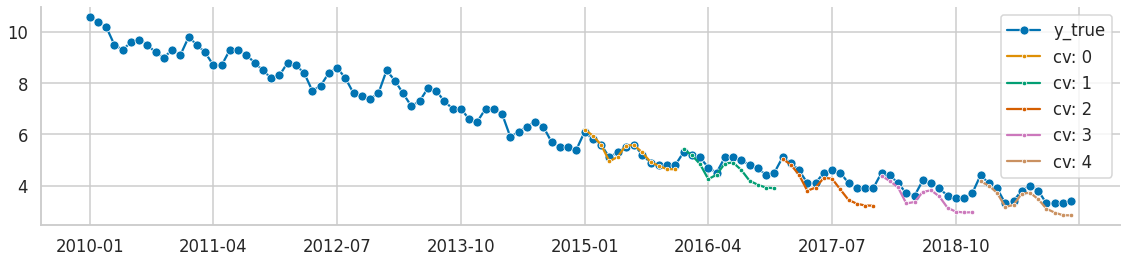

In [131]:
# 교차 검증 폴드 수 계산
n_fold = len(cv_df)

# 시계열 데이터와 각 교차 검증 폴드의 예측값 플롯
plot_series(
    y,  # 실제 데이터
    *[cv_df["y_pred"].iloc[x] for x in range(n_fold)],  # 각 폴드의 예측값
    markers=["o", *["."] * n_fold],  # 마커 스타일 설정
    labels=["y_true"] + [f"cv: {x}" for x in range(n_fold)]  # 레이블 설정
)

# 그래프 레이아웃 조정
plt.tight_layout()
# 불필요한 테두리 제거
sns.despine()
# 이미지 저장 (주석 처리됨)
# plt.savefig("images/figure_7_29")

Figure 7.29: Forecasts from each of the cross-validation folds plotted against the actuals

12. Create an ensemble forecast using the RF pipeline and AutoARIMA:

In [38]:
# 경고 메시지를 무시하기 위한 설정
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# ConvergenceWarning 및 특정 메시지에 대한 경고 무시
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-invertible starting seasonal moving average")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")

# 앙상블 예측기 생성
ensemble = EnsembleForecaster(
    forecasters = [
        ("autoarima", AutoARIMA(sp=12)),  # AutoARIMA 모델 (계절성 주기 12)
        ("rf_pipe", rf_pipe)  # 랜덤 포레스트 파이프라인
    ]
)

# 앙상블 모델 학습
ensemble.fit(y_train)

# 앙상블 모델을 사용한 예측
y_pred_3 = ensemble.predict(fh)

이 경우, 우리는 원래의 시계열 데이터에 직접 AutoARIMA 모델을 피팅했습니다. 그러나 모델을 피팅하기 전에 시계열 데이터를 계절성 제거(deseasonalize)하고 추세를 제거(detrend)할 수도 있었습니다. 그런 경우, 계절 주기를 명시할 필요가 없을 수도 있으며, 이는 고전적인 분해 방법으로 계절성이 얼마나 잘 제거되었는지에 따라 달라집니다.

13. Evaluate the ensemble's predictions:

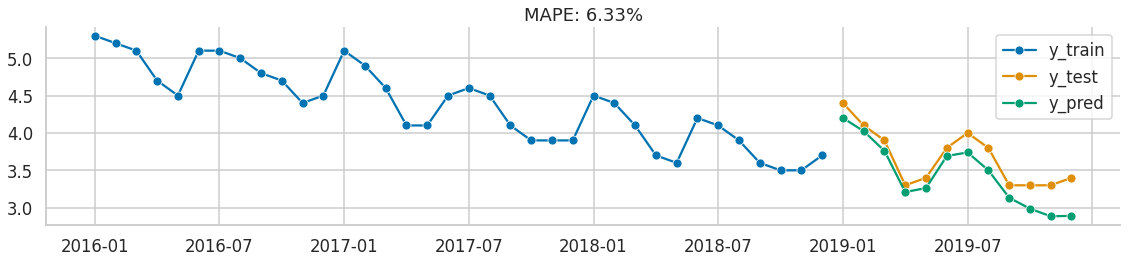

In [133]:
# 앙상블 모델의 MAPE 계산
mape_3 = mean_absolute_percentage_error(
    y_test, y_pred_3, symmetric=False
)

# 시계열 데이터 시각화
fig, ax = plot_series(
    y_train["2016":], y_test, y_pred_3,
    labels=["y_train", "y_test", "y_pred"]
)

# 그래프 제목에 MAPE 값 표시
ax.set_title(f"MAPE: {100*mape_3:.2f}%")

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 테두리 제거
sns.despine()

# 그래프 저장 (주석 처리됨)
# plt.savefig("images/figure_7_30")

Figure 7.30: The fit of the ensemble model aggregating the reduced regression pipeline and AutoARIMA

**그림 7.30**에서 볼 수 있듯이, 두 모델을 앙상블한 결과 축소된 랜덤 포레스트 파이프라인과 비교하여 성능이 향상되었습니다.

### There's more

이 레시피에서는 **sktime**을 사용한 축소 회귀를 다루었습니다. 이미 언급한 것처럼, **sktime**은 시계열 작업에 필요한 모든 도구를 제공하는 프레임워크입니다. 아래에는 **sktime**을 사용하는 장점과 그 기능들을 나열했습니다:

- 이 라이브러리는 시계열 예측뿐만 아니라 회귀, 분류, 클러스터링 작업에도 적합합니다. 추가적으로 기능 추출 기능도 제공합니다.
- **sktime**은 몇 가지 간단한 모델을 제공하며, 이는 벤치마크를 만드는 데 매우 유용합니다. 예를 들어, **NaiveForecaster** 모델을 사용하여 마지막으로 알려진 값을 그대로 예측할 수 있습니다. 예를 들어, 2019년 1월의 예측은 2018년 1월의 시계열 값이 될 수 있습니다.
- 이 라이브러리는 **statsmodels**, **pmdarima**, **tbats**, 또는 **Meta의 Prophet**과 같은 많은 인기 있는 시계열 라이브러리들을 래핑하는 통합 API를 제공합니다. 사용 가능한 모든 예측 모델을 확인하려면 `all_estimators("forecaster", as_dataframe=True)` 명령어를 실행할 수 있습니다.
- 축소(reduction)를 사용하면 **scikit-learn** API와 호환되는 모든 추정기를 사용하여 예측할 수 있습니다.
- **sktime**은 시차의 수나 윈도우 길이와 같은 축소 과정과 관련된 하이퍼파라미터 튜닝을 위한 기능을 제공합니다.
- 이 라이브러리는 다양한 성능 평가 지표를 제공하며(**scikit-learn**에는 제공되지 않음), 맞춤형 평가 지표를 쉽게 만들 수 있습니다.
- 이 라이브러리는 **scikit-learn**의 파이프라인을 확장하여 여러 변환기(예: 추세 제거, 계절성 제거 등)를 예측 알고리즘과 결합할 수 있습니다.
- 이 라이브러리는 AutoML 기능을 제공하여 다양한 모델과 그 하이퍼파라미터에서 최적의 예측기를 자동으로 결정할 수 있습니다.

1. Create naive forecasts using the `NaiveForecaster`:

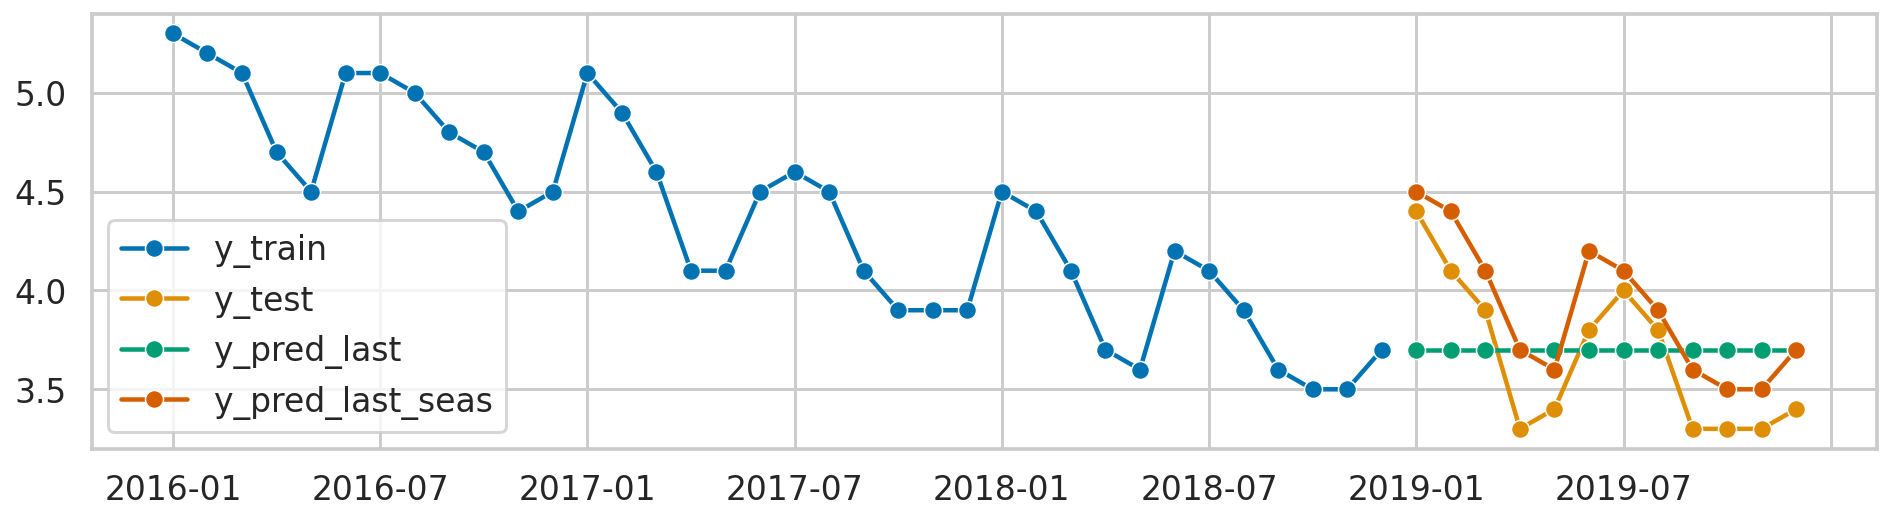

In [39]:
# NaiveForecaster를 사용하여 단순 예측 모델 생성
from sktime.forecasting.naive import NaiveForecaster

# 예측 기간 설정
fh = ForecastingHorizon(y_test.index, is_relative=False)

# 마지막 관측값을 사용하는 단순 예측 모델
naive_fcst_last = NaiveForecaster(strategy="last")
naive_fcst_last.fit(y_train)
y_last = naive_fcst_last.predict(fh)

# 계절성을 고려한 단순 예측 모델 (12개월 주기)
naive_fcst_seas = NaiveForecaster(strategy="last", sp=12)
naive_fcst_seas.fit(y_train)
y_seasonal_last = naive_fcst_seas.predict(fh)

# 결과 시각화
plot_series(
    y_train["2016":], y_test, y_last, y_seasonal_last, 
    labels=["y_train", "y_test", "y_pred_last", "y_pred_last_seas"]
);

2. Inspect all the available models:

In [41]:
# 경고 메시지를 무시하기 위한 설정
import warnings

# 다양한 패키지 관련 경고 메시지 무시
warnings.filterwarnings("ignore", message="requires package 'dtw-python'")
warnings.filterwarnings("ignore", message="No module named 'hmmlearn'")
warnings.filterwarnings("ignore", message="tensorflow and tensorflow-probability are required")
warnings.filterwarnings("ignore", message="No module named 'esig'")
warnings.filterwarnings("ignore", message="No module named 'tslearn'")
warnings.filterwarnings("ignore", message="No module named 'prophet'")
warnings.filterwarnings("ignore", message="No module named 'statsforecast'")
warnings.filterwarnings("ignore", message="No module named 'mne'")
warnings.filterwarnings("ignore", message="No module named 'filterpy'")
warnings.filterwarnings("ignore", message="No module named 'stumpy'")

# sktime의 모든 예측기(forecaster) 목록 가져오기
from sktime.registry import all_estimators

# 모든 예측기를 데이터프레임 형태로 출력
all_estimators("forecaster", as_dataframe=True)

,name,estimator
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
1,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
2,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
5,BATS,<class 'sktime.forecasting.bats.BATS'>
6,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
7,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
8,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
9,Croston,<class 'sktime.forecasting.croston.Croston'>


### See also 
- Löning, M., Bagnall, A., Ganesh, S., Kazakov, V., Lines, J., & Király, F. J. 2019. sktime: A Unified Interface for Machine Learning with Time Series. arXiv preprint arXiv:1909.07872.

## 7.4 Forecasting with Meta's Prophet

이전 레시피에서, 우리는 일반적으로 회귀 작업에 사용되는 머신러닝 모델을 활용하여 시계열 예측 문제를 재구성하는 방법을 다루었습니다. 이번에는 시계열 예측을 위해 특별히 설계된 모델을 소개합니다.

**Prophet**은 Facebook(현재 Meta)에 의해 2017년에 도입되었으며, 이후로 시계열 예측을 위한 매우 인기 있는 도구가 되었습니다. 그 인기가 높은 이유 중 일부는 다음과 같습니다:

- 대부분의 경우, 별다른 설정 없이도 합리적인 결과/예측을 도출합니다.
- 비즈니스 관련 시계열 예측을 위해 설계되었습니다.
- 강한 계절적 요소가 있는 일일 시계열 데이터 및 최소 몇 시즌의 훈련 데이터를 사용할 때 가장 잘 작동합니다.
- 시간별, 일별, 주별, 월별, 분기별 또는 연도별과 같은 여러 계절성을 모델링할 수 있습니다.
- 이 알고리즘은 누락된 데이터와 추세 변화에 대해 매우 강건하며, 자동 변화점 감지를 사용합니다.
- 휴일과 특별 이벤트를 쉽게 반영할 수 있습니다.
- 자기회귀 모델(예: ARIMA)과 비교했을 때, 정상성을 요구하지 않습니다.
- 인간이 해석 가능한 하이퍼파라미터를 조정하여 도메인 지식을 예측에 활용할 수 있습니다.
- 추가적인 회귀 변수를 사용하여 모델의 예측 성능을 향상시킬 수 있습니다.

물론, 이 모델이 완벽한 것은 아니며 자체적인 몇 가지 문제를 겪고 있습니다. "참고" 섹션에서 이 모델의 약점을 보여주는 몇 가지 참고 자료를 나열했습니다.

**Prophet**의 창시자들은 시계열 예측 문제를 곡선 맞추기 연습으로 접근했으며(이로 인해 데이터 과학 커뮤니티에서 많은 논란이 제기됨), 시계열 내에서 각 관측치의 시간 기반 의존성을 명시적으로 살펴보는 대신에 곡선을 맞추는 방식으로 접근했습니다. 그 결과, Prophet은 가법 모델(일반화된 가법 모델 또는 GAM의 일종)이며 다음과 같이 표현될 수 있습니다:

$
y(t) = g(t) + h(t) + s(t) + \epsilon_t
$

- 여기서,
  - **g(t)**: 성장 항, 부분적으로 선형, 로지스틱 또는 평탄할 수 있습니다. 추세 구성 요소는 비주기적인 시계열 변화를 모델링합니다.
  - **h(t)**: 휴일 및 특별 일자의 영향을 설명합니다(잠재적으로 불규칙한 간격으로 발생). 더미 변수로 모델에 추가됩니다.
  - **s(t)**: 푸리에 급수를 사용하여 모델링된 다양한 계절 패턴을 설명합니다.
  - **ε_t**: 오차 항으로, 일반적으로 정규 분포한다고 가정합니다.

**로지스틱 성장 경향**은 포화(또는 제한된) 성장을 모델링할 때 특히 유용합니다. 예를 들어, 특정 국가에서 고객 수를 예측할 때, 그 나라의 총 인구를 초과하는 수치를 예측해서는 안 됩니다. **Prophet**을 사용하면 포화된 최소값도 고려할 수 있습니다.

**GAM**(Generalized Additive Models)은 단순하면서도 강력한 모델로, 점점 더 인기를 얻고 있습니다. 이 모델들은 개별 피처와 대상 간의 관계가 부드러운 패턴을 따른다고 가정합니다. 이러한 관계는 선형 또는 비선형일 수 있으며, 이를 동시에 추정하고 예측값을 도출하는 데 합산할 수 있습니다. 예를 들어, 계절성을 가법적인 구성 요소로 모델링하는 것은 **Holt-Winters**의 지수 평활법과 동일한 접근 방식입니다. **Prophet**에서 사용하는 GAM 공식에는 다음과 같은 장점이 있습니다. 첫째, 쉽게 분해됩니다. 둘째, 새로운 계절성 요소를 수용할 수 있습니다. 예를 들어, 새로운 계절성 원천을 식별할 때 이 장점을 활용할 수 있습니다.

**Prophet**의 또 다른 중요한 측면은 추세를 추정하는 과정에서 **변화점**을 포함하는 것으로, 이는 추세 곡선을 보다 유연하게 만듭니다. 변화점을 통해 추세는 예기치 않은 패턴 변화에 맞게 조정될 수 있습니다. 예를 들어, COVID-19 팬데믹으로 인해 판매 패턴이 변화한 경우가 있습니다. **Prophet**은 변화점을 감지하는 자동화된 절차를 제공하지만, 날짜 형태의 수동 입력도 허용할 수 있습니다.

**Prophet**은 베이지안 접근 방식을 사용하여 추정됩니다(이는 C++로 작성된 통계 추론용 프로그래밍 언어인 **Stan**을 사용함으로써 가능해집니다). 또한 변화점 선택을 자동으로 수행하고, **마르코프 연쇄 몬테카를로**(MCMC) 또는 **최대 사후 추정**(MAP) 방법을 사용하여 신뢰 구간을 생성합니다.

이 레시피에서는 2015년부터 2019년까지의 데이터를 사용하여 일일 금 가격을 예측하는 방법을 보여줍니다. 우리는 모델이 금 가격을 정확히 예측할 가능성은 낮다는 것을 알고 있지만, 이를 통해 모델을 학습하고 사용하는 방법을 설명하려 합니다.

### How to do it...

1. Import the libraries and authenticate with Nasdaq Data Link:

In [44]:
import pandas as pd
import nasdaqdatalink
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os 

nasdaqdatalink.ApiConfig.api_key = os.environ["NASDAQ_API_KEY"]

2. Download the daily gold prices:

라이브러리를 가져온 후, 우리는 Nasdaq Data Link에서 일일 금 가격 데이터를 다운로드했습니다.

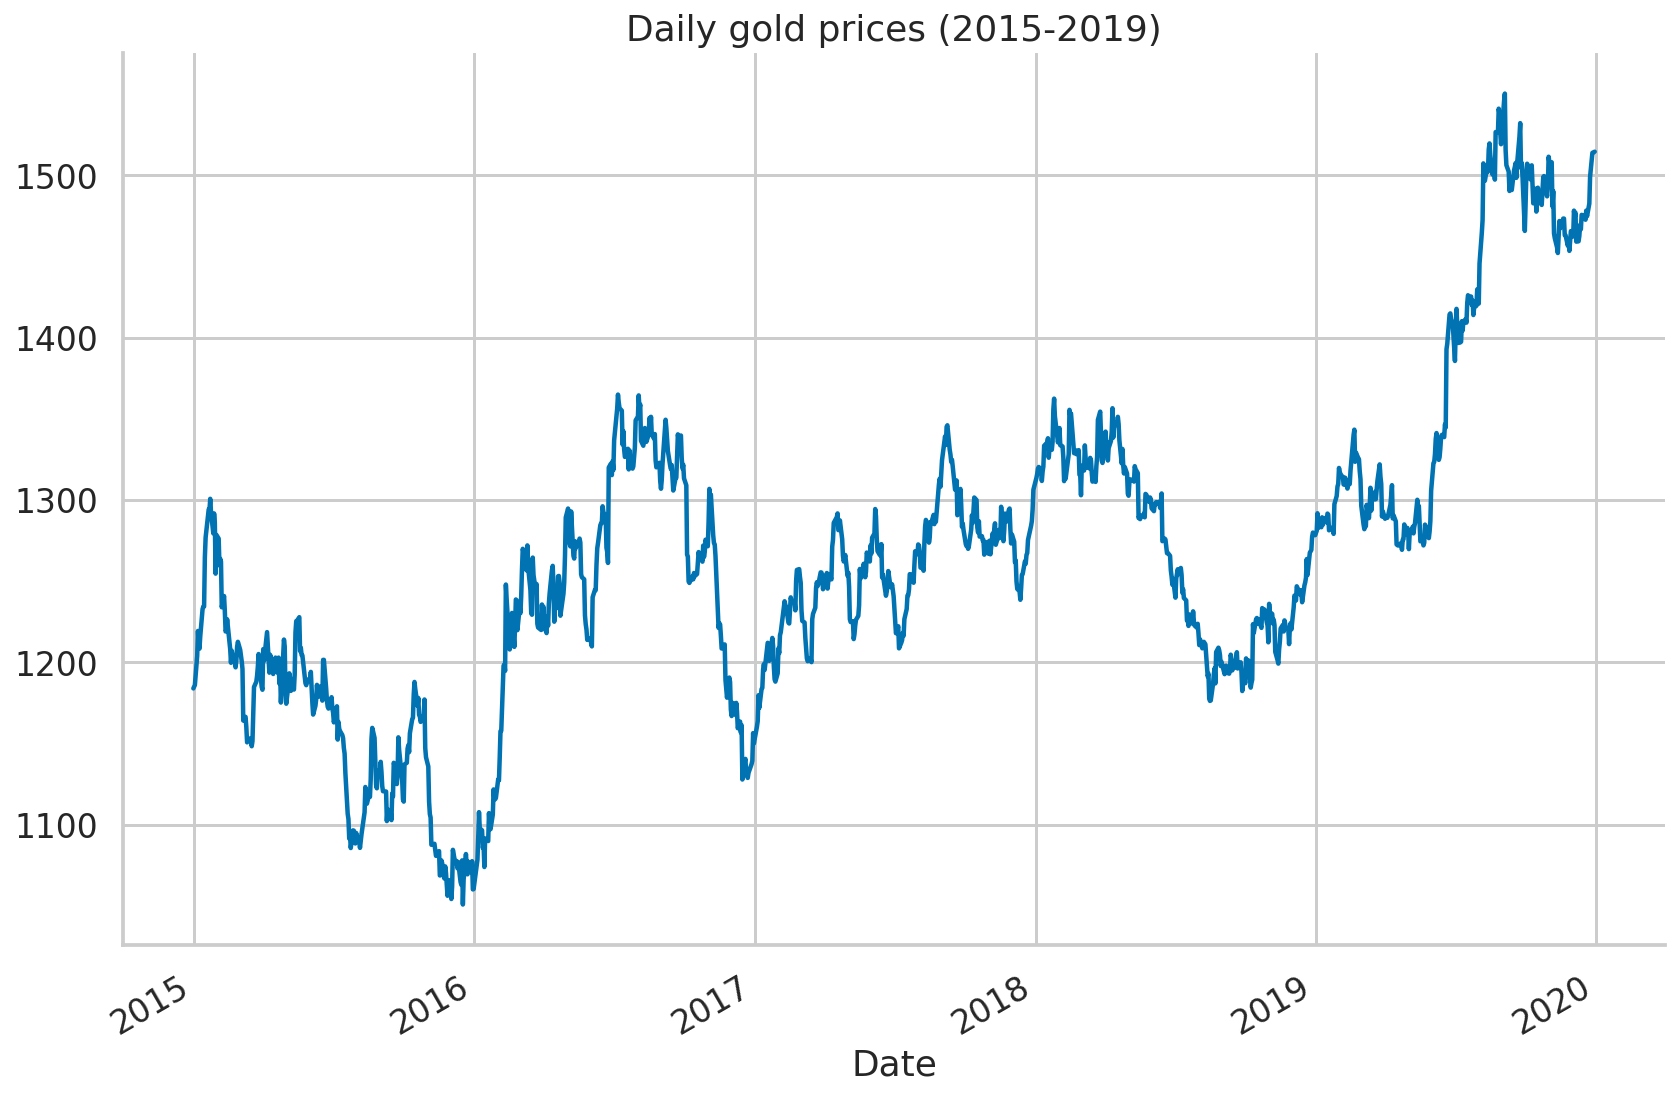

In [53]:
# Nasdaq Data Link에서 금 가격 데이터를 가져오는 코드 (현재 주석 처리됨)
# df = nasdaqdatalink.get(
#     dataset="WGC/GOLD_DAILY_USD",
#     start_date="2015-01-01",
#     end_date="2019-12-31"
# )

# Nasdaq 데이터 플로팅 코드 (현재 주석 처리됨)
# df.plot(title="Daily gold prices (2015-2019)")

# yfinance를 사용하여 금 가격 데이터 다운로드
df = yf.download("GC=F", start="2015-01-01", end="2019-12-31")

# 종가 데이터만 선택하여 플로팅
df["Close"].plot(title="Daily gold prices (2015-2019)")
df = df[["Close"]]

# 그래프 레이아웃 및 스타일 조정
plt.tight_layout()
sns.despine()

# 그래프 저장 코드 (현재 주석 처리됨)
# plt.savefig("images/figure_7_31")

Figure 7.31: Daily gold prices from the years 2015 to 2019

3. Rename the columns:

**Step 3**에서는 DataFrame의 열 이름을 **Prophet**과 호환되도록 변경했습니다. 알고리즘은 두 개의 열을 요구합니다:

- `ds` — 타임스탬프를 나타냄
- `y` — 목표 변수를 나타냄

In [55]:
df = df.reset_index(drop=False)
df.columns = ["ds", "y"]

In [56]:
df

,ds,y
0,2014-12-31,1183.900024
1,2015-01-02,1186.000000
2,2015-01-05,1203.900024
3,2015-01-06,1219.300049
4,2015-01-07,1210.599976
...,...,...
1250,2019-12-23,1482.500000
1251,2019-12-24,1499.099976
1252,2019-12-26,1509.300049
1253,2019-12-27,1513.800049


4. Split the series into the training and test sets:

**Step 4**에서는 DataFrame을 학습 세트와 테스트 세트로 나누었습니다. 2019년 4분기를 테스트 세트로 사용하기로 임의로 결정했습니다.

In [57]:
train_indices = df["ds"] < "2019-10-01"
df_train = df.loc[train_indices].dropna()
df_test = (
    df
    .loc[~train_indices]
    .reset_index(drop=True)
)

우리는 임의로 2019년 마지막 분기를 테스트 세트로 선택했습니다. 따라서 약 60개의 관측치를 예측하는 모델을 생성할 것입니다.

5. Create the instance of the model and fit it to the data:

**Step 5**에서는 **Prophet** 모델을 인스턴스화했습니다. 이때 몇 가지 설정을 지정했습니다:

- 우리는 **changepoint_range**를 0.9로 설정했습니다. 이는 알고리즘이 학습 데이터의 처음 90%에서 변화점을 식별할 수 있음을 의미합니다. 기본적으로 **Prophet**은 시계열의 처음 80%에서 25개의 변화점을 추가합니다. 이 경우, 우리는 더 최근의 추세를 캡처하고자 했습니다.
- **add_seasonality** 메서드를 사용하여 Prophet의 문서에서 제안한 값으로 월별 계절성을 추가했습니다. **period**를 30.5로 지정하면 약 30.5일마다 패턴이 반복될 것으로 예상하게 됩니다. 다른 매개변수인 **fourier_order**는 특정 계절성 구성 요소를 구성하는 푸리에 항의 수를 지정하는 데 사용할 수 있습니다(이 경우 월별입니다). 일반적으로 순서가 높을수록 계절성 구성 요소가 더 유연해집니다.
- **add_country_holidays** 메서드를 사용하여 미국 공휴일을 모델에 추가했습니다. 우리는 기본 캘린더(holidays 라이브러리 사용 가능)를 사용했지만, 캘린더에 없는 사용자 정의 이벤트도 추가할 수 있습니다. 한 예로는 **블랙 프라이데이**가 있습니다. 사용자 정의 이벤트를 제공할 때, 해당 이벤트가 특정 날짜 주변에 미치는 영향을 지정할 수도 있습니다. 예를 들어, 소매 시나리오에서 크리스마스 이후 몇일간 교통량/판매량이 감소할 것으로 예상할 수 있습니다. 반면, 크리스마스 직전에는 급증할 수도 있습니다.

그런 다음 **fit** 메서드를 사용하여 모델을 학습시켰습니다.

In [58]:
prophet = Prophet(changepoint_range=0.9)
prophet.add_country_holidays(country_name="US")
prophet.add_seasonality(
    name="monthly", period=30.5, fourier_order=5
)
prophet.fit(df_train)

19:14:41 - cmdstanpy - INFO - Chain [1] start processing
19:14:41 - cmdstanpy - INFO - Chain [1] done processing


6. Forecast the gold prices for the fourth quarter of 2019 and plot the results:

**Step 6**에서는 학습된 모델을 사용하여 예측을 얻었습니다. **Prophet**으로 예측을 생성하려면 **make_future_dataframe** 메서드를 사용하여 특별한 DataFrame을 생성해야 했습니다. 이 과정에서 우리는 테스트 세트의 길이만큼 예측하고 싶다는 것을 표시했으며(기본적으로 이는 일 단위로 측정됨), 영업일을 사용하고 싶다는 것을 지정했습니다. 이 부분이 중요합니다. 왜냐하면 주말에는 금 가격 데이터가 없기 때문입니다. 그런 다음 학습된 모델의 **predict** 메서드를 사용하여 예측을 생성했습니다.

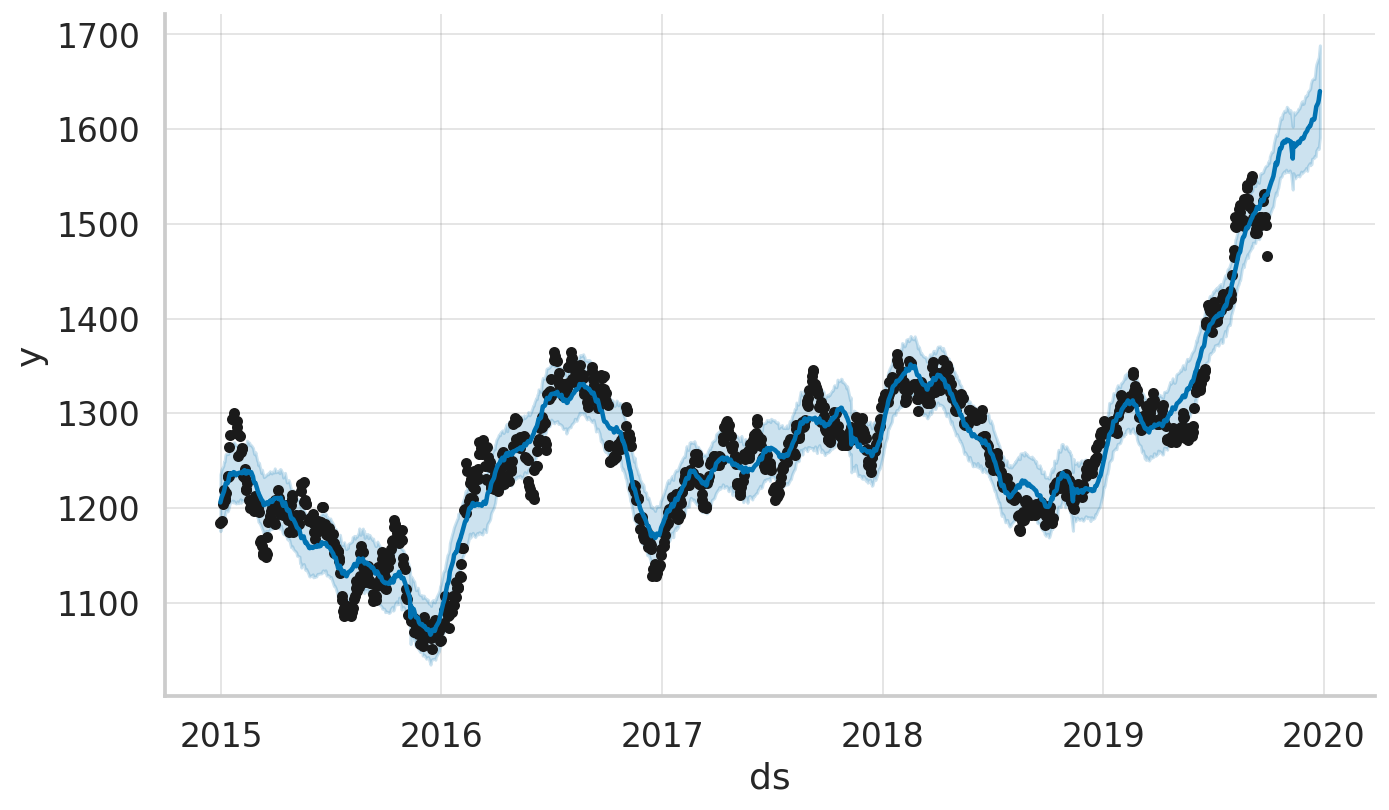

In [59]:
df_future = prophet.make_future_dataframe(
    periods=len(df_test), freq="B"
)
df_pred = prophet.predict(df_future)
prophet.plot(df_pred)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_32")

Figure 7.32: The forecast obtained using Prophet

이 그림을 해석하려면 다음을 알아야 합니다:

- 검은 점은 실제 금 가격의 관측치입니다.
- 피팅된 값을 나타내는 파란색 선은 관측치와 정확히 일치하지 않으며, 모델이 데이터의 잡음을 부드럽게 처리하면서 과적합의 가능성을 줄여줍니다.
- **Prophet**은 불확실성을 정량화하려고 하며, 이는 피팅된 선 주변의 연한 파란색 구간으로 표시됩니다. 이 구간은 미래의 추세 변화의 평균 빈도와 크기가 과거 데이터와 동일할 것이라는 가정하에 계산됩니다.

또한, **plotly**를 사용하여 상호작용형 플롯을 생성할 수도 있습니다. 이를 위해서는 **plot** 메서드 대신 **plot_plotly** 함수를 사용해야 합니다.

추가로, 예측 **DataFrame**에는 잠재적으로 유용한 정보를 포함하는 여러 열이 있다는 점도 언급할 가치가 있습니다.

In [60]:
df_pred.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (observed)', 'Christmas Day (observed)_lower',
       'Christmas Day (observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (observed)',
       'Independence Day (observed)_lower',
       'Independence Day (observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (observed)', 'New Year's Day (observed)_lower',
       'New Year's Day (observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       'Thanksgiv

리스트를 분석함으로써, 우리는 Prophet 모델이 반환한 모든 구성 요소를 확인할 수 있습니다. 당연히 예측값(**yhat**)과 이에 해당하는 신뢰 구간(**yhat_lower**, **yhat_upper**)도 볼 수 있습니다. 또한, 모델의 개별 구성 요소들(예: 추세, 공휴일 효과, 계절성 등)과 그 신뢰 구간도 함께 확인할 수 있습니다. 이는 다음과 같은 이유로 흥미로울 수 있습니다:

- Prophet은 가법 모델이기 때문에, 모든 구성 요소를 합산하여 최종 예측을 도출합니다. 따라서 이러한 값을 피처 중요도의 일종으로 간주할 수 있으며, 예측을 설명하는 데 사용할 수 있습니다.
- Prophet 모델에서 이러한 구성 요소 값을 얻은 다음, 이를 다른 모델(예: 트리 기반 모델)의 피처로 사용할 수도 있습니다.

7. Add changepoints to the plot:

**Step 7**에서는 **add_changepoints_to_plot** 기능을 사용하여 식별된 변화점을 플롯에 추가했습니다. 여기서 주의해야 할 점은 생성된 그림의 현재 축을 얻기 위해 **gca** 메서드를 사용해야 한다는 것입니다. 이를 사용하지 않으면 어느 플롯에 변화점을 추가해야 하는지 올바르게 식별할 수 없습니다.

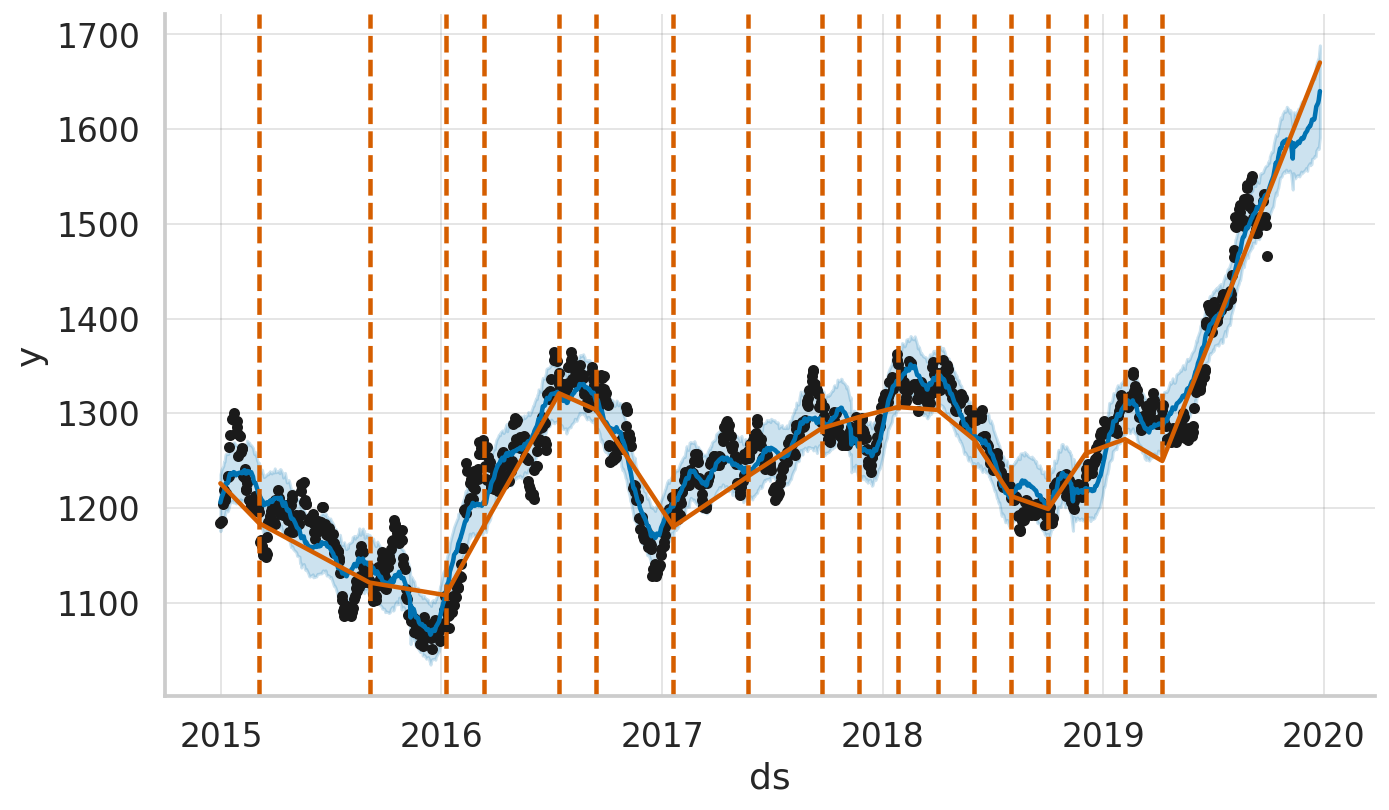

In [61]:
fig = prophet.plot(df_pred)
a = add_changepoints_to_plot(
    fig.gca(), prophet, df_pred
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_33")

Figure 7.33: The model’s fit together with the identified changepoints

우리는 학습된 Prophet 모델의 changepoints 메서드를 사용하여 변화점으로 식별된 정확한 날짜들을 확인할 수도 있습니다.

In [62]:
prophet.changepoints

43     2015-03-05
86     2015-05-06
129    2015-07-08
171    2015-09-04
214    2015-11-05
257    2016-01-08
300    2016-03-11
343    2016-05-12
386    2016-07-14
428    2016-09-13
471    2016-11-15
514    2017-01-19
557    2017-03-22
600    2017-05-23
643    2017-07-25
685    2017-09-22
728    2017-11-22
771    2018-01-26
814    2018-04-02
857    2018-06-01
900    2018-08-02
942    2018-10-02
985    2018-12-03
1028   2019-02-06
1071   2019-04-09
Name: ds, dtype: datetime64[ns]

8. Inspect the decomposition of the time series:

**Step 8**에서는 모델의 구성 요소를 검사했습니다. 이를 위해 **plot_components** 메서드를 사용하여 예측 DataFrame을 메서드의 인수로 전달했습니다.

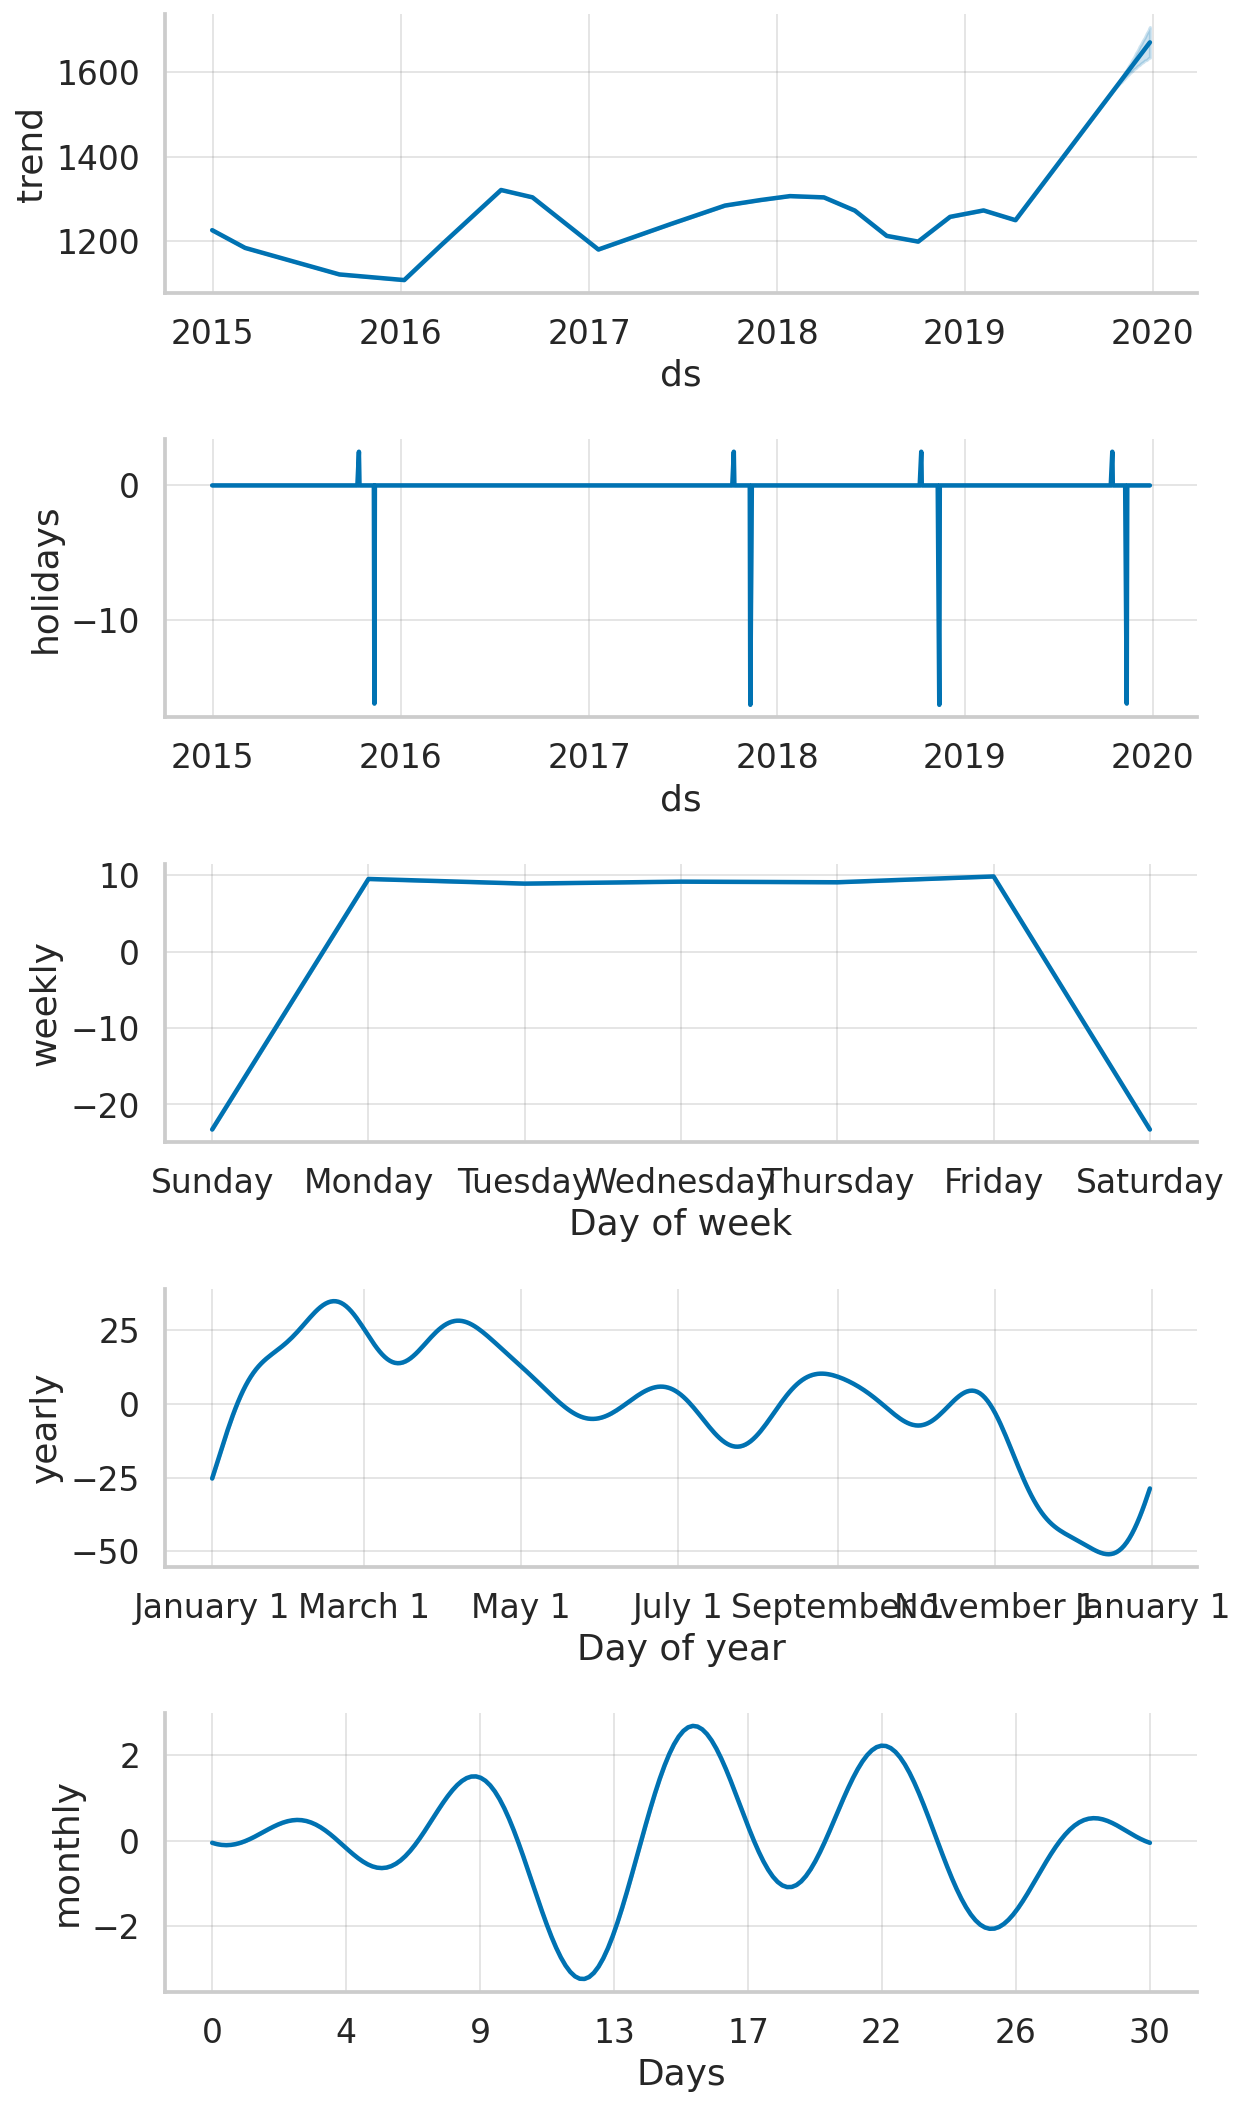

In [63]:
prophet.plot_components(df_pred)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_34")

Figure 7.34: The decomposition plot showing the individual components of the Prophet model

우리는 금 가격의 시계열 데이터에 대해 구성 요소를 많이 분석하지 않았습니다. 이는 금 가격이 많은 계절적 효과를 갖고 있지 않거나 미국의 공휴일에 영향을 받지 않을 가능성이 높기 때문입니다. 주식 시장은 주요 공휴일에 문을 닫기 때문에 이러한 공휴일의 영향은 공휴일 전후에 시장에 반영될 수 있습니다. 앞서 언급한 것처럼, 우리는 그 점을 인지하고 있으며, 단지 Prophet이 어떻게 작동하는지 보여주고자 했습니다.

주의해야 할 점은 주말, 특히 토요일과 일요일의 주간 계절성이 눈에 띄게 다르다는 것입니다. 이는 금 가격이 주중에만 수집된다는 사실 때문입니다. 따라서 우리는 주말 패턴을 안전하게 무시할 수 있습니다.

그러나 추세 구성 요소를 관찰하는 것은 흥미롭습니다. 이를 **그림 7.33**에서 감지된 변화점들과 함께 볼 수 있습니다.

9. Merge the test set with the forecasts:

**Step 9**에서는 테스트 세트와 예측 DataFrame을 병합했습니다. 우리는 **left join**을 사용했으며, 이는 왼쪽 테이블(테스트 세트)의 모든 행과 오른쪽 테이블(예측 DataFrame)의 일치하는 행을 반환하고 일치하지 않는 행은 비워 둡니다.

In [64]:
SELECTED_COLS = [
    "ds", "yhat", "yhat_lower", "yhat_upper"
]

df_pred = (
    df_pred
    .loc[:, SELECTED_COLS]
    .reset_index(drop=True)
)
df_test = df_test.merge(df_pred, on=["ds"], how="left")
df_test["ds"] = pd.to_datetime(df_test["ds"])
df_test = df_test.set_index("ds")

10. Plot the test values vs. predictions:

마지막으로, 우리는 예측값을 신뢰 구간과 함께 플로팅하고, 모델 성능을 시각적으로 평가하기 위해 실제 데이터를 플롯했습니다.

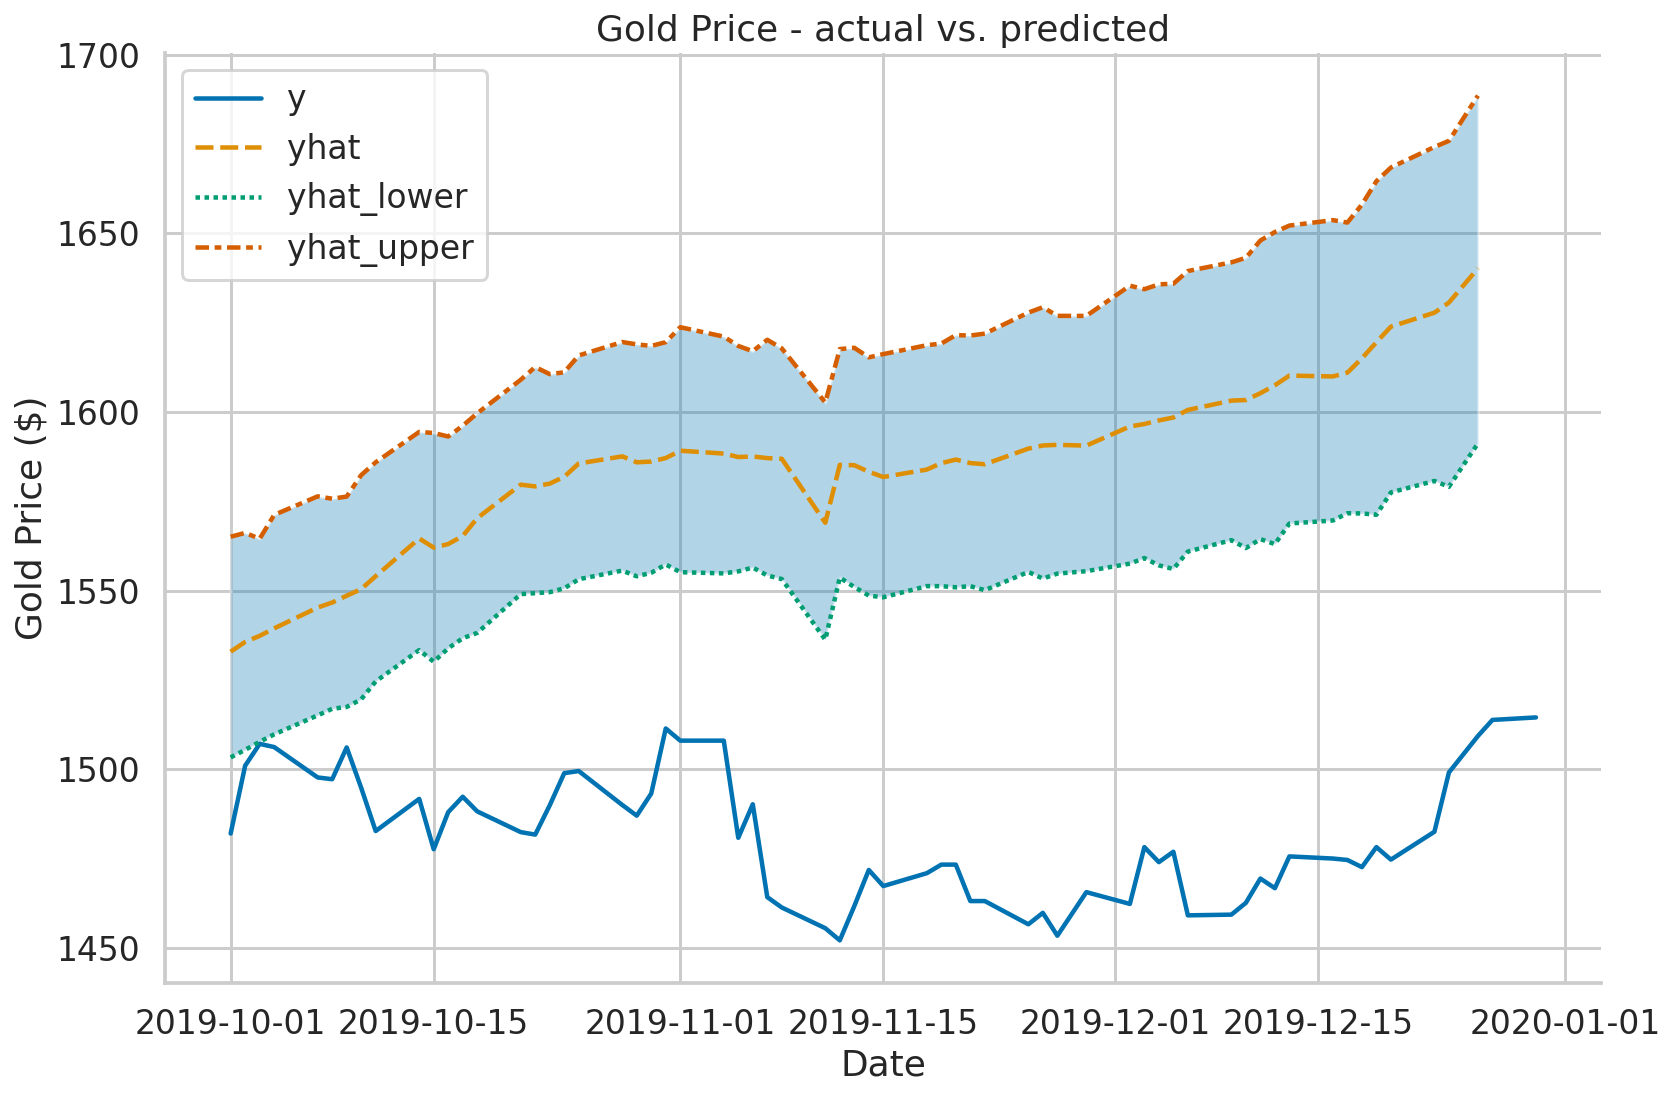

In [65]:
fig, ax = plt.subplots(1, 1)

PLOT_COLS = [
    "y", "yhat", "yhat_lower", "yhat_upper"
]
ax = sns.lineplot(data=df_test[PLOT_COLS])
ax.fill_between(
    df_test.index,
    df_test["yhat_lower"],
    df_test["yhat_upper"],
    alpha=0.3
)

ax.set(
    title="Gold Price - actual vs. predicted",
    xlabel="Date",
    ylabel="Gold Price ($)"
)

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_35")

Figure 7.35: Forecast vs ground truth

**그림 7.35**에서 볼 수 있듯이, 모델의 예측이 상당히 빗나갔습니다. 사실, 80% 신뢰 구간(기본 설정이며, **interval_width** 하이퍼파라미터를 사용해 변경할 수 있음)이 실제 값의 거의 대부분을 포착하지 못했습니다.

### There's more

1. Import the libraries:

In [66]:
from prophet.diagnostics import (cross_validation, 
                                 performance_metrics)
from prophet.plot import plot_cross_validation_metric

2. Run Prophet's cross-validation :

In [67]:
df_cv = cross_validation(
    prophet, 
    initial="756 days", 
    period="60 days", 
    horizon = "60 days"
)

df_cv

  0%|          | 0/16 [00:00<?, ?it/s]

19:15:00 - cmdstanpy - INFO - Chain [1] start processing
19:15:00 - cmdstanpy - INFO - Chain [1] done processing
19:15:00 - cmdstanpy - INFO - Chain [1] start processing
19:15:00 - cmdstanpy - INFO - Chain [1] done processing
19:15:00 - cmdstanpy - INFO - Chain [1] start processing
19:15:00 - cmdstanpy - INFO - Chain [1] done processing
19:15:01 - cmdstanpy - INFO - Chain [1] start processing
19:15:01 - cmdstanpy - INFO - Chain [1] done processing
19:15:01 - cmdstanpy - INFO - Chain [1] start processing
19:15:01 - cmdstanpy - INFO - Chain [1] done processing
19:15:01 - cmdstanpy - INFO - Chain [1] start processing
19:15:01 - cmdstanpy - INFO - Chain [1] done processing
19:15:01 - cmdstanpy - INFO - Chain [1] start processing
19:15:01 - cmdstanpy - INFO - Chain [1] done processing
19:15:02 - cmdstanpy - INFO - Chain [1] start processing
19:15:02 - cmdstanpy - INFO - Chain [1] done processing
19:15:02 - cmdstanpy - INFO - Chain [1] start processing
19:15:02 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-13,1239.993467,1212.986184,1265.039187,1224.400024,2017-02-12
1,2017-02-14,1242.893880,1215.867499,1270.434962,1223.900024,2017-02-12
2,2017-02-15,1244.780728,1216.817208,1272.087423,1231.699951,2017-02-12
3,2017-02-16,1246.184612,1218.855598,1273.938373,1240.000000,2017-02-12
4,2017-02-17,1245.740219,1217.987509,1271.997041,1237.599976,2017-02-12
...,...,...,...,...,...,...
656,2019-09-24,1413.727378,1377.619547,1448.473936,1532.099976,2019-08-01
657,2019-09-25,1414.267749,1378.494048,1450.930159,1504.599976,2019-08-01
658,2019-09-26,1413.678227,1376.231356,1450.963846,1507.500000,2019-08-01
659,2019-09-27,1412.880240,1375.741012,1450.412850,1499.099976,2019-08-01


In [68]:
df_cv["cutoff"].value_counts().sort_index()

2017-02-12    43
2017-04-13    40
2017-06-12    43
2017-08-11    41
2017-10-10    42
2017-12-09    39
2018-02-07    40
2018-04-08    43
2018-06-07    41
2018-08-06    43
2018-10-05    41
2018-12-04    39
2019-02-02    42
2019-04-03    40
2019-06-02    43
2019-08-01    41
Name: cutoff, dtype: int64

In [69]:
df_cv.head(50)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-13,1239.993467,1212.986184,1265.039187,1224.400024,2017-02-12
1,2017-02-14,1242.893880,1215.867499,1270.434962,1223.900024,2017-02-12
2,2017-02-15,1244.780728,1216.817208,1272.087423,1231.699951,2017-02-12
3,2017-02-16,1246.184612,1218.855598,1273.938373,1240.000000,2017-02-12
4,2017-02-17,1245.740219,1217.987509,1271.997041,1237.599976,2017-02-12
5,2017-02-21,1249.468003,1220.939630,1276.899157,1237.500000,2017-02-12
6,2017-02-22,1247.650328,1219.730896,1275.837703,1232.000000,2017-02-12
7,2017-02-23,1246.630056,1220.309463,1274.056536,1250.199951,2017-02-12
8,2017-02-24,1245.524520,1218.187023,1274.328103,1256.900024,2017-02-12
9,2017-02-27,1248.689242,1220.850907,1277.293989,1257.400024,2017-02-12


3. Calculate the aggregated performance metrics:

In [70]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,6 days,1718.783014,41.458208,31.211327,0.023731,0.016598,0.023916,0.581818
1,7 days,1947.370677,44.129023,33.571496,0.025553,0.021097,0.025818,0.541322
2,8 days,2208.498065,46.994660,36.312212,0.027516,0.023161,0.027830,0.495868
3,9 days,2376.734296,48.751762,38.953007,0.029613,0.024392,0.029874,0.446970
4,10 days,2516.329046,50.163025,41.273289,0.031661,0.028676,0.031928,0.402778
5,11 days,2647.194254,51.450892,42.239601,0.032461,0.027757,0.032769,0.402204
6,12 days,2633.947320,51.321996,42.607929,0.032730,0.027834,0.033025,0.388430
7,13 days,2934.165281,54.167936,45.227126,0.034693,0.031553,0.034988,0.373278
8,14 days,3250.694659,57.014863,47.795842,0.036704,0.034134,0.037013,0.327824
9,15 days,3608.416770,60.070099,50.213098,0.038319,0.034134,0.038667,0.289256


4. Plot the MAPE score:

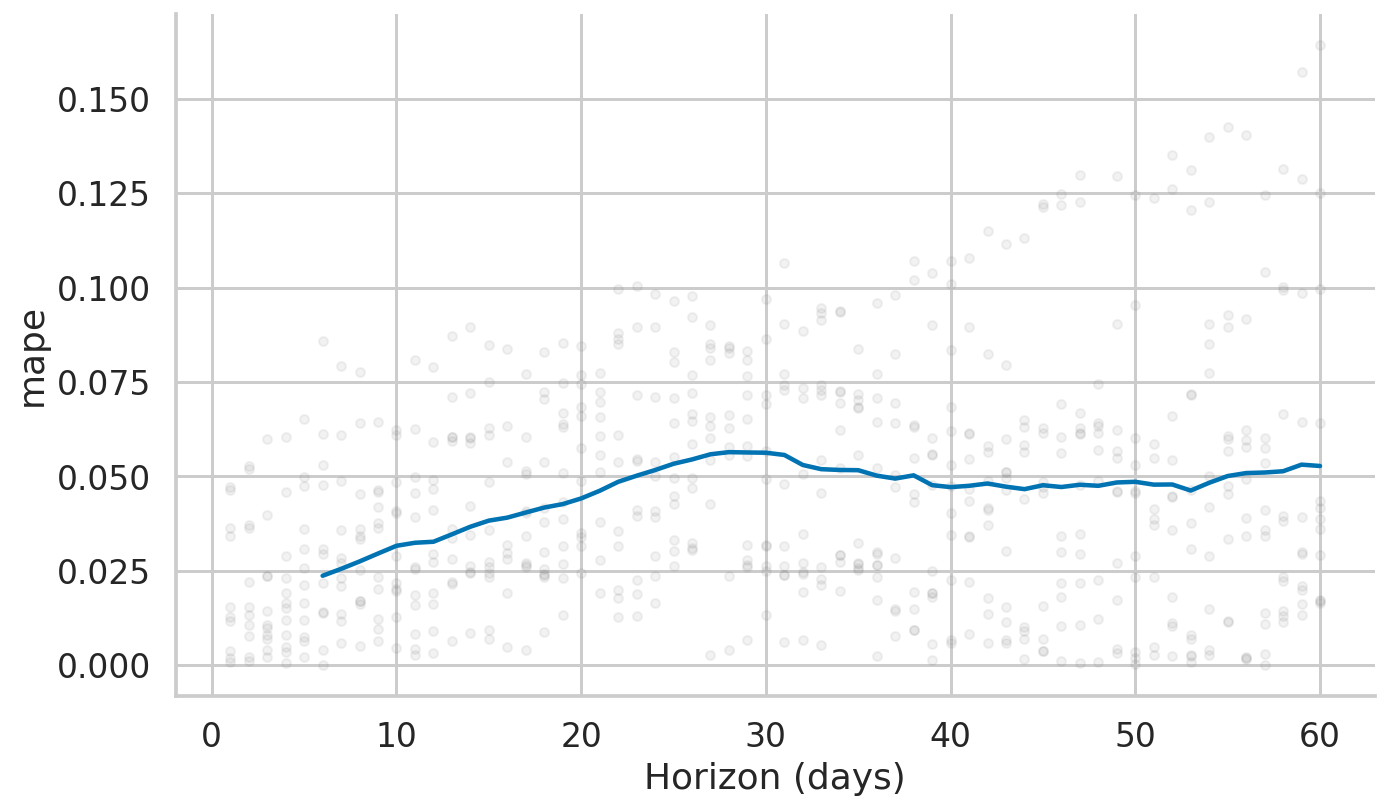

In [71]:
plot_cross_validation_metric(df_cv, metric="mape")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_38")

## 7.5 AutoML for time series forecasting with PyCaret

### Getting ready

1. Import the libraries and authenticate:

In [3]:
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the monthly US unemployment rate from years 2010-2019:

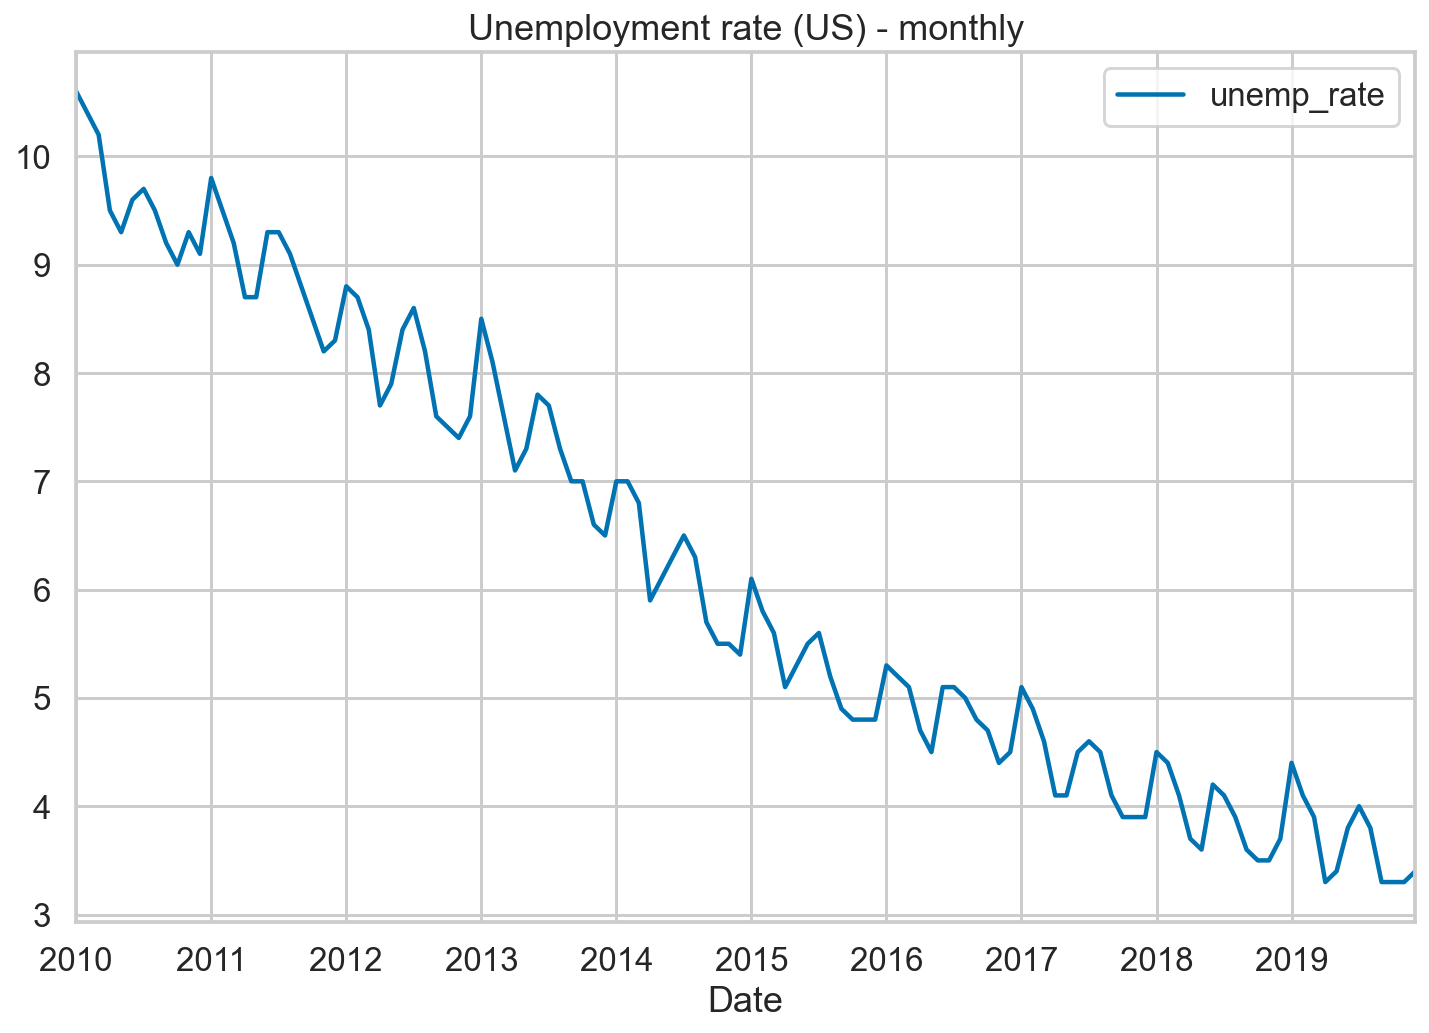

In [4]:
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA", 
                       start_date="2010-01-01", 
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)
df.plot(title="Unemployment rate (US) - monthly");

### How to do it...

1. Import the libraries:

In [5]:
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

2. Set up the experiment:

In [6]:
exp = TSForecastingExperiment()
exp.setup(df, fh=6, fold=5, session_id=42)

,Description,Value
0,session_id,42
1,Target,unemp_rate
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(120, 1)"
5,Transformed data shape,"(120, 1)"
6,Transformed train set shape,"(114, 1)"
7,Transformed test set shape,"(6, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


3. Explore the time series using visualizations:

In [7]:
exp.plot_model(
    plot="diagnostics", 
    fig_kwargs={"height": 800, "width": 1000}
)

In [8]:
exp.plot_model(plot="cv")

Some additional plots:

In [9]:
exp.plot_model(plot="ts")

In [10]:
exp.plot_model(plot="acf")

In [11]:
exp.plot_model(plot="decomp_stl")

In [12]:
exp.plot_model(plot="periodogram")

In [13]:
exp.plot_model(plot="fft")

4. Run statistical tests on the time series:

In [14]:
exp.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,120.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,6.225
3,Summary,Statistics,Transformed,Median,,5.6
4,Summary,Statistics,Transformed,Standard Deviation,,2.10223
5,Summary,Statistics,Transformed,Variance,,4.41937
6,Summary,Statistics,Transformed,Kurtosis,,-1.232708
7,Summary,Statistics,Transformed,Skewness,,0.345242
8,Summary,Statistics,Transformed,# Distinct Values,,59.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",1610.583379


In [15]:
exp.check_stats(test="summary")

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,120.000000
1,Summary,Statistics,Transformed,# Missing Values,,0.000000
2,Summary,Statistics,Transformed,Mean,,6.225000
3,Summary,Statistics,Transformed,Median,,5.600000
4,Summary,Statistics,Transformed,Standard Deviation,,2.102230
5,Summary,Statistics,Transformed,Variance,,4.419370
6,Summary,Statistics,Transformed,Kurtosis,,-1.232708
7,Summary,Statistics,Transformed,Skewness,,0.345242
8,Summary,Statistics,Transformed,# Distinct Values,,59.000000


5. Find the five best fitting pipelines:

In [16]:
best_pipelines = exp.compare_models(
    sort="MAPE", turbo=False, n_select=5
)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
bats,BATS,0.1222,0.1364,0.0911,0.1105,0.0225,0.0227,0.8702,1.9560
tbats,TBATS,0.1308,0.1410,0.0976,0.1142,0.0239,0.0242,0.8641,4.7420
auto_arima,Auto ARIMA,0.1487,0.1626,0.1110,0.1319,0.0280,0.0287,0.7229,2.6500
prophet,Prophet,0.1599,0.1675,0.1201,0.1364,0.0293,0.0294,0.8053,0.8420
theta,Theta Forecaster,0.1802,0.1906,0.1348,0.1547,0.0332,0.0332,0.7221,0.0080
ets,ETS,0.1976,0.2108,0.1474,0.1708,0.0358,0.0364,0.6639,0.0160
exp_smooth,Exponential Smoothing,0.2074,0.2256,0.1547,0.1828,0.0371,0.0381,0.6565,0.0220
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.2118,0.2510,0.1608,0.2056,0.0390,0.0403,0.4461,0.0200
arima,ARIMA,0.2453,0.2573,0.1833,0.2088,0.0462,0.0477,0.4979,0.0400
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.2516,0.2635,0.1907,0.2163,0.0465,0.0481,0.4679,0.0400


Processing:   0%|          | 0/141 [00:00<?, ?it/s]

In [17]:
best_pipelines

[BATS(show_warnings=False, sp=12, use_box_cox=True),
 TBATS(show_warnings=False, sp=[12], use_box_cox=True),
 AutoARIMA(random_state=42, sp=12, suppress_warnings=True),
 ProphetPeriodPatched(),
 ThetaForecaster(sp=12)]

In [18]:
# recover the DataFrame with the metrics
compare_metrics_base = exp.pull()
compare_metrics_base

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
bats,BATS,0.1222,0.1364,0.0911,0.1105,0.0225,0.0227,0.8702,1.956
tbats,TBATS,0.1308,0.141,0.0976,0.1142,0.0239,0.0242,0.8641,4.742
auto_arima,Auto ARIMA,0.1487,0.1626,0.111,0.1319,0.028,0.0287,0.7229,2.650
prophet,Prophet,0.1599,0.1675,0.1201,0.1364,0.0293,0.0294,0.8053,0.842
theta,Theta Forecaster,0.1802,0.1906,0.1348,0.1547,0.0332,0.0332,0.7221,0.008
ets,ETS,0.1976,0.2108,0.1474,0.1708,0.0358,0.0364,0.6639,0.016
exp_smooth,Exponential Smoothing,0.2074,0.2256,0.1547,0.1828,0.0371,0.0381,0.6565,0.022
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonali...,0.2118,0.251,0.1608,0.2056,0.039,0.0403,0.4461,0.020
arima,ARIMA,0.2453,0.2573,0.1833,0.2088,0.0462,0.0477,0.4979,0.040
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.2516,0.2635,0.1907,0.2163,0.0465,0.0481,0.4679,0.040


In [19]:
# inspect the available models
exp.models()

,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
grand_means,Grand Means Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
polytrend,Polynomial Trend Forecaster,sktime.forecasting.trend.PolynomialTrendForeca...,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
exp_smooth,Exponential Smoothing,sktime.forecasting.exp_smoothing.ExponentialSm...,True
croston,Croston,sktime.forecasting.croston.Croston,True
ets,ETS,sktime.forecasting.ets.AutoETS,True


6. Tune the best pipelines:

In [20]:
best_pipelines_tuned = [exp.tune_model(model) for model in best_pipelines]
best_pipelines_tuned

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-12,0.0945,0.1060,0.0748,0.0904,0.0174,0.0172,0.9412
1,2017-06,0.0870,0.0946,0.0665,0.0785,0.0159,0.0161,0.9283
2,2017-12,0.1445,0.1634,0.1087,0.1333,0.0262,0.0268,0.8405
3,2018-06,0.1043,0.1221,0.0765,0.0974,0.0207,0.0209,0.8028
4,2018-12,0.1805,0.1961,0.1290,0.1530,0.0321,0.0328,0.8382
Mean,nan,0.1222,0.1364,0.0911,0.1105,0.0225,0.0227,0.8702
SD,nan,0.0353,0.0379,0.0238,0.0280,0.0060,0.0062,0.0545


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.6s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-12,0.1086,0.1107,0.0860,0.0944,0.0195,0.0193,0.9360
1,2017-06,0.1100,0.1084,0.0840,0.0899,0.0201,0.0203,0.9058
2,2017-12,0.1333,0.1438,0.1003,0.1173,0.0239,0.0243,0.8765
3,2018-06,0.1037,0.1202,0.0760,0.0958,0.0206,0.0208,0.8089
4,2018-12,0.1883,0.2112,0.1345,0.1648,0.0335,0.0343,0.8123
Mean,nan,0.1288,0.1389,0.0962,0.1125,0.0236,0.0238,0.8679
SD,nan,0.0315,0.0383,0.0207,0.0278,0.0052,0.0055,0.0504


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   27.3s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-12,0.0288,0.0298,0.0228,0.0254,0.0050,0.0050,0.9954
1,2017-06,0.2671,0.2721,0.2041,0.2256,0.0503,0.0520,0.4068
2,2017-12,0.1487,0.1754,0.1119,0.1430,0.0276,0.0282,0.8164
3,2018-06,0.1597,0.1994,0.1171,0.1590,0.0314,0.0321,0.4737
4,2018-12,0.1390,0.1361,0.0993,0.1062,0.0259,0.0262,0.9220
Mean,nan,0.1487,0.1626,0.1110,0.1319,0.0280,0.0287,0.7229
SD,nan,0.0756,0.0798,0.0577,0.0658,0.0145,0.0150,0.2386


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   24.9s remaining:   16.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-12,0.0641,0.0681,0.0507,0.0580,0.0110,0.0110,0.9758
1,2017-06,0.0806,0.0784,0.0616,0.0650,0.0147,0.0148,0.9508
2,2017-12,0.1033,0.1105,0.0777,0.0901,0.0193,0.0195,0.9271
3,2018-06,0.1234,0.1649,0.0905,0.1315,0.0244,0.0250,0.6400
4,2018-12,0.2904,0.2774,0.2075,0.2165,0.0539,0.0555,0.6762
Mean,nan,0.1324,0.1398,0.0976,0.1122,0.0247,0.0252,0.8340
SD,nan,0.0815,0.0766,0.0566,0.0581,0.0153,0.0159,0.1449


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.2s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-12,0.1582,0.1652,0.1252,0.1409,0.0277,0.0276,0.8573
1,2017-06,0.1108,0.1230,0.0847,0.1020,0.0200,0.0201,0.8789
2,2017-12,0.2244,0.2304,0.1688,0.1879,0.0401,0.0410,0.6831
3,2018-06,0.2083,0.2136,0.1527,0.1704,0.0418,0.0407,0.3959
4,2018-12,0.1993,0.2206,0.1424,0.1722,0.0364,0.0368,0.7952
Mean,nan,0.1802,0.1906,0.1348,0.1547,0.0332,0.0332,0.7221
SD,nan,0.0410,0.0406,0.0288,0.0304,0.0082,0.0082,0.1767


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


[BATS(show_warnings=False, sp=12, use_box_cox=True),
 TBATS(show_warnings=False, sp=[12], use_box_cox=True, use_damped_trend=True,
       use_trend=True),
 AutoARIMA(random_state=42, sp=12, suppress_warnings=True),
 ProphetPeriodPatched(changepoint_prior_scale=0.016439324494196616,
                      holidays_prior_scale=0.01095960453692584,
                      seasonality_prior_scale=7.886714129990491),
 ThetaForecaster(sp=12)]

7. Blend the 5 tuned pipelines:

In [21]:
blended_model = exp.blend_models(
    best_pipelines_tuned, method="mean"
)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2016-12,0.0764,0.0749,0.0605,0.0639,0.0136,0.0135,0.9707
1,2017-06,0.1044,0.1102,0.0798,0.0913,0.0192,0.0194,0.9028
2,2017-12,0.1373,0.1496,0.1033,0.1220,0.0250,0.0254,0.8664
3,2018-06,0.1172,0.1299,0.0859,0.1036,0.0230,0.0232,0.7768
4,2018-12,0.1706,0.1922,0.1219,0.1500,0.0302,0.0308,0.8445
Mean,nan,0.1212,0.1314,0.0903,0.1062,0.0222,0.0225,0.8722
SD,nan,0.0316,0.0392,0.0209,0.0289,0.0056,0.0058,0.0641


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

8. Create the predictions using the blended model and plot the forecasts:

In [22]:
y_pred = exp.predict_model(blended_model)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,EnsembleForecaster,0.1707,0.1685,0.1174,0.1281,0.0328,0.0333,0.7898


In [23]:
exp.plot_model(estimator=blended_model)

9. Finalize the model:

In [24]:
final_model = exp.finalize_model(blended_model)
exp.plot_model(final_model)

In [25]:
y_pred = exp.predict_model(final_model)
print(y_pred)

         y_pred
2020-01  3.8437
2020-02  3.6852
2020-03  3.4731
2020-04  3.0444
2020-05  3.0711
2020-06  3.4585
